In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import numpy as np
import scipy.stats as stats
import pylab as pl

'''
filename
fifa_2018_results.csv
fifa_2018_results_updated_20180708.csv
fifa_2018_stats.csv
past_results.csv
players_scores.csv
sofifa.csv
'''

#Preparing data
data = pd.read_csv('dataset/fifa_2018_results_updated_20180708.csv')
data.head()

data_home = data.groupby('home_team', as_index = False).agg({"home_result": np.sum})
data_away = data.groupby('away_team', as_index = False).agg({"away_result": np.sum})

data = data_home.rename( columns = {'home_team' : 'team'})
data['away_result'] = data_away['away_result']
data['total_score'] = data['away_result'] + data['home_result'] 

In [2]:
#Training Data
sofifa = pd.read_csv('dataset/sofifa1.csv') #only the latest stat
sofifa.rename(columns = {'countrystats' : 'team'} , inplace = True)
sofifa.head()

data_new = pd.read_csv('dataset/fifa_2018_results_updated_20180708.csv')
data1 = data_new.join(sofifa.set_index('team'), on = 'home_team')
data1 = data1.join(sofifa.add_suffix('_opponent').set_index('team_opponent'), on = 'away_team')

data1 = data1.drop(columns=['game','away_team','away_result','home_penalty','away_penalty','lat','long','stadium' ,'country','city','datestats','bu_positioning','cc_positioning','datestats_opponent','bu_positioning_opponent','cc_positioning_opponent'])
data1 = data1.rename( columns = {'home_team': 'team','home_result' : 'result'})

data2 = data_new.join(sofifa.set_index('team'), on = 'away_team')
data2 = data2.join(sofifa.add_suffix('_opponent').set_index('team_opponent'), on = 'home_team')

data2 = data2.drop(columns=['game','home_team','home_result','home_penalty','away_penalty','lat','long','stadium' ,'country','city','datestats','bu_positioning','cc_positioning','datestats_opponent','bu_positioning_opponent','cc_positioning_opponent'])
data2 = data2.rename( columns = {'away_team': 'team','away_result' : 'result'})

pd.options.display.max_rows = 200
data_new = data1.append(data2 , ignore_index = True)
data_new = data_new.dropna()
#Feature Transformation

# split train and test
y = data_new['result']
X = data_new.drop(columns = ['date','team','result'])
X = normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

#Prediction Data
fr = sofifa[sofifa['team'] == 'France'].drop(columns = ['datestats','bu_positioning','cc_positioning']).reset_index(drop=True)
cr = sofifa[sofifa['team'] == 'Croatia'].drop(columns = ['datestats','bu_positioning','cc_positioning']).reset_index(drop=True)

data_predict = fr.join( cr.drop(columns = 'team').add_suffix('_opponent'))
data_predict = data_predict.append(cr.join(fr.drop(columns = 'team').add_suffix('_opponent')), ignore_index = True)
team = data_predict['team']
data_predict.drop(columns ='team', inplace = True)
data_predict

(64, 24) (64,)
(8, 24) (8,)


,overall,attack,midfield,defense,bu_speed,bu_passing,cc_crossing,cc_passing,cc_shooting,aggression,...,midfield_opponent,defense_opponent,bu_speed_opponent,bu_passing_opponent,cc_crossing_opponent,cc_passing_opponent,cc_shooting_opponent,aggression_opponent,pressure_opponent,avg_age_opponent
0,84,83,85,82,35,30,53,24,35,47,...,78,74,59,44,74,39,61,61,61,26.64
1,78,78,78,74,59,44,74,39,61,61,...,85,82,35,30,53,24,35,47,47,25.65


In [3]:
team = np.array(data['team'])
home_s = np.array(data['home_result'])
away_s = np.array(data['away_result'])
total_s = np.array(data['total_score'])

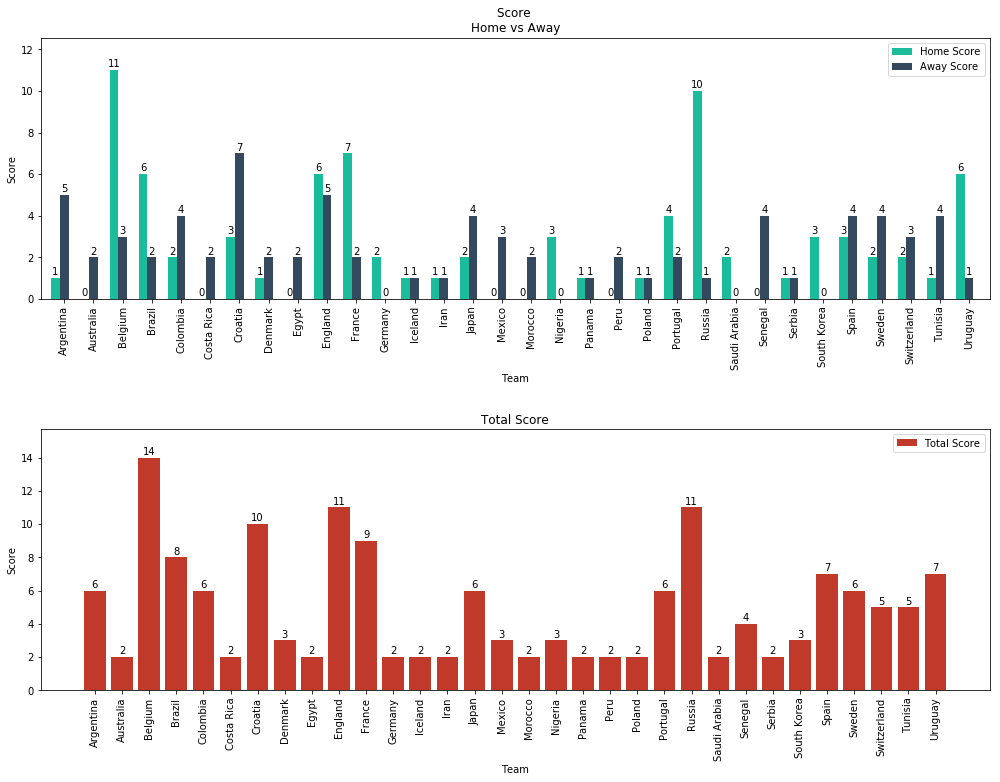

In [4]:
data['team'] = data['team'].astype('category')
index = data['team'].cat.codes
width = 0.3

fig , (ax ,axt) = plt.subplots(2, figsize=(17,12))
fig.subplots_adjust(hspace=.5)

home = ax.bar(index, home_s, width, label = 'Home Score', color = '#1abc9c')
away = ax.bar(index +width, away_s, width, label = 'Away Score', color ='#34495e')


def autolabel(bar):
    for b in bar:
        height = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, height+0.05, height, ha='center', va='bottom')
    
ax.set_xlim(left = min(index)-0.5 , right = max(index) + 1 )
ax.set_ylim(top = ax.get_ylim()[1] + 1)
ax.set_xticks(index + width) 
ax.set_xticklabels(team,  rotation='vertical')
ax.set_title('Score \nHome vs Away')
ax.set_xlabel('Team')
ax.set_ylabel('Score')
ax.legend()

autolabel(away)
autolabel(home)


total = axt.bar(data['team'], data['total_score'], label = 'Total Score' , color = '#c0392b')
axt.set_ylim(top = axt.get_ylim()[1] + 1)
axt.set_xticks(data['team']) 
axt.set_xticklabels(data['team'],  rotation='vertical')
axt.set_title('Total Score')
axt.set_xlabel('Team')
axt.set_ylabel('Score')
axt.legend()

for b in total:
    height = b.get_height()
    axt.text(b.get_x() +b.get_width()/2, height+0.05, height, ha='center', va='bottom')
    
plt.show()

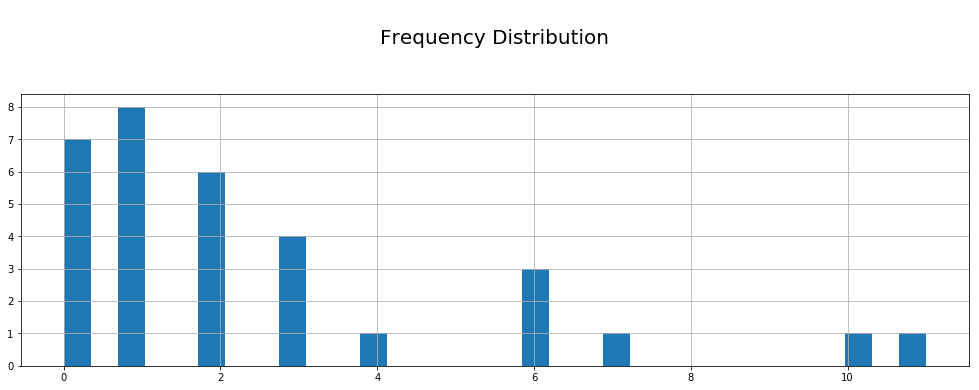

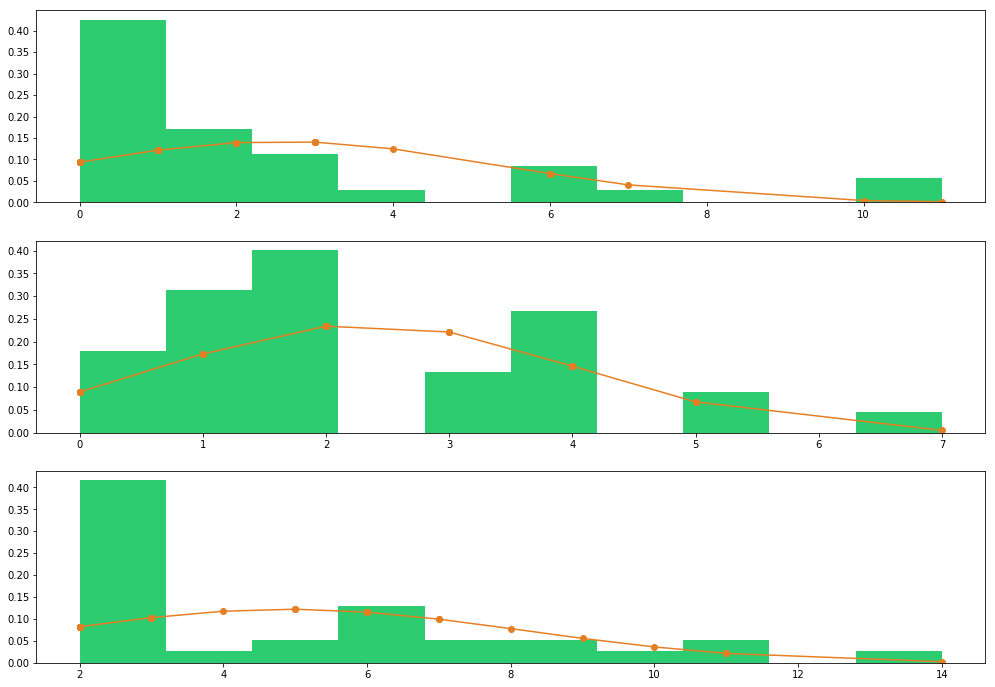

In [5]:
#Frequency Distribution 
sorted_home = np.sort(home_s)
sorted_away = np.sort(away_s)
sorted_total = np.sort(total_s)

plt.figure(figsize=(17,5))
plt.hist(sorted_home, bins = home_s.size)
plt.title('\nFrequency Distribution\n\n', fontsize= 20)
plt.grid(True)
plt.show()

fig , (fq1,fq2,fq3) = plt.subplots(3, figsize=(17,12))

def freq_dist(fq,dat):    
    fit = stats.norm.pdf(dat, np.mean(dat), np.std(dat)) 
    fq.plot(dat,fit,'-o' , color = '#e67e22')
    fq.hist(dat, density=True , color = '#2ecc71')
     
freq_dist(fq1,sorted_home)
freq_dist(fq2,sorted_away)
freq_dist(fq3,sorted_total)

plt.show() 

In [6]:
#Descriptive Analysis

#Mean | not skewed
home_mean = home_s.sum()/ home_s.size
away_mean = away_s.sum()/ away_s.size
total_mean = total_s.sum()/ total_s.size
print('Mean')
print(' Home : ' + str(home_mean))
print(' Away : ' + str(away_mean))
print(' Total : ' + str(total_mean))

#Median| skewed

#Mode
#Best measure of central tendency (nominal)
print('Mode')
print(' Home : ' + str(np.nanmax(home_s)))
print(' Away : ' + str(np.nanmax(away_s)))
print(' Total : ' + str(np.nanmax(total_s)))

Mean
 Home : 2.5625
 Away : 2.34375
 Total : 4.90625
Mode
 Home : 11
 Away : 7
 Total : 14


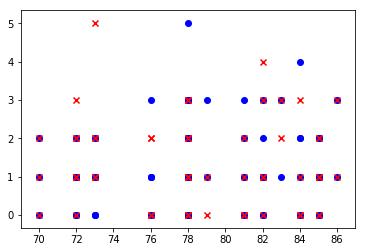

In [7]:
#Analyze Data Condition for model selection
result = np.array( data_new['result'])
overall = np.array(data_new['overall'])
overall_op = np.array(data_new['overall_opponent'])

for i in range (0,result.size):
    plt.scatter(overall[i],result[i], marker ='o', c ='b')

for i in range (0,result.size):
    plt.scatter(overall_op[i],result[i] , marker = 'x', c= 'r')
    
plt.show()



In [8]:
#Feature Extraction
from sklearn.decomposition import PCA, KernelPCA

def PCA_Transformer(PCA_data):    
    PCA_data = np.array(PCA_data)
    pca =PCA(n_components =24)
    pca.fit(PCA_data)
    #pca.fit_transform(PCA_data)
    X = pca.transform(PCA_data)
    print(pca.explained_variance_ratio_)
    print(pca.singular_values_)  
    print(X.size)
    
    return X


In [9]:
X_train = PCA_Transformer(X_train)

[2.76300047e-01 2.55820634e-01 1.09871020e-01 6.84516157e-02
 6.75439110e-02 4.62106305e-02 4.27132420e-02 3.42813106e-02
 3.13977825e-02 2.24505010e-02 1.87189897e-02 1.11271697e-02
 4.94614905e-03 2.74790330e-03 2.68435897e-03 1.62113845e-03
 1.20629263e-03 6.22120000e-04 4.66096390e-04 4.09215548e-04
 1.55807303e-04 1.46851626e-04 5.97211627e-05 4.74923286e-05]
[0.66061725 0.63566342 0.41658249 0.32881475 0.32662734 0.27016581
 0.25974112 0.23269558 0.22269421 0.1883096  0.17194939 0.13257199
 0.08838794 0.065881   0.0651148  0.05060221 0.04365015 0.03134704
 0.02713297 0.02542351 0.01568749 0.01522996 0.00971233 0.00866106]
1536


In [10]:
#Modelling
from sklearn.neural_network import MLPClassifier

clf1 = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
                   early_stopping=False, hidden_layer_sizes=(100, 2), learning_rate='adaptive',
                   learning_rate_init=0.0001, max_iter=100000, random_state=1, shuffle=True,
                   solver='lbfgs', tol = 0.000001, validation_fraction=0.1, verbose=True,
                   warm_start=False)
clf1.fit(X_train, y_train)

clf2 =  MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto',
                     beta_1=0.9, beta_2=0.999, early_stopping=False,
                     epsilon=1e-08, hidden_layer_sizes=(100, 2), learning_rate='adaptive',
                     learning_rate_init=0.0001, max_iter=100000,random_state=1, shuffle=True,
                     solver='adam', tol = 0.000001, validation_fraction=0.1, verbose=True,
                     warm_start=False)

clf2.fit(X_train, y_train)

clf3 = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
                       early_stopping=False,hidden_layer_sizes=(100, 2), learning_rate='adaptive',
                       learning_rate_init=0.0001, max_iter=100000, momentum=0.9,
                       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
                       solver='sgd',tol = 0.000001, validation_fraction=0.1, verbose=True,
                       warm_start=False)

clf3.fit(X_train, y_train)

Iteration 1, loss = 2.03286198
Iteration 2, loss = 2.03233142
Iteration 3, loss = 2.03180125
Iteration 4, loss = 2.03127161
Iteration 5, loss = 2.03074257
Iteration 6, loss = 2.03021428
Iteration 7, loss = 2.02968680
Iteration 8, loss = 2.02915980
Iteration 9, loss = 2.02863328
Iteration 10, loss = 2.02810732
Iteration 11, loss = 2.02758191
Iteration 12, loss = 2.02705708
Iteration 13, loss = 2.02653276
Iteration 14, loss = 2.02600900
Iteration 15, loss = 2.02548585
Iteration 16, loss = 2.02496320
Iteration 17, loss = 2.02444126
Iteration 18, loss = 2.02391998
Iteration 19, loss = 2.02339930
Iteration 20, loss = 2.02287925
Iteration 21, loss = 2.02235982
Iteration 22, loss = 2.02184101
Iteration 23, loss = 2.02132284
Iteration 24, loss = 2.02080542
Iteration 25, loss = 2.02028872
Iteration 26, loss = 2.01977270
Iteration 27, loss = 2.01925734
Iteration 28, loss = 2.01874264
Iteration 29, loss = 2.01822874
Iteration 30, loss = 2.01771554
Iteration 31, loss = 2.01720317
Iteration 32, los

Iteration 291, loss = 1.94873905
Iteration 292, loss = 1.94865763
Iteration 293, loss = 1.94857632
Iteration 294, loss = 1.94849500
Iteration 295, loss = 1.94841367
Iteration 296, loss = 1.94833233
Iteration 297, loss = 1.94825097
Iteration 298, loss = 1.94816960
Iteration 299, loss = 1.94808835
Iteration 300, loss = 1.94800709
Iteration 301, loss = 1.94792578
Iteration 302, loss = 1.94784444
Iteration 303, loss = 1.94776327
Iteration 304, loss = 1.94768211
Iteration 305, loss = 1.94760094
Iteration 306, loss = 1.94751976
Iteration 307, loss = 1.94743858
Iteration 308, loss = 1.94735740
Iteration 309, loss = 1.94727622
Iteration 310, loss = 1.94719504
Iteration 311, loss = 1.94711386
Iteration 312, loss = 1.94703281
Iteration 313, loss = 1.94695174
Iteration 314, loss = 1.94687060
Iteration 315, loss = 1.94678941
Iteration 316, loss = 1.94670835
Iteration 317, loss = 1.94662729
Iteration 318, loss = 1.94654622
Iteration 319, loss = 1.94646515
Iteration 320, loss = 1.94638408
Iteration 

Iteration 587, loss = 1.92514444
Iteration 588, loss = 1.92506643
Iteration 589, loss = 1.92498843
Iteration 590, loss = 1.92491061
Iteration 591, loss = 1.92483269
Iteration 592, loss = 1.92475476
Iteration 593, loss = 1.92467683
Iteration 594, loss = 1.92459898
Iteration 595, loss = 1.92452106
Iteration 596, loss = 1.92444320
Iteration 597, loss = 1.92436532
Iteration 598, loss = 1.92428750
Iteration 599, loss = 1.92420970
Iteration 600, loss = 1.92413187
Iteration 601, loss = 1.92405397
Iteration 602, loss = 1.92397622
Iteration 603, loss = 1.92389839
Iteration 604, loss = 1.92382046
Iteration 605, loss = 1.92374272
Iteration 606, loss = 1.92366497
Iteration 607, loss = 1.92358713
Iteration 608, loss = 1.92350928
Iteration 609, loss = 1.92343159
Iteration 610, loss = 1.92335371
Iteration 611, loss = 1.92327600
Iteration 612, loss = 1.92319823
Iteration 613, loss = 1.92312041
Iteration 614, loss = 1.92304306
Iteration 615, loss = 1.92296511
Iteration 616, loss = 1.92288727
Iteration 

Iteration 883, loss = 1.90253777
Iteration 884, loss = 1.90246302
Iteration 885, loss = 1.90238825
Iteration 886, loss = 1.90231354
Iteration 887, loss = 1.90223875
Iteration 888, loss = 1.90216418
Iteration 889, loss = 1.90208959
Iteration 890, loss = 1.90201461
Iteration 891, loss = 1.90194009
Iteration 892, loss = 1.90186548
Iteration 893, loss = 1.90179071
Iteration 894, loss = 1.90171582
Iteration 895, loss = 1.90164111
Iteration 896, loss = 1.90156662
Iteration 897, loss = 1.90149186
Iteration 898, loss = 1.90141722
Iteration 899, loss = 1.90134265
Iteration 900, loss = 1.90126797
Iteration 901, loss = 1.90119321
Iteration 902, loss = 1.90111857
Iteration 903, loss = 1.90104410
Iteration 904, loss = 1.90096939
Iteration 905, loss = 1.90089488
Iteration 906, loss = 1.90082024
Iteration 907, loss = 1.90074590
Iteration 908, loss = 1.90067122
Iteration 909, loss = 1.90059660
Iteration 910, loss = 1.90052228
Iteration 911, loss = 1.90044787
Iteration 912, loss = 1.90037336
Iteration 

Iteration 1174, loss = 1.88121302
Iteration 1175, loss = 1.88114118
Iteration 1176, loss = 1.88106942
Iteration 1177, loss = 1.88099768
Iteration 1178, loss = 1.88092595
Iteration 1179, loss = 1.88085414
Iteration 1180, loss = 1.88078249
Iteration 1181, loss = 1.88071067
Iteration 1182, loss = 1.88063908
Iteration 1183, loss = 1.88056733
Iteration 1184, loss = 1.88049552
Iteration 1185, loss = 1.88042391
Iteration 1186, loss = 1.88035228
Iteration 1187, loss = 1.88028085
Iteration 1188, loss = 1.88020883
Iteration 1189, loss = 1.88013730
Iteration 1190, loss = 1.88006557
Iteration 1191, loss = 1.87999387
Iteration 1192, loss = 1.87992240
Iteration 1193, loss = 1.87985053
Iteration 1194, loss = 1.87977896
Iteration 1195, loss = 1.87970728
Iteration 1196, loss = 1.87963591
Iteration 1197, loss = 1.87956421
Iteration 1198, loss = 1.87949261
Iteration 1199, loss = 1.87942111
Iteration 1200, loss = 1.87934951
Iteration 1201, loss = 1.87927802
Iteration 1202, loss = 1.87920642
Iteration 1203

Iteration 1459, loss = 1.86112848
Iteration 1460, loss = 1.86105941
Iteration 1461, loss = 1.86099018
Iteration 1462, loss = 1.86092105
Iteration 1463, loss = 1.86085184
Iteration 1464, loss = 1.86078266
Iteration 1465, loss = 1.86071349
Iteration 1466, loss = 1.86064431
Iteration 1467, loss = 1.86057536
Iteration 1468, loss = 1.86050611
Iteration 1469, loss = 1.86043707
Iteration 1470, loss = 1.86036797
Iteration 1471, loss = 1.86029876
Iteration 1472, loss = 1.86022995
Iteration 1473, loss = 1.86016055
Iteration 1474, loss = 1.86009166
Iteration 1475, loss = 1.86002262
Iteration 1476, loss = 1.85995351
Iteration 1477, loss = 1.85988439
Iteration 1478, loss = 1.85981537
Iteration 1479, loss = 1.85974631
Iteration 1480, loss = 1.85967750
Iteration 1481, loss = 1.85960848
Iteration 1482, loss = 1.85953924
Iteration 1483, loss = 1.85947043
Iteration 1484, loss = 1.85940167
Iteration 1485, loss = 1.85933293
Iteration 1486, loss = 1.85926389
Iteration 1487, loss = 1.85919484
Iteration 1488

Iteration 1752, loss = 1.84120758
Iteration 1753, loss = 1.84114073
Iteration 1754, loss = 1.84107386
Iteration 1755, loss = 1.84100708
Iteration 1756, loss = 1.84094015
Iteration 1757, loss = 1.84087338
Iteration 1758, loss = 1.84080647
Iteration 1759, loss = 1.84073976
Iteration 1760, loss = 1.84067303
Iteration 1761, loss = 1.84060624
Iteration 1762, loss = 1.84053930
Iteration 1763, loss = 1.84047256
Iteration 1764, loss = 1.84040602
Iteration 1765, loss = 1.84033936
Iteration 1766, loss = 1.84027254
Iteration 1767, loss = 1.84020595
Iteration 1768, loss = 1.84013892
Iteration 1769, loss = 1.84007209
Iteration 1770, loss = 1.84000515
Iteration 1771, loss = 1.83993820
Iteration 1772, loss = 1.83987123
Iteration 1773, loss = 1.83980447
Iteration 1774, loss = 1.83973770
Iteration 1775, loss = 1.83967080
Iteration 1776, loss = 1.83960403
Iteration 1777, loss = 1.83953692
Iteration 1778, loss = 1.83946997
Iteration 1779, loss = 1.83940326
Iteration 1780, loss = 1.83933625
Iteration 1781

Iteration 2045, loss = 1.82180985
Iteration 2046, loss = 1.82174440
Iteration 2047, loss = 1.82167883
Iteration 2048, loss = 1.82161314
Iteration 2049, loss = 1.82154756
Iteration 2050, loss = 1.82148234
Iteration 2051, loss = 1.82141702
Iteration 2052, loss = 1.82135148
Iteration 2053, loss = 1.82128605
Iteration 2054, loss = 1.82122136
Iteration 2055, loss = 1.82115545
Iteration 2056, loss = 1.82109045
Iteration 2057, loss = 1.82102508
Iteration 2058, loss = 1.82095959
Iteration 2059, loss = 1.82089414
Iteration 2060, loss = 1.82082898
Iteration 2061, loss = 1.82076366
Iteration 2062, loss = 1.82069837
Iteration 2063, loss = 1.82063315
Iteration 2064, loss = 1.82056749
Iteration 2065, loss = 1.82050213
Iteration 2066, loss = 1.82043694
Iteration 2067, loss = 1.82037161
Iteration 2068, loss = 1.82030635
Iteration 2069, loss = 1.82024108
Iteration 2070, loss = 1.82017568
Iteration 2071, loss = 1.82011014
Iteration 2072, loss = 1.82004495
Iteration 2073, loss = 1.81997981
Iteration 2074

Iteration 2342, loss = 1.80257904
Iteration 2343, loss = 1.80251449
Iteration 2344, loss = 1.80245092
Iteration 2345, loss = 1.80238623
Iteration 2346, loss = 1.80232234
Iteration 2347, loss = 1.80225787
Iteration 2348, loss = 1.80219332
Iteration 2349, loss = 1.80212945
Iteration 2350, loss = 1.80206518
Iteration 2351, loss = 1.80200116
Iteration 2352, loss = 1.80193669
Iteration 2353, loss = 1.80187300
Iteration 2354, loss = 1.80180830
Iteration 2355, loss = 1.80174469
Iteration 2356, loss = 1.80168057
Iteration 2357, loss = 1.80161616
Iteration 2358, loss = 1.80155211
Iteration 2359, loss = 1.80148804
Iteration 2360, loss = 1.80142381
Iteration 2361, loss = 1.80135962
Iteration 2362, loss = 1.80129552
Iteration 2363, loss = 1.80123151
Iteration 2364, loss = 1.80116731
Iteration 2365, loss = 1.80110278
Iteration 2366, loss = 1.80103962
Iteration 2367, loss = 1.80097550
Iteration 2368, loss = 1.80091092
Iteration 2369, loss = 1.80084765
Iteration 2370, loss = 1.80078369
Iteration 2371

Iteration 2637, loss = 1.78375209
Iteration 2638, loss = 1.78368878
Iteration 2639, loss = 1.78362485
Iteration 2640, loss = 1.78356231
Iteration 2641, loss = 1.78349792
Iteration 2642, loss = 1.78343482
Iteration 2643, loss = 1.78337084
Iteration 2644, loss = 1.78330832
Iteration 2645, loss = 1.78324401
Iteration 2646, loss = 1.78318104
Iteration 2647, loss = 1.78311774
Iteration 2648, loss = 1.78305367
Iteration 2649, loss = 1.78299056
Iteration 2650, loss = 1.78292704
Iteration 2651, loss = 1.78286275
Iteration 2652, loss = 1.78280029
Iteration 2653, loss = 1.78273693
Iteration 2654, loss = 1.78267206
Iteration 2655, loss = 1.78260966
Iteration 2656, loss = 1.78254641
Iteration 2657, loss = 1.78248162
Iteration 2658, loss = 1.78241858
Iteration 2659, loss = 1.78235522
Iteration 2660, loss = 1.78229070
Iteration 2661, loss = 1.78222737
Iteration 2662, loss = 1.78216386
Iteration 2663, loss = 1.78210023
Iteration 2664, loss = 1.78203661
Iteration 2665, loss = 1.78197301
Iteration 2666

Iteration 2930, loss = 1.76504779
Iteration 2931, loss = 1.76498373
Iteration 2932, loss = 1.76491971
Iteration 2933, loss = 1.76485537
Iteration 2934, loss = 1.76479163
Iteration 2935, loss = 1.76472726
Iteration 2936, loss = 1.76466444
Iteration 2937, loss = 1.76459964
Iteration 2938, loss = 1.76453598
Iteration 2939, loss = 1.76447206
Iteration 2940, loss = 1.76440741
Iteration 2941, loss = 1.76434302
Iteration 2942, loss = 1.76427881
Iteration 2943, loss = 1.76421448
Iteration 2944, loss = 1.76415023
Iteration 2945, loss = 1.76408644
Iteration 2946, loss = 1.76402230
Iteration 2947, loss = 1.76395813
Iteration 2948, loss = 1.76389357
Iteration 2949, loss = 1.76382925
Iteration 2950, loss = 1.76376536
Iteration 2951, loss = 1.76370152
Iteration 2952, loss = 1.76363717
Iteration 2953, loss = 1.76357268
Iteration 2954, loss = 1.76350844
Iteration 2955, loss = 1.76344419
Iteration 2956, loss = 1.76338036
Iteration 2957, loss = 1.76331715
Iteration 2958, loss = 1.76325400
Iteration 2959

Iteration 3225, loss = 1.74607829
Iteration 3226, loss = 1.74601330
Iteration 3227, loss = 1.74594758
Iteration 3228, loss = 1.74588467
Iteration 3229, loss = 1.74581793
Iteration 3230, loss = 1.74575339
Iteration 3231, loss = 1.74568941
Iteration 3232, loss = 1.74562447
Iteration 3233, loss = 1.74556007
Iteration 3234, loss = 1.74549535
Iteration 3235, loss = 1.74543074
Iteration 3236, loss = 1.74536548
Iteration 3237, loss = 1.74530049
Iteration 3238, loss = 1.74523628
Iteration 3239, loss = 1.74517109
Iteration 3240, loss = 1.74510748
Iteration 3241, loss = 1.74504201
Iteration 3242, loss = 1.74497733
Iteration 3243, loss = 1.74491297
Iteration 3244, loss = 1.74484855
Iteration 3245, loss = 1.74478288
Iteration 3246, loss = 1.74471902
Iteration 3247, loss = 1.74465329
Iteration 3248, loss = 1.74458863
Iteration 3249, loss = 1.74452405
Iteration 3250, loss = 1.74445922
Iteration 3251, loss = 1.74439424
Iteration 3252, loss = 1.74432922
Iteration 3253, loss = 1.74426549
Iteration 3254

Iteration 3522, loss = 1.72669206
Iteration 3523, loss = 1.72662664
Iteration 3524, loss = 1.72655991
Iteration 3525, loss = 1.72649437
Iteration 3526, loss = 1.72642828
Iteration 3527, loss = 1.72636247
Iteration 3528, loss = 1.72629711
Iteration 3529, loss = 1.72623362
Iteration 3530, loss = 1.72616540
Iteration 3531, loss = 1.72610427
Iteration 3532, loss = 1.72603593
Iteration 3533, loss = 1.72597165
Iteration 3534, loss = 1.72590736
Iteration 3535, loss = 1.72583960
Iteration 3536, loss = 1.72577374
Iteration 3537, loss = 1.72570993
Iteration 3538, loss = 1.72564261
Iteration 3539, loss = 1.72557534
Iteration 3540, loss = 1.72550990
Iteration 3541, loss = 1.72544405
Iteration 3542, loss = 1.72537628
Iteration 3543, loss = 1.72531157
Iteration 3544, loss = 1.72524459
Iteration 3545, loss = 1.72517982
Iteration 3546, loss = 1.72511258
Iteration 3547, loss = 1.72504685
Iteration 3548, loss = 1.72498035
Iteration 3549, loss = 1.72491589
Iteration 3550, loss = 1.72484893
Iteration 3551

Iteration 3820, loss = 1.70697455
Iteration 3821, loss = 1.70691007
Iteration 3822, loss = 1.70684344
Iteration 3823, loss = 1.70677454
Iteration 3824, loss = 1.70671073
Iteration 3825, loss = 1.70664189
Iteration 3826, loss = 1.70657570
Iteration 3827, loss = 1.70650910
Iteration 3828, loss = 1.70644165
Iteration 3829, loss = 1.70637393
Iteration 3830, loss = 1.70630758
Iteration 3831, loss = 1.70624115
Iteration 3832, loss = 1.70617639
Iteration 3833, loss = 1.70610887
Iteration 3834, loss = 1.70604096
Iteration 3835, loss = 1.70597444
Iteration 3836, loss = 1.70591058
Iteration 3837, loss = 1.70584163
Iteration 3838, loss = 1.70577750
Iteration 3839, loss = 1.70571019
Iteration 3840, loss = 1.70564280
Iteration 3841, loss = 1.70557564
Iteration 3842, loss = 1.70550901
Iteration 3843, loss = 1.70544195
Iteration 3844, loss = 1.70537528
Iteration 3845, loss = 1.70530858
Iteration 3846, loss = 1.70524134
Iteration 3847, loss = 1.70517495
Iteration 3848, loss = 1.70510841
Iteration 3849

Iteration 4115, loss = 1.68726780
Iteration 4116, loss = 1.68720140
Iteration 4117, loss = 1.68713509
Iteration 4118, loss = 1.68706700
Iteration 4119, loss = 1.68700078
Iteration 4120, loss = 1.68693384
Iteration 4121, loss = 1.68686605
Iteration 4122, loss = 1.68679845
Iteration 4123, loss = 1.68673419
Iteration 4124, loss = 1.68666630
Iteration 4125, loss = 1.68660112
Iteration 4126, loss = 1.68653147
Iteration 4127, loss = 1.68646618
Iteration 4128, loss = 1.68639863
Iteration 4129, loss = 1.68633296
Iteration 4130, loss = 1.68626542
Iteration 4131, loss = 1.68619789
Iteration 4132, loss = 1.68613099
Iteration 4133, loss = 1.68606368
Iteration 4134, loss = 1.68599810
Iteration 4135, loss = 1.68593137
Iteration 4136, loss = 1.68586564
Iteration 4137, loss = 1.68579625
Iteration 4138, loss = 1.68573112
Iteration 4139, loss = 1.68566377
Iteration 4140, loss = 1.68559647
Iteration 4141, loss = 1.68553228
Iteration 4142, loss = 1.68546293
Iteration 4143, loss = 1.68539962
Iteration 4144

Iteration 4410, loss = 1.66761525
Iteration 4411, loss = 1.66754993
Iteration 4412, loss = 1.66748180
Iteration 4413, loss = 1.66741914
Iteration 4414, loss = 1.66735007
Iteration 4415, loss = 1.66728342
Iteration 4416, loss = 1.66722059
Iteration 4417, loss = 1.66715079
Iteration 4418, loss = 1.66708549
Iteration 4419, loss = 1.66701884
Iteration 4420, loss = 1.66695553
Iteration 4421, loss = 1.66688769
Iteration 4422, loss = 1.66682576
Iteration 4423, loss = 1.66675284
Iteration 4424, loss = 1.66668830
Iteration 4425, loss = 1.66662043
Iteration 4426, loss = 1.66655717
Iteration 4427, loss = 1.66649244
Iteration 4428, loss = 1.66642616
Iteration 4429, loss = 1.66635772
Iteration 4430, loss = 1.66629339
Iteration 4431, loss = 1.66622667
Iteration 4432, loss = 1.66616209
Iteration 4433, loss = 1.66609358
Iteration 4434, loss = 1.66602961
Iteration 4435, loss = 1.66596086
Iteration 4436, loss = 1.66589733
Iteration 4437, loss = 1.66582948
Iteration 4438, loss = 1.66576309
Iteration 4439

Iteration 4706, loss = 1.64819703
Iteration 4707, loss = 1.64813258
Iteration 4708, loss = 1.64806787
Iteration 4709, loss = 1.64800370
Iteration 4710, loss = 1.64793550
Iteration 4711, loss = 1.64787204
Iteration 4712, loss = 1.64780488
Iteration 4713, loss = 1.64774324
Iteration 4714, loss = 1.64767821
Iteration 4715, loss = 1.64761350
Iteration 4716, loss = 1.64754780
Iteration 4717, loss = 1.64748209
Iteration 4718, loss = 1.64742110
Iteration 4719, loss = 1.64735709
Iteration 4720, loss = 1.64728668
Iteration 4721, loss = 1.64723019
Iteration 4722, loss = 1.64715745
Iteration 4723, loss = 1.64710043
Iteration 4724, loss = 1.64703672
Iteration 4725, loss = 1.64696540
Iteration 4726, loss = 1.64690779
Iteration 4727, loss = 1.64683756
Iteration 4728, loss = 1.64677689
Iteration 4729, loss = 1.64671758
Iteration 4730, loss = 1.64664914
Iteration 4731, loss = 1.64657769
Iteration 4732, loss = 1.64652061
Iteration 4733, loss = 1.64644984
Iteration 4734, loss = 1.64638517
Iteration 4735

Iteration 5001, loss = 1.62939379
Iteration 5002, loss = 1.62933253
Iteration 5003, loss = 1.62926939
Iteration 5004, loss = 1.62920807
Iteration 5005, loss = 1.62914466
Iteration 5006, loss = 1.62908153
Iteration 5007, loss = 1.62901882
Iteration 5008, loss = 1.62895352
Iteration 5009, loss = 1.62889273
Iteration 5010, loss = 1.62882949
Iteration 5011, loss = 1.62876644
Iteration 5012, loss = 1.62870451
Iteration 5013, loss = 1.62864412
Iteration 5014, loss = 1.62857974
Iteration 5015, loss = 1.62851983
Iteration 5016, loss = 1.62845412
Iteration 5017, loss = 1.62840129
Iteration 5018, loss = 1.62832940
Iteration 5019, loss = 1.62826841
Iteration 5020, loss = 1.62820585
Iteration 5021, loss = 1.62814602
Iteration 5022, loss = 1.62808334
Iteration 5023, loss = 1.62801907
Iteration 5024, loss = 1.62795665
Iteration 5025, loss = 1.62789437
Iteration 5026, loss = 1.62783084
Iteration 5027, loss = 1.62776847
Iteration 5028, loss = 1.62770912
Iteration 5029, loss = 1.62764459
Iteration 5030

Iteration 5296, loss = 1.61138114
Iteration 5297, loss = 1.61131455
Iteration 5298, loss = 1.61126027
Iteration 5299, loss = 1.61119962
Iteration 5300, loss = 1.61113625
Iteration 5301, loss = 1.61107698
Iteration 5302, loss = 1.61101622
Iteration 5303, loss = 1.61095840
Iteration 5304, loss = 1.61089727
Iteration 5305, loss = 1.61083935
Iteration 5306, loss = 1.61077868
Iteration 5307, loss = 1.61071916
Iteration 5308, loss = 1.61065893
Iteration 5309, loss = 1.61059927
Iteration 5310, loss = 1.61054064
Iteration 5311, loss = 1.61048140
Iteration 5312, loss = 1.61042125
Iteration 5313, loss = 1.61036158
Iteration 5314, loss = 1.61030403
Iteration 5315, loss = 1.61024251
Iteration 5316, loss = 1.61018517
Iteration 5317, loss = 1.61012778
Iteration 5318, loss = 1.61006893
Iteration 5319, loss = 1.61000422
Iteration 5320, loss = 1.60995666
Iteration 5321, loss = 1.60988727
Iteration 5322, loss = 1.60982946
Iteration 5323, loss = 1.60977083
Iteration 5324, loss = 1.60971012
Iteration 5325

Iteration 5592, loss = 1.59422458
Iteration 5593, loss = 1.59416975
Iteration 5594, loss = 1.59411245
Iteration 5595, loss = 1.59405989
Iteration 5596, loss = 1.59400051
Iteration 5597, loss = 1.59394659
Iteration 5598, loss = 1.59389013
Iteration 5599, loss = 1.59383024
Iteration 5600, loss = 1.59378352
Iteration 5601, loss = 1.59371865
Iteration 5602, loss = 1.59366711
Iteration 5603, loss = 1.59361076
Iteration 5604, loss = 1.59354924
Iteration 5605, loss = 1.59350378
Iteration 5606, loss = 1.59343739
Iteration 5607, loss = 1.59339198
Iteration 5608, loss = 1.59334291
Iteration 5609, loss = 1.59328735
Iteration 5610, loss = 1.59322588
Iteration 5611, loss = 1.59315948
Iteration 5612, loss = 1.59312123
Iteration 5613, loss = 1.59306688
Iteration 5614, loss = 1.59298937
Iteration 5615, loss = 1.59294620
Iteration 5616, loss = 1.59289856
Iteration 5617, loss = 1.59284428
Iteration 5618, loss = 1.59278397
Iteration 5619, loss = 1.59271843
Iteration 5620, loss = 1.59265591
Iteration 5621

Iteration 5879, loss = 1.57855583
Iteration 5880, loss = 1.57850598
Iteration 5881, loss = 1.57845096
Iteration 5882, loss = 1.57839490
Iteration 5883, loss = 1.57834409
Iteration 5884, loss = 1.57828867
Iteration 5885, loss = 1.57823559
Iteration 5886, loss = 1.57818340
Iteration 5887, loss = 1.57813136
Iteration 5888, loss = 1.57807833
Iteration 5889, loss = 1.57802507
Iteration 5890, loss = 1.57797136
Iteration 5891, loss = 1.57791615
Iteration 5892, loss = 1.57786557
Iteration 5893, loss = 1.57781144
Iteration 5894, loss = 1.57775845
Iteration 5895, loss = 1.57770598
Iteration 5896, loss = 1.57765426
Iteration 5897, loss = 1.57760219
Iteration 5898, loss = 1.57755166
Iteration 5899, loss = 1.57749643
Iteration 5900, loss = 1.57744574
Iteration 5901, loss = 1.57738867
Iteration 5902, loss = 1.57733748
Iteration 5903, loss = 1.57728474
Iteration 5904, loss = 1.57723267
Iteration 5905, loss = 1.57717776
Iteration 5906, loss = 1.57712460
Iteration 5907, loss = 1.57707502
Iteration 5908

Iteration 6165, loss = 1.56387391
Iteration 6166, loss = 1.56382573
Iteration 6167, loss = 1.56377441
Iteration 6168, loss = 1.56372637
Iteration 6169, loss = 1.56367715
Iteration 6170, loss = 1.56362511
Iteration 6171, loss = 1.56357593
Iteration 6172, loss = 1.56352543
Iteration 6173, loss = 1.56347734
Iteration 6174, loss = 1.56343247
Iteration 6175, loss = 1.56337795
Iteration 6176, loss = 1.56333214
Iteration 6177, loss = 1.56328449
Iteration 6178, loss = 1.56323247
Iteration 6179, loss = 1.56317686
Iteration 6180, loss = 1.56313785
Iteration 6181, loss = 1.56307930
Iteration 6182, loss = 1.56303201
Iteration 6183, loss = 1.56298560
Iteration 6184, loss = 1.56293476
Iteration 6185, loss = 1.56288007
Iteration 6186, loss = 1.56283747
Iteration 6187, loss = 1.56278242
Iteration 6188, loss = 1.56273316
Iteration 6189, loss = 1.56268751
Iteration 6190, loss = 1.56263785
Iteration 6191, loss = 1.56258430
Iteration 6192, loss = 1.56253663
Iteration 6193, loss = 1.56249148
Iteration 6194

Iteration 6461, loss = 1.54962776
Iteration 6462, loss = 1.54958205
Iteration 6463, loss = 1.54953485
Iteration 6464, loss = 1.54948880
Iteration 6465, loss = 1.54944080
Iteration 6466, loss = 1.54939370
Iteration 6467, loss = 1.54934723
Iteration 6468, loss = 1.54930084
Iteration 6469, loss = 1.54925456
Iteration 6470, loss = 1.54920720
Iteration 6471, loss = 1.54916204
Iteration 6472, loss = 1.54911742
Iteration 6473, loss = 1.54907017
Iteration 6474, loss = 1.54902372
Iteration 6475, loss = 1.54897810
Iteration 6476, loss = 1.54893105
Iteration 6477, loss = 1.54888511
Iteration 6478, loss = 1.54883801
Iteration 6479, loss = 1.54879171
Iteration 6480, loss = 1.54874802
Iteration 6481, loss = 1.54870101
Iteration 6482, loss = 1.54865331
Iteration 6483, loss = 1.54860735
Iteration 6484, loss = 1.54856010
Iteration 6485, loss = 1.54851871
Iteration 6486, loss = 1.54846861
Iteration 6487, loss = 1.54842420
Iteration 6488, loss = 1.54837632
Iteration 6489, loss = 1.54832921
Iteration 6490

Iteration 6752, loss = 1.53652620
Iteration 6753, loss = 1.53648257
Iteration 6754, loss = 1.53643857
Iteration 6755, loss = 1.53639565
Iteration 6756, loss = 1.53635135
Iteration 6757, loss = 1.53630693
Iteration 6758, loss = 1.53626253
Iteration 6759, loss = 1.53622217
Iteration 6760, loss = 1.53617917
Iteration 6761, loss = 1.53613450
Iteration 6762, loss = 1.53609071
Iteration 6763, loss = 1.53604712
Iteration 6764, loss = 1.53600435
Iteration 6765, loss = 1.53596043
Iteration 6766, loss = 1.53591834
Iteration 6767, loss = 1.53587477
Iteration 6768, loss = 1.53583258
Iteration 6769, loss = 1.53578755
Iteration 6770, loss = 1.53574643
Iteration 6771, loss = 1.53570367
Iteration 6772, loss = 1.53565836
Iteration 6773, loss = 1.53561776
Iteration 6774, loss = 1.53557417
Iteration 6775, loss = 1.53552791
Iteration 6776, loss = 1.53548826
Iteration 6777, loss = 1.53544301
Iteration 6778, loss = 1.53539738
Iteration 6779, loss = 1.53535581
Iteration 6780, loss = 1.53531178
Iteration 6781

Iteration 7039, loss = 1.52441579
Iteration 7040, loss = 1.52437929
Iteration 7041, loss = 1.52433506
Iteration 7042, loss = 1.52429604
Iteration 7043, loss = 1.52425456
Iteration 7044, loss = 1.52421096
Iteration 7045, loss = 1.52418078
Iteration 7046, loss = 1.52413053
Iteration 7047, loss = 1.52409545
Iteration 7048, loss = 1.52405810
Iteration 7049, loss = 1.52401806
Iteration 7050, loss = 1.52397559
Iteration 7051, loss = 1.52393098
Iteration 7052, loss = 1.52388633
Iteration 7053, loss = 1.52385229
Iteration 7054, loss = 1.52380587
Iteration 7055, loss = 1.52376904
Iteration 7056, loss = 1.52372956
Iteration 7057, loss = 1.52368771
Iteration 7058, loss = 1.52364369
Iteration 7059, loss = 1.52360589
Iteration 7060, loss = 1.52356881
Iteration 7061, loss = 1.52351926
Iteration 7062, loss = 1.52348172
Iteration 7063, loss = 1.52344226
Iteration 7064, loss = 1.52340046
Iteration 7065, loss = 1.52336205
Iteration 7066, loss = 1.52331810
Iteration 7067, loss = 1.52327988
Iteration 7068

Iteration 7327, loss = 1.51301308
Iteration 7328, loss = 1.51297519
Iteration 7329, loss = 1.51293626
Iteration 7330, loss = 1.51289709
Iteration 7331, loss = 1.51285977
Iteration 7332, loss = 1.51282302
Iteration 7333, loss = 1.51278695
Iteration 7334, loss = 1.51274874
Iteration 7335, loss = 1.51270861
Iteration 7336, loss = 1.51266968
Iteration 7337, loss = 1.51263308
Iteration 7338, loss = 1.51259304
Iteration 7339, loss = 1.51255695
Iteration 7340, loss = 1.51251878
Iteration 7341, loss = 1.51247935
Iteration 7342, loss = 1.51244291
Iteration 7343, loss = 1.51240237
Iteration 7344, loss = 1.51236412
Iteration 7345, loss = 1.51232507
Iteration 7346, loss = 1.51228591
Iteration 7347, loss = 1.51225200
Iteration 7348, loss = 1.51221063
Iteration 7349, loss = 1.51217540
Iteration 7350, loss = 1.51213807
Iteration 7351, loss = 1.51209879
Iteration 7352, loss = 1.51205915
Iteration 7353, loss = 1.51202310
Iteration 7354, loss = 1.51198485
Iteration 7355, loss = 1.51194247
Iteration 7356

Iteration 7619, loss = 1.50214888
Iteration 7620, loss = 1.50211185
Iteration 7621, loss = 1.50207385
Iteration 7622, loss = 1.50203997
Iteration 7623, loss = 1.50200174
Iteration 7624, loss = 1.50196506
Iteration 7625, loss = 1.50192915
Iteration 7626, loss = 1.50189241
Iteration 7627, loss = 1.50185608
Iteration 7628, loss = 1.50182098
Iteration 7629, loss = 1.50178347
Iteration 7630, loss = 1.50174741
Iteration 7631, loss = 1.50171104
Iteration 7632, loss = 1.50167428
Iteration 7633, loss = 1.50163882
Iteration 7634, loss = 1.50160368
Iteration 7635, loss = 1.50156716
Iteration 7636, loss = 1.50153190
Iteration 7637, loss = 1.50149568
Iteration 7638, loss = 1.50145872
Iteration 7639, loss = 1.50142331
Iteration 7640, loss = 1.50138659
Iteration 7641, loss = 1.50135086
Iteration 7642, loss = 1.50131365
Iteration 7643, loss = 1.50128790
Iteration 7644, loss = 1.50124740
Iteration 7645, loss = 1.50121754
Iteration 7646, loss = 1.50118549
Iteration 7647, loss = 1.50115145
Iteration 7648

Iteration 7906, loss = 1.49208369
Iteration 7907, loss = 1.49204932
Iteration 7908, loss = 1.49201454
Iteration 7909, loss = 1.49198215
Iteration 7910, loss = 1.49194870
Iteration 7911, loss = 1.49191395
Iteration 7912, loss = 1.49187992
Iteration 7913, loss = 1.49184579
Iteration 7914, loss = 1.49180972
Iteration 7915, loss = 1.49177511
Iteration 7916, loss = 1.49174176
Iteration 7917, loss = 1.49170871
Iteration 7918, loss = 1.49167434
Iteration 7919, loss = 1.49164112
Iteration 7920, loss = 1.49160610
Iteration 7921, loss = 1.49157213
Iteration 7922, loss = 1.49153796
Iteration 7923, loss = 1.49150383
Iteration 7924, loss = 1.49146939
Iteration 7925, loss = 1.49143791
Iteration 7926, loss = 1.49140334
Iteration 7927, loss = 1.49137132
Iteration 7928, loss = 1.49133785
Iteration 7929, loss = 1.49130310
Iteration 7930, loss = 1.49126721
Iteration 7931, loss = 1.49123615
Iteration 7932, loss = 1.49119980
Iteration 7933, loss = 1.49116521
Iteration 7934, loss = 1.49113201
Iteration 7935

Iteration 8202, loss = 1.48229334
Iteration 8203, loss = 1.48226673
Iteration 8204, loss = 1.48222718
Iteration 8205, loss = 1.48219643
Iteration 8206, loss = 1.48216452
Iteration 8207, loss = 1.48213181
Iteration 8208, loss = 1.48209940
Iteration 8209, loss = 1.48206730
Iteration 8210, loss = 1.48203466
Iteration 8211, loss = 1.48200259
Iteration 8212, loss = 1.48197021
Iteration 8213, loss = 1.48193756
Iteration 8214, loss = 1.48190599
Iteration 8215, loss = 1.48187368
Iteration 8216, loss = 1.48184318
Iteration 8217, loss = 1.48180964
Iteration 8218, loss = 1.48177871
Iteration 8219, loss = 1.48174697
Iteration 8220, loss = 1.48171425
Iteration 8221, loss = 1.48168070
Iteration 8222, loss = 1.48165582
Iteration 8223, loss = 1.48161903
Iteration 8224, loss = 1.48159039
Iteration 8225, loss = 1.48156045
Iteration 8226, loss = 1.48152927
Iteration 8227, loss = 1.48149695
Iteration 8228, loss = 1.48146358
Iteration 8229, loss = 1.48142935
Iteration 8230, loss = 1.48139639
Iteration 8231

Iteration 8497, loss = 1.47307892
Iteration 8498, loss = 1.47304587
Iteration 8499, loss = 1.47301738
Iteration 8500, loss = 1.47298802
Iteration 8501, loss = 1.47295772
Iteration 8502, loss = 1.47292660
Iteration 8503, loss = 1.47289707
Iteration 8504, loss = 1.47286901
Iteration 8505, loss = 1.47283517
Iteration 8506, loss = 1.47280593
Iteration 8507, loss = 1.47277578
Iteration 8508, loss = 1.47274477
Iteration 8509, loss = 1.47271306
Iteration 8510, loss = 1.47268263
Iteration 8511, loss = 1.47265544
Iteration 8512, loss = 1.47262173
Iteration 8513, loss = 1.47259320
Iteration 8514, loss = 1.47256369
Iteration 8515, loss = 1.47253327
Iteration 8516, loss = 1.47250204
Iteration 8517, loss = 1.47247014
Iteration 8518, loss = 1.47244444
Iteration 8519, loss = 1.47240958
Iteration 8520, loss = 1.47238010
Iteration 8521, loss = 1.47235071
Iteration 8522, loss = 1.47232044
Iteration 8523, loss = 1.47228940
Iteration 8524, loss = 1.47226263
Iteration 8525, loss = 1.47222974
Iteration 8526

Iteration 8756, loss = 1.46539903
Iteration 8757, loss = 1.46537029
Iteration 8758, loss = 1.46534192
Iteration 8759, loss = 1.46531060
Iteration 8760, loss = 1.46528182
Iteration 8761, loss = 1.46525570
Iteration 8762, loss = 1.46522482
Iteration 8763, loss = 1.46519648
Iteration 8764, loss = 1.46516739
Iteration 8765, loss = 1.46513769
Iteration 8766, loss = 1.46510884
Iteration 8767, loss = 1.46508023
Iteration 8768, loss = 1.46505101
Iteration 8769, loss = 1.46502365
Iteration 8770, loss = 1.46499443
Iteration 8771, loss = 1.46496681
Iteration 8772, loss = 1.46493837
Iteration 8773, loss = 1.46490918
Iteration 8774, loss = 1.46487934
Iteration 8775, loss = 1.46485031
Iteration 8776, loss = 1.46482173
Iteration 8777, loss = 1.46479240
Iteration 8778, loss = 1.46476313
Iteration 8779, loss = 1.46473520
Iteration 8780, loss = 1.46470654
Iteration 8781, loss = 1.46467722
Iteration 8782, loss = 1.46464733
Iteration 8783, loss = 1.46461989
Iteration 8784, loss = 1.46459090
Iteration 8785

Iteration 9014, loss = 1.45810738
Iteration 9015, loss = 1.45807920
Iteration 9016, loss = 1.45805117
Iteration 9017, loss = 1.45802343
Iteration 9018, loss = 1.45799538
Iteration 9019, loss = 1.45796770
Iteration 9020, loss = 1.45794046
Iteration 9021, loss = 1.45791279
Iteration 9022, loss = 1.45788459
Iteration 9023, loss = 1.45786170
Iteration 9024, loss = 1.45782953
Iteration 9025, loss = 1.45780308
Iteration 9026, loss = 1.45777634
Iteration 9027, loss = 1.45774894
Iteration 9028, loss = 1.45772099
Iteration 9029, loss = 1.45769258
Iteration 9030, loss = 1.45767110
Iteration 9031, loss = 1.45763788
Iteration 9032, loss = 1.45761136
Iteration 9033, loss = 1.45758423
Iteration 9034, loss = 1.45755653
Iteration 9035, loss = 1.45752833
Iteration 9036, loss = 1.45749969
Iteration 9037, loss = 1.45747124
Iteration 9038, loss = 1.45744516
Iteration 9039, loss = 1.45741696
Iteration 9040, loss = 1.45739084
Iteration 9041, loss = 1.45736404
Iteration 9042, loss = 1.45733662
Iteration 9043

Iteration 9277, loss = 1.45101737
Iteration 9278, loss = 1.45098587
Iteration 9279, loss = 1.45096058
Iteration 9280, loss = 1.45093472
Iteration 9281, loss = 1.45090836
Iteration 9282, loss = 1.45088153
Iteration 9283, loss = 1.45085434
Iteration 9284, loss = 1.45083011
Iteration 9285, loss = 1.45080109
Iteration 9286, loss = 1.45077562
Iteration 9287, loss = 1.45074980
Iteration 9288, loss = 1.45072394
Iteration 9289, loss = 1.45069774
Iteration 9290, loss = 1.45067147
Iteration 9291, loss = 1.45064487
Iteration 9292, loss = 1.45061865
Iteration 9293, loss = 1.45059286
Iteration 9294, loss = 1.45056612
Iteration 9295, loss = 1.45053964
Iteration 9296, loss = 1.45051443
Iteration 9297, loss = 1.45048728
Iteration 9298, loss = 1.45046129
Iteration 9299, loss = 1.45043540
Iteration 9300, loss = 1.45040902
Iteration 9301, loss = 1.45038246
Iteration 9302, loss = 1.45035594
Iteration 9303, loss = 1.45033011
Iteration 9304, loss = 1.45030354
Iteration 9305, loss = 1.45027774
Iteration 9306

Iteration 9567, loss = 1.44356836
Iteration 9568, loss = 1.44354285
Iteration 9569, loss = 1.44351715
Iteration 9570, loss = 1.44349197
Iteration 9571, loss = 1.44346732
Iteration 9572, loss = 1.44344197
Iteration 9573, loss = 1.44341700
Iteration 9574, loss = 1.44339164
Iteration 9575, loss = 1.44336637
Iteration 9576, loss = 1.44334083
Iteration 9577, loss = 1.44331649
Iteration 9578, loss = 1.44329268
Iteration 9579, loss = 1.44326941
Iteration 9580, loss = 1.44324556
Iteration 9581, loss = 1.44322119
Iteration 9582, loss = 1.44319635
Iteration 9583, loss = 1.44317108
Iteration 9584, loss = 1.44314546
Iteration 9585, loss = 1.44311951
Iteration 9586, loss = 1.44309330
Iteration 9587, loss = 1.44306992
Iteration 9588, loss = 1.44304580
Iteration 9589, loss = 1.44301962
Iteration 9590, loss = 1.44299188
Iteration 9591, loss = 1.44296712
Iteration 9592, loss = 1.44294208
Iteration 9593, loss = 1.44291670
Iteration 9594, loss = 1.44289102
Iteration 9595, loss = 1.44287179
Iteration 9596

Iteration 9849, loss = 1.43667956
Iteration 9850, loss = 1.43665574
Iteration 9851, loss = 1.43663159
Iteration 9852, loss = 1.43660714
Iteration 9853, loss = 1.43658244
Iteration 9854, loss = 1.43655885
Iteration 9855, loss = 1.43653434
Iteration 9856, loss = 1.43651080
Iteration 9857, loss = 1.43648692
Iteration 9858, loss = 1.43646275
Iteration 9859, loss = 1.43643829
Iteration 9860, loss = 1.43641851
Iteration 9861, loss = 1.43639061
Iteration 9862, loss = 1.43636724
Iteration 9863, loss = 1.43634351
Iteration 9864, loss = 1.43631946
Iteration 9865, loss = 1.43629511
Iteration 9866, loss = 1.43627099
Iteration 9867, loss = 1.43624680
Iteration 9868, loss = 1.43622307
Iteration 9869, loss = 1.43619934
Iteration 9870, loss = 1.43617557
Iteration 9871, loss = 1.43615253
Iteration 9872, loss = 1.43612891
Iteration 9873, loss = 1.43610590
Iteration 9874, loss = 1.43608250
Iteration 9875, loss = 1.43605874
Iteration 9876, loss = 1.43603467
Iteration 9877, loss = 1.43601032
Iteration 9878

Iteration 10131, loss = 1.43011633
Iteration 10132, loss = 1.43009379
Iteration 10133, loss = 1.43007095
Iteration 10134, loss = 1.43004785
Iteration 10135, loss = 1.43002455
Iteration 10136, loss = 1.43000233
Iteration 10137, loss = 1.42997975
Iteration 10138, loss = 1.42995588
Iteration 10139, loss = 1.42993304
Iteration 10140, loss = 1.42991046
Iteration 10141, loss = 1.42988762
Iteration 10142, loss = 1.42986473
Iteration 10143, loss = 1.42984224
Iteration 10144, loss = 1.42981965
Iteration 10145, loss = 1.42979677
Iteration 10146, loss = 1.42977572
Iteration 10147, loss = 1.42975198
Iteration 10148, loss = 1.42972940
Iteration 10149, loss = 1.42970724
Iteration 10150, loss = 1.42968474
Iteration 10151, loss = 1.42966194
Iteration 10152, loss = 1.42963888
Iteration 10153, loss = 1.42961838
Iteration 10154, loss = 1.42959391
Iteration 10155, loss = 1.42957186
Iteration 10156, loss = 1.42954950
Iteration 10157, loss = 1.42952686
Iteration 10158, loss = 1.42950397
Iteration 10159, los

Iteration 10409, loss = 1.42394856
Iteration 10410, loss = 1.42392695
Iteration 10411, loss = 1.42390510
Iteration 10412, loss = 1.42388439
Iteration 10413, loss = 1.42386163
Iteration 10414, loss = 1.42384000
Iteration 10415, loss = 1.42381817
Iteration 10416, loss = 1.42379615
Iteration 10417, loss = 1.42377499
Iteration 10418, loss = 1.42375258
Iteration 10419, loss = 1.42373092
Iteration 10420, loss = 1.42370935
Iteration 10421, loss = 1.42368757
Iteration 10422, loss = 1.42366808
Iteration 10423, loss = 1.42364601
Iteration 10424, loss = 1.42362610
Iteration 10425, loss = 1.42360578
Iteration 10426, loss = 1.42358509
Iteration 10427, loss = 1.42356407
Iteration 10428, loss = 1.42354273
Iteration 10429, loss = 1.42352112
Iteration 10430, loss = 1.42349926
Iteration 10431, loss = 1.42347718
Iteration 10432, loss = 1.42345492
Iteration 10433, loss = 1.42343254
Iteration 10434, loss = 1.42341003
Iteration 10435, loss = 1.42338740
Iteration 10436, loss = 1.42336470
Iteration 10437, los

Iteration 10667, loss = 1.41847891
Iteration 10668, loss = 1.41846019
Iteration 10669, loss = 1.41843716
Iteration 10670, loss = 1.41841697
Iteration 10671, loss = 1.41839637
Iteration 10672, loss = 1.41837604
Iteration 10673, loss = 1.41835547
Iteration 10674, loss = 1.41833469
Iteration 10675, loss = 1.41831372
Iteration 10676, loss = 1.41829259
Iteration 10677, loss = 1.41827132
Iteration 10678, loss = 1.41825218
Iteration 10679, loss = 1.41822931
Iteration 10680, loss = 1.41820910
Iteration 10681, loss = 1.41818875
Iteration 10682, loss = 1.41816820
Iteration 10683, loss = 1.41814747
Iteration 10684, loss = 1.41812656
Iteration 10685, loss = 1.41810860
Iteration 10686, loss = 1.41808598
Iteration 10687, loss = 1.41806620
Iteration 10688, loss = 1.41804616
Iteration 10689, loss = 1.41802586
Iteration 10690, loss = 1.41800533
Iteration 10691, loss = 1.41798459
Iteration 10692, loss = 1.41796365
Iteration 10693, loss = 1.41794254
Iteration 10694, loss = 1.41792128
Iteration 10695, los

Iteration 10935, loss = 1.41304404
Iteration 10936, loss = 1.41302390
Iteration 10937, loss = 1.41300364
Iteration 10938, loss = 1.41298329
Iteration 10939, loss = 1.41296414
Iteration 10940, loss = 1.41294377
Iteration 10941, loss = 1.41292450
Iteration 10942, loss = 1.41290502
Iteration 10943, loss = 1.41288534
Iteration 10944, loss = 1.41286549
Iteration 10945, loss = 1.41284547
Iteration 10946, loss = 1.41282531
Iteration 10947, loss = 1.41280503
Iteration 10948, loss = 1.41278466
Iteration 10949, loss = 1.41276724
Iteration 10950, loss = 1.41274611
Iteration 10951, loss = 1.41272525
Iteration 10952, loss = 1.41270590
Iteration 10953, loss = 1.41268636
Iteration 10954, loss = 1.41266663
Iteration 10955, loss = 1.41264674
Iteration 10956, loss = 1.41262672
Iteration 10957, loss = 1.41260658
Iteration 10958, loss = 1.41259090
Iteration 10959, loss = 1.41256815
Iteration 10960, loss = 1.41254974
Iteration 10961, loss = 1.41253102
Iteration 10962, loss = 1.41251204
Iteration 10963, los

Iteration 11224, loss = 1.40744409
Iteration 11225, loss = 1.40742536
Iteration 11226, loss = 1.40740639
Iteration 11227, loss = 1.40738769
Iteration 11228, loss = 1.40736883
Iteration 11229, loss = 1.40734982
Iteration 11230, loss = 1.40733068
Iteration 11231, loss = 1.40731221
Iteration 11232, loss = 1.40729266
Iteration 11233, loss = 1.40727374
Iteration 11234, loss = 1.40725610
Iteration 11235, loss = 1.40723631
Iteration 11236, loss = 1.40721777
Iteration 11237, loss = 1.40719904
Iteration 11238, loss = 1.40718015
Iteration 11239, loss = 1.40716111
Iteration 11240, loss = 1.40714195
Iteration 11241, loss = 1.40712468
Iteration 11242, loss = 1.40710415
Iteration 11243, loss = 1.40708546
Iteration 11244, loss = 1.40706662
Iteration 11245, loss = 1.40704767
Iteration 11246, loss = 1.40702860
Iteration 11247, loss = 1.40700954
Iteration 11248, loss = 1.40699071
Iteration 11249, loss = 1.40697185
Iteration 11250, loss = 1.40695296
Iteration 11251, loss = 1.40693537
Iteration 11252, los

Iteration 11520, loss = 1.40197665
Iteration 11521, loss = 1.40195882
Iteration 11522, loss = 1.40194084
Iteration 11523, loss = 1.40192273
Iteration 11524, loss = 1.40190450
Iteration 11525, loss = 1.40188982
Iteration 11526, loss = 1.40186978
Iteration 11527, loss = 1.40185311
Iteration 11528, loss = 1.40183619
Iteration 11529, loss = 1.40181904
Iteration 11530, loss = 1.40180167
Iteration 11531, loss = 1.40178411
Iteration 11532, loss = 1.40176637
Iteration 11533, loss = 1.40174847
Iteration 11534, loss = 1.40173043
Iteration 11535, loss = 1.40171226
Iteration 11536, loss = 1.40169398
Iteration 11537, loss = 1.40167560
Iteration 11538, loss = 1.40165717
Iteration 11539, loss = 1.40163866
Iteration 11540, loss = 1.40162009
Iteration 11541, loss = 1.40160146
Iteration 11542, loss = 1.40158279
Iteration 11543, loss = 1.40156408
Iteration 11544, loss = 1.40154927
Iteration 11545, loss = 1.40152772
Iteration 11546, loss = 1.40151036
Iteration 11547, loss = 1.40149297
Iteration 11548, los

Iteration 11811, loss = 1.39684688
Iteration 11812, loss = 1.39682988
Iteration 11813, loss = 1.39681273
Iteration 11814, loss = 1.39679546
Iteration 11815, loss = 1.39677807
Iteration 11816, loss = 1.39676185
Iteration 11817, loss = 1.39674367
Iteration 11818, loss = 1.39672664
Iteration 11819, loss = 1.39670948
Iteration 11820, loss = 1.39669221
Iteration 11821, loss = 1.39667485
Iteration 11822, loss = 1.39665743
Iteration 11823, loss = 1.39663993
Iteration 11824, loss = 1.39662305
Iteration 11825, loss = 1.39660553
Iteration 11826, loss = 1.39658856
Iteration 11827, loss = 1.39657147
Iteration 11828, loss = 1.39655429
Iteration 11829, loss = 1.39653699
Iteration 11830, loss = 1.39651969
Iteration 11831, loss = 1.39650269
Iteration 11832, loss = 1.39648565
Iteration 11833, loss = 1.39646847
Iteration 11834, loss = 1.39645118
Iteration 11835, loss = 1.39643381
Iteration 11836, loss = 1.39641638
Iteration 11837, loss = 1.39640101
Iteration 11838, loss = 1.39638237
Iteration 11839, los

Iteration 12100, loss = 1.39197666
Iteration 12101, loss = 1.39196060
Iteration 12102, loss = 1.39194441
Iteration 12103, loss = 1.39192813
Iteration 12104, loss = 1.39191171
Iteration 12105, loss = 1.39189517
Iteration 12106, loss = 1.39187852
Iteration 12107, loss = 1.39186176
Iteration 12108, loss = 1.39184490
Iteration 12109, loss = 1.39182804
Iteration 12110, loss = 1.39181119
Iteration 12111, loss = 1.39179430
Iteration 12112, loss = 1.39177740
Iteration 12113, loss = 1.39176054
Iteration 12114, loss = 1.39174368
Iteration 12115, loss = 1.39172882
Iteration 12116, loss = 1.39171038
Iteration 12117, loss = 1.39169389
Iteration 12118, loss = 1.39167734
Iteration 12119, loss = 1.39166074
Iteration 12120, loss = 1.39164428
Iteration 12121, loss = 1.39162795
Iteration 12122, loss = 1.39161175
Iteration 12123, loss = 1.39159542
Iteration 12124, loss = 1.39157897
Iteration 12125, loss = 1.39156241
Iteration 12126, loss = 1.39154578
Iteration 12127, loss = 1.39153004
Iteration 12128, los

Iteration 12387, loss = 1.38734387
Iteration 12388, loss = 1.38732786
Iteration 12389, loss = 1.38731187
Iteration 12390, loss = 1.38729589
Iteration 12391, loss = 1.38727990
Iteration 12392, loss = 1.38726388
Iteration 12393, loss = 1.38724979
Iteration 12394, loss = 1.38723237
Iteration 12395, loss = 1.38721655
Iteration 12396, loss = 1.38720119
Iteration 12397, loss = 1.38718587
Iteration 12398, loss = 1.38717042
Iteration 12399, loss = 1.38715484
Iteration 12400, loss = 1.38713909
Iteration 12401, loss = 1.38712322
Iteration 12402, loss = 1.38710724
Iteration 12403, loss = 1.38709124
Iteration 12404, loss = 1.38707522
Iteration 12405, loss = 1.38705921
Iteration 12406, loss = 1.38704320
Iteration 12407, loss = 1.38702757
Iteration 12408, loss = 1.38701169
Iteration 12409, loss = 1.38699613
Iteration 12410, loss = 1.38698052
Iteration 12411, loss = 1.38696488
Iteration 12412, loss = 1.38694916
Iteration 12413, loss = 1.38693332
Iteration 12414, loss = 1.38691741
Iteration 12415, los

Iteration 12686, loss = 1.38271520
Iteration 12687, loss = 1.38270010
Iteration 12688, loss = 1.38268492
Iteration 12689, loss = 1.38266966
Iteration 12690, loss = 1.38265438
Iteration 12691, loss = 1.38263909
Iteration 12692, loss = 1.38262379
Iteration 12693, loss = 1.38260856
Iteration 12694, loss = 1.38259348
Iteration 12695, loss = 1.38257849
Iteration 12696, loss = 1.38256345
Iteration 12697, loss = 1.38254834
Iteration 12698, loss = 1.38253315
Iteration 12699, loss = 1.38251792
Iteration 12700, loss = 1.38250344
Iteration 12701, loss = 1.38248809
Iteration 12702, loss = 1.38247345
Iteration 12703, loss = 1.38245865
Iteration 12704, loss = 1.38244370
Iteration 12705, loss = 1.38242862
Iteration 12706, loss = 1.38241343
Iteration 12707, loss = 1.38239816
Iteration 12708, loss = 1.38238287
Iteration 12709, loss = 1.38236760
Iteration 12710, loss = 1.38235235
Iteration 12711, loss = 1.38233709
Iteration 12712, loss = 1.38232179
Iteration 12713, loss = 1.38230803
Iteration 12714, los

Iteration 12984, loss = 1.37827282
Iteration 12985, loss = 1.37825807
Iteration 12986, loss = 1.37824329
Iteration 12987, loss = 1.37822850
Iteration 12988, loss = 1.37821369
Iteration 12989, loss = 1.37819886
Iteration 12990, loss = 1.37818536
Iteration 12991, loss = 1.37817020
Iteration 12992, loss = 1.37815645
Iteration 12993, loss = 1.37814251
Iteration 12994, loss = 1.37812834
Iteration 12995, loss = 1.37811398
Iteration 12996, loss = 1.37809944
Iteration 12997, loss = 1.37808474
Iteration 12998, loss = 1.37806989
Iteration 12999, loss = 1.37805498
Iteration 13000, loss = 1.37804020
Iteration 13001, loss = 1.37802538
Iteration 13002, loss = 1.37801054
Iteration 13003, loss = 1.37799575
Iteration 13004, loss = 1.37798098
Iteration 13005, loss = 1.37796623
Iteration 13006, loss = 1.37795144
Iteration 13007, loss = 1.37793665
Iteration 13008, loss = 1.37792185
Iteration 13009, loss = 1.37790706
Iteration 13010, loss = 1.37789227
Iteration 13011, loss = 1.37787905
Iteration 13012, los

Iteration 13283, loss = 1.37395352
Iteration 13284, loss = 1.37393920
Iteration 13285, loss = 1.37392485
Iteration 13286, loss = 1.37391049
Iteration 13287, loss = 1.37389614
Iteration 13288, loss = 1.37388180
Iteration 13289, loss = 1.37386743
Iteration 13290, loss = 1.37385300
Iteration 13291, loss = 1.37383854
Iteration 13292, loss = 1.37382409
Iteration 13293, loss = 1.37380964
Iteration 13294, loss = 1.37379522
Iteration 13295, loss = 1.37378081
Iteration 13296, loss = 1.37376750
Iteration 13297, loss = 1.37375233
Iteration 13298, loss = 1.37373829
Iteration 13299, loss = 1.37372417
Iteration 13300, loss = 1.37371000
Iteration 13301, loss = 1.37369576
Iteration 13302, loss = 1.37368145
Iteration 13303, loss = 1.37366712
Iteration 13304, loss = 1.37365276
Iteration 13305, loss = 1.37363835
Iteration 13306, loss = 1.37362397
Iteration 13307, loss = 1.37360961
Iteration 13308, loss = 1.37359580
Iteration 13309, loss = 1.37358124
Iteration 13310, loss = 1.37356720
Iteration 13311, los

Iteration 13582, loss = 1.36972789
Iteration 13583, loss = 1.36971382
Iteration 13584, loss = 1.36969971
Iteration 13585, loss = 1.36968557
Iteration 13586, loss = 1.36967145
Iteration 13587, loss = 1.36965732
Iteration 13588, loss = 1.36964407
Iteration 13589, loss = 1.36962943
Iteration 13590, loss = 1.36961565
Iteration 13591, loss = 1.36960181
Iteration 13592, loss = 1.36958794
Iteration 13593, loss = 1.36957404
Iteration 13594, loss = 1.36956003
Iteration 13595, loss = 1.36954599
Iteration 13596, loss = 1.36953191
Iteration 13597, loss = 1.36951785
Iteration 13598, loss = 1.36950376
Iteration 13599, loss = 1.36948966
Iteration 13600, loss = 1.36947556
Iteration 13601, loss = 1.36946144
Iteration 13602, loss = 1.36944735
Iteration 13603, loss = 1.36943327
Iteration 13604, loss = 1.36941916
Iteration 13605, loss = 1.36940780
Iteration 13606, loss = 1.36939163
Iteration 13607, loss = 1.36937850
Iteration 13608, loss = 1.36936525
Iteration 13609, loss = 1.36935180
Iteration 13610, los

Iteration 13880, loss = 1.36556799
Iteration 13881, loss = 1.36555392
Iteration 13882, loss = 1.36554127
Iteration 13883, loss = 1.36552630
Iteration 13884, loss = 1.36551280
Iteration 13885, loss = 1.36549910
Iteration 13886, loss = 1.36548520
Iteration 13887, loss = 1.36547130
Iteration 13888, loss = 1.36545734
Iteration 13889, loss = 1.36544334
Iteration 13890, loss = 1.36542935
Iteration 13891, loss = 1.36541539
Iteration 13892, loss = 1.36540148
Iteration 13893, loss = 1.36538752
Iteration 13894, loss = 1.36537352
Iteration 13895, loss = 1.36535949
Iteration 13896, loss = 1.36534545
Iteration 13897, loss = 1.36533141
Iteration 13898, loss = 1.36531735
Iteration 13899, loss = 1.36530325
Iteration 13900, loss = 1.36528917
Iteration 13901, loss = 1.36527631
Iteration 13902, loss = 1.36526142
Iteration 13903, loss = 1.36524780
Iteration 13904, loss = 1.36523405
Iteration 13905, loss = 1.36522019
Iteration 13906, loss = 1.36520630
Iteration 13907, loss = 1.36519235
Iteration 13908, los

Iteration 14180, loss = 1.36137840
Iteration 14181, loss = 1.36136433
Iteration 14182, loss = 1.36135034
Iteration 14183, loss = 1.36133639
Iteration 14184, loss = 1.36132237
Iteration 14185, loss = 1.36130833
Iteration 14186, loss = 1.36129427
Iteration 14187, loss = 1.36128021
Iteration 14188, loss = 1.36126613
Iteration 14189, loss = 1.36125207
Iteration 14190, loss = 1.36123798
Iteration 14191, loss = 1.36122385
Iteration 14192, loss = 1.36120981
Iteration 14193, loss = 1.36119573
Iteration 14194, loss = 1.36118160
Iteration 14195, loss = 1.36116749
Iteration 14196, loss = 1.36115338
Iteration 14197, loss = 1.36113927
Iteration 14198, loss = 1.36112518
Iteration 14199, loss = 1.36111106
Iteration 14200, loss = 1.36109713
Iteration 14201, loss = 1.36108330
Iteration 14202, loss = 1.36106955
Iteration 14203, loss = 1.36105575
Iteration 14204, loss = 1.36104175
Iteration 14205, loss = 1.36102775
Iteration 14206, loss = 1.36101379
Iteration 14207, loss = 1.36099980
Iteration 14208, los

Iteration 14482, loss = 1.35711068
Iteration 14483, loss = 1.35709629
Iteration 14484, loss = 1.35708189
Iteration 14485, loss = 1.35706753
Iteration 14486, loss = 1.35705317
Iteration 14487, loss = 1.35703878
Iteration 14488, loss = 1.35702438
Iteration 14489, loss = 1.35700998
Iteration 14490, loss = 1.35699560
Iteration 14491, loss = 1.35698124
Iteration 14492, loss = 1.35696683
Iteration 14493, loss = 1.35695246
Iteration 14494, loss = 1.35693810
Iteration 14495, loss = 1.35692377
Iteration 14496, loss = 1.35690939
Iteration 14497, loss = 1.35689495
Iteration 14498, loss = 1.35688055
Iteration 14499, loss = 1.35686665
Iteration 14500, loss = 1.35685217
Iteration 14501, loss = 1.35683831
Iteration 14502, loss = 1.35682423
Iteration 14503, loss = 1.35680989
Iteration 14504, loss = 1.35679542
Iteration 14505, loss = 1.35678114
Iteration 14506, loss = 1.35676689
Iteration 14507, loss = 1.35675260
Iteration 14508, loss = 1.35673834
Iteration 14509, loss = 1.35672406
Iteration 14510, los

Iteration 14784, loss = 1.35274758
Iteration 14785, loss = 1.35273296
Iteration 14786, loss = 1.35271834
Iteration 14787, loss = 1.35270375
Iteration 14788, loss = 1.35268914
Iteration 14789, loss = 1.35267448
Iteration 14790, loss = 1.35265986
Iteration 14791, loss = 1.35264527
Iteration 14792, loss = 1.35263063
Iteration 14793, loss = 1.35261774
Iteration 14794, loss = 1.35260197
Iteration 14795, loss = 1.35258781
Iteration 14796, loss = 1.35257329
Iteration 14797, loss = 1.35255858
Iteration 14798, loss = 1.35254398
Iteration 14799, loss = 1.35252960
Iteration 14800, loss = 1.35251519
Iteration 14801, loss = 1.35250073
Iteration 14802, loss = 1.35248622
Iteration 14803, loss = 1.35247168
Iteration 14804, loss = 1.35245711
Iteration 14805, loss = 1.35244251
Iteration 14806, loss = 1.35242796
Iteration 14807, loss = 1.35241342
Iteration 14808, loss = 1.35239884
Iteration 14809, loss = 1.35238420
Iteration 14810, loss = 1.35236957
Iteration 14811, loss = 1.35235493
Iteration 14812, los

Iteration 15086, loss = 1.34833484
Iteration 15087, loss = 1.34832035
Iteration 15088, loss = 1.34830584
Iteration 15089, loss = 1.34829129
Iteration 15090, loss = 1.34827671
Iteration 15091, loss = 1.34826210
Iteration 15092, loss = 1.34824750
Iteration 15093, loss = 1.34823289
Iteration 15094, loss = 1.34821826
Iteration 15095, loss = 1.34820359
Iteration 15096, loss = 1.34818894
Iteration 15097, loss = 1.34817426
Iteration 15098, loss = 1.34815958
Iteration 15099, loss = 1.34814488
Iteration 15100, loss = 1.34813021
Iteration 15101, loss = 1.34811549
Iteration 15102, loss = 1.34810083
Iteration 15103, loss = 1.34808611
Iteration 15104, loss = 1.34807143
Iteration 15105, loss = 1.34805671
Iteration 15106, loss = 1.34804209
Iteration 15107, loss = 1.34802738
Iteration 15108, loss = 1.34801266
Iteration 15109, loss = 1.34799799
Iteration 15110, loss = 1.34798330
Iteration 15111, loss = 1.34796861
Iteration 15112, loss = 1.34795603
Iteration 15113, loss = 1.34793985
Iteration 15114, los

Iteration 15388, loss = 1.34395851
Iteration 15389, loss = 1.34394412
Iteration 15390, loss = 1.34392972
Iteration 15391, loss = 1.34391525
Iteration 15392, loss = 1.34390086
Iteration 15393, loss = 1.34388647
Iteration 15394, loss = 1.34387202
Iteration 15395, loss = 1.34385757
Iteration 15396, loss = 1.34384326
Iteration 15397, loss = 1.34382882
Iteration 15398, loss = 1.34381599
Iteration 15399, loss = 1.34380040
Iteration 15400, loss = 1.34378671
Iteration 15401, loss = 1.34377282
Iteration 15402, loss = 1.34375872
Iteration 15403, loss = 1.34374448
Iteration 15404, loss = 1.34373019
Iteration 15405, loss = 1.34371605
Iteration 15406, loss = 1.34370189
Iteration 15407, loss = 1.34368769
Iteration 15408, loss = 1.34367346
Iteration 15409, loss = 1.34365921
Iteration 15410, loss = 1.34364491
Iteration 15411, loss = 1.34363060
Iteration 15412, loss = 1.34361627
Iteration 15413, loss = 1.34360195
Iteration 15414, loss = 1.34358756
Iteration 15415, loss = 1.34357318
Iteration 15416, los

Iteration 15691, loss = 1.33971868
Iteration 15692, loss = 1.33970494
Iteration 15693, loss = 1.33969117
Iteration 15694, loss = 1.33967738
Iteration 15695, loss = 1.33966360
Iteration 15696, loss = 1.33964979
Iteration 15697, loss = 1.33963596
Iteration 15698, loss = 1.33962220
Iteration 15699, loss = 1.33960839
Iteration 15700, loss = 1.33959460
Iteration 15701, loss = 1.33958079
Iteration 15702, loss = 1.33956701
Iteration 15703, loss = 1.33955325
Iteration 15704, loss = 1.33953947
Iteration 15705, loss = 1.33952631
Iteration 15706, loss = 1.33951258
Iteration 15707, loss = 1.33949950
Iteration 15708, loss = 1.33948630
Iteration 15709, loss = 1.33947286
Iteration 15710, loss = 1.33945921
Iteration 15711, loss = 1.33944560
Iteration 15712, loss = 1.33943210
Iteration 15713, loss = 1.33941860
Iteration 15714, loss = 1.33940507
Iteration 15715, loss = 1.33939149
Iteration 15716, loss = 1.33937788
Iteration 15717, loss = 1.33936423
Iteration 15718, loss = 1.33935055
Iteration 15719, los

Iteration 15990, loss = 1.33574210
Iteration 15991, loss = 1.33572904
Iteration 15992, loss = 1.33571603
Iteration 15993, loss = 1.33570630
Iteration 15994, loss = 1.33569055
Iteration 15995, loss = 1.33567830
Iteration 15996, loss = 1.33566585
Iteration 15997, loss = 1.33565313
Iteration 15998, loss = 1.33564034
Iteration 15999, loss = 1.33562748
Iteration 16000, loss = 1.33561470
Iteration 16001, loss = 1.33560188
Iteration 16002, loss = 1.33558910
Iteration 16003, loss = 1.33557627
Iteration 16004, loss = 1.33556340
Iteration 16005, loss = 1.33555049
Iteration 16006, loss = 1.33553755
Iteration 16007, loss = 1.33552458
Iteration 16008, loss = 1.33551160
Iteration 16009, loss = 1.33549867
Iteration 16010, loss = 1.33548564
Iteration 16011, loss = 1.33547261
Iteration 16012, loss = 1.33545961
Iteration 16013, loss = 1.33544659
Iteration 16014, loss = 1.33543359
Iteration 16015, loss = 1.33542058
Iteration 16016, loss = 1.33540755
Iteration 16017, loss = 1.33539463
Iteration 16018, los

Iteration 16293, loss = 1.33195093
Iteration 16294, loss = 1.33193862
Iteration 16295, loss = 1.33192638
Iteration 16296, loss = 1.33191411
Iteration 16297, loss = 1.33190175
Iteration 16298, loss = 1.33188941
Iteration 16299, loss = 1.33187711
Iteration 16300, loss = 1.33186485
Iteration 16301, loss = 1.33185267
Iteration 16302, loss = 1.33184038
Iteration 16303, loss = 1.33183206
Iteration 16304, loss = 1.33181662
Iteration 16305, loss = 1.33180499
Iteration 16306, loss = 1.33179314
Iteration 16307, loss = 1.33178127
Iteration 16308, loss = 1.33176929
Iteration 16309, loss = 1.33175730
Iteration 16310, loss = 1.33174537
Iteration 16311, loss = 1.33173340
Iteration 16312, loss = 1.33172137
Iteration 16313, loss = 1.33170929
Iteration 16314, loss = 1.33169718
Iteration 16315, loss = 1.33168503
Iteration 16316, loss = 1.33167285
Iteration 16317, loss = 1.33166069
Iteration 16318, loss = 1.33164849
Iteration 16319, loss = 1.33163627
Iteration 16320, loss = 1.33162403
Iteration 16321, los

Iteration 16594, loss = 1.32841709
Iteration 16595, loss = 1.32840635
Iteration 16596, loss = 1.32839540
Iteration 16597, loss = 1.32838435
Iteration 16598, loss = 1.32837329
Iteration 16599, loss = 1.32836219
Iteration 16600, loss = 1.32835102
Iteration 16601, loss = 1.32833982
Iteration 16602, loss = 1.32832860
Iteration 16603, loss = 1.32831734
Iteration 16604, loss = 1.32830602
Iteration 16605, loss = 1.32829467
Iteration 16606, loss = 1.32828327
Iteration 16607, loss = 1.32827186
Iteration 16608, loss = 1.32826046
Iteration 16609, loss = 1.32824900
Iteration 16610, loss = 1.32823754
Iteration 16611, loss = 1.32822608
Iteration 16612, loss = 1.32821461
Iteration 16613, loss = 1.32820319
Iteration 16614, loss = 1.32819182
Iteration 16615, loss = 1.32818039
Iteration 16616, loss = 1.32816897
Iteration 16617, loss = 1.32815757
Iteration 16618, loss = 1.32814611
Iteration 16619, loss = 1.32813471
Iteration 16620, loss = 1.32812335
Iteration 16621, loss = 1.32811195
Iteration 16622, los

Iteration 16896, loss = 1.32513857
Iteration 16897, loss = 1.32512834
Iteration 16898, loss = 1.32511792
Iteration 16899, loss = 1.32510743
Iteration 16900, loss = 1.32509689
Iteration 16901, loss = 1.32508638
Iteration 16902, loss = 1.32507589
Iteration 16903, loss = 1.32506533
Iteration 16904, loss = 1.32505469
Iteration 16905, loss = 1.32504410
Iteration 16906, loss = 1.32503350
Iteration 16907, loss = 1.32502286
Iteration 16908, loss = 1.32501222
Iteration 16909, loss = 1.32500157
Iteration 16910, loss = 1.32499093
Iteration 16911, loss = 1.32498020
Iteration 16912, loss = 1.32496953
Iteration 16913, loss = 1.32496068
Iteration 16914, loss = 1.32494923
Iteration 16915, loss = 1.32493954
Iteration 16916, loss = 1.32492977
Iteration 16917, loss = 1.32491977
Iteration 16918, loss = 1.32490957
Iteration 16919, loss = 1.32489925
Iteration 16920, loss = 1.32488881
Iteration 16921, loss = 1.32487842
Iteration 16922, loss = 1.32486808
Iteration 16923, loss = 1.32485768
Iteration 16924, los

Iteration 17195, loss = 1.32214165
Iteration 17196, loss = 1.32213189
Iteration 17197, loss = 1.32212278
Iteration 17198, loss = 1.32211286
Iteration 17199, loss = 1.32210377
Iteration 17200, loss = 1.32209479
Iteration 17201, loss = 1.32208580
Iteration 17202, loss = 1.32207663
Iteration 17203, loss = 1.32206725
Iteration 17204, loss = 1.32205767
Iteration 17205, loss = 1.32204792
Iteration 17206, loss = 1.32203823
Iteration 17207, loss = 1.32202854
Iteration 17208, loss = 1.32201889
Iteration 17209, loss = 1.32200917
Iteration 17210, loss = 1.32199937
Iteration 17211, loss = 1.32198955
Iteration 17212, loss = 1.32197972
Iteration 17213, loss = 1.32196991
Iteration 17214, loss = 1.32196008
Iteration 17215, loss = 1.32195021
Iteration 17216, loss = 1.32194031
Iteration 17217, loss = 1.32193049
Iteration 17218, loss = 1.32192073
Iteration 17219, loss = 1.32191208
Iteration 17220, loss = 1.32190167
Iteration 17221, loss = 1.32189265
Iteration 17222, loss = 1.32188365
Iteration 17223, los

Iteration 17496, loss = 1.31935635
Iteration 17497, loss = 1.31934715
Iteration 17498, loss = 1.31933800
Iteration 17499, loss = 1.31933638
Iteration 17500, loss = 1.31932128
Iteration 17501, loss = 1.31931414
Iteration 17502, loss = 1.31930712
Iteration 17503, loss = 1.31929985
Iteration 17504, loss = 1.31929230
Iteration 17505, loss = 1.31928445
Iteration 17506, loss = 1.31927631
Iteration 17507, loss = 1.31926789
Iteration 17508, loss = 1.31925922
Iteration 17509, loss = 1.31925030
Iteration 17510, loss = 1.31924116
Iteration 17511, loss = 1.31923185
Iteration 17512, loss = 1.31922265
Iteration 17513, loss = 1.31921352
Iteration 17514, loss = 1.31920435
Iteration 17515, loss = 1.31919511
Iteration 17516, loss = 1.31918581
Iteration 17517, loss = 1.31917648
Iteration 17518, loss = 1.31916711
Iteration 17519, loss = 1.31915773
Iteration 17520, loss = 1.31914843
Iteration 17521, loss = 1.31913921
Iteration 17522, loss = 1.31912996
Iteration 17523, loss = 1.31912078
Iteration 17524, los

Iteration 17799, loss = 1.31676674
Iteration 17800, loss = 1.31675807
Iteration 17801, loss = 1.31674939
Iteration 17802, loss = 1.31674080
Iteration 17803, loss = 1.31673240
Iteration 17804, loss = 1.31672398
Iteration 17805, loss = 1.31671551
Iteration 17806, loss = 1.31670702
Iteration 17807, loss = 1.31669849
Iteration 17808, loss = 1.31668994
Iteration 17809, loss = 1.31668440
Iteration 17810, loss = 1.31667371
Iteration 17811, loss = 1.31666610
Iteration 17812, loss = 1.31665844
Iteration 17813, loss = 1.31665074
Iteration 17814, loss = 1.31664295
Iteration 17815, loss = 1.31663500
Iteration 17816, loss = 1.31662695
Iteration 17817, loss = 1.31661876
Iteration 17818, loss = 1.31661043
Iteration 17819, loss = 1.31660199
Iteration 17820, loss = 1.31659353
Iteration 17821, loss = 1.31658507
Iteration 17822, loss = 1.31657663
Iteration 17823, loss = 1.31656821
Iteration 17824, loss = 1.31655975
Iteration 17825, loss = 1.31655129
Iteration 17826, loss = 1.31654285
Iteration 17827, los

Iteration 18102, loss = 1.31436702
Iteration 18103, loss = 1.31435885
Iteration 18104, loss = 1.31435064
Iteration 18105, loss = 1.31434245
Iteration 18106, loss = 1.31433432
Iteration 18107, loss = 1.31432623
Iteration 18108, loss = 1.31431822
Iteration 18109, loss = 1.31431023
Iteration 18110, loss = 1.31430232
Iteration 18111, loss = 1.31429435
Iteration 18112, loss = 1.31428634
Iteration 18113, loss = 1.31427835
Iteration 18114, loss = 1.31427037
Iteration 18115, loss = 1.31426240
Iteration 18116, loss = 1.31425445
Iteration 18117, loss = 1.31424662
Iteration 18118, loss = 1.31423877
Iteration 18119, loss = 1.31423094
Iteration 18120, loss = 1.31422308
Iteration 18121, loss = 1.31421592
Iteration 18122, loss = 1.31420791
Iteration 18123, loss = 1.31420083
Iteration 18124, loss = 1.31419373
Iteration 18125, loss = 1.31418657
Iteration 18126, loss = 1.31417930
Iteration 18127, loss = 1.31417197
Iteration 18128, loss = 1.31416459
Iteration 18129, loss = 1.31415710
Iteration 18130, los

Iteration 18404, loss = 1.31213712
Iteration 18405, loss = 1.31213036
Iteration 18406, loss = 1.31212348
Iteration 18407, loss = 1.31211645
Iteration 18408, loss = 1.31210930
Iteration 18409, loss = 1.31210206
Iteration 18410, loss = 1.31209481
Iteration 18411, loss = 1.31208756
Iteration 18412, loss = 1.31208024
Iteration 18413, loss = 1.31207299
Iteration 18414, loss = 1.31206575
Iteration 18415, loss = 1.31205854
Iteration 18416, loss = 1.31205127
Iteration 18417, loss = 1.31204400
Iteration 18418, loss = 1.31203673
Iteration 18419, loss = 1.31202945
Iteration 18420, loss = 1.31202280
Iteration 18421, loss = 1.31201567
Iteration 18422, loss = 1.31200928
Iteration 18423, loss = 1.31200290
Iteration 18424, loss = 1.31199645
Iteration 18425, loss = 1.31198984
Iteration 18426, loss = 1.31198307
Iteration 18427, loss = 1.31197615
Iteration 18428, loss = 1.31196908
Iteration 18429, loss = 1.31196189
Iteration 18430, loss = 1.31195461
Iteration 18431, loss = 1.31194735
Iteration 18432, los

Iteration 18709, loss = 1.31005237
Iteration 18710, loss = 1.31004626
Iteration 18711, loss = 1.31004006
Iteration 18712, loss = 1.31003376
Iteration 18713, loss = 1.31002738
Iteration 18714, loss = 1.31002096
Iteration 18715, loss = 1.31001444
Iteration 18716, loss = 1.31000783
Iteration 18717, loss = 1.31000111
Iteration 18718, loss = 1.30999429
Iteration 18719, loss = 1.30998742
Iteration 18720, loss = 1.30998052
Iteration 18721, loss = 1.30997362
Iteration 18722, loss = 1.30996675
Iteration 18723, loss = 1.30995984
Iteration 18724, loss = 1.30995292
Iteration 18725, loss = 1.30994598
Iteration 18726, loss = 1.30993959
Iteration 18727, loss = 1.30993304
Iteration 18728, loss = 1.30992694
Iteration 18729, loss = 1.30992078
Iteration 18730, loss = 1.30991462
Iteration 18731, loss = 1.30990835
Iteration 18732, loss = 1.30990195
Iteration 18733, loss = 1.30989542
Iteration 18734, loss = 1.30988879
Iteration 18735, loss = 1.30988208
Iteration 18736, loss = 1.30987538
Iteration 18737, los

Iteration 19010, loss = 1.30813981
Iteration 19011, loss = 1.30813399
Iteration 19012, loss = 1.30812806
Iteration 19013, loss = 1.30812201
Iteration 19014, loss = 1.30811585
Iteration 19015, loss = 1.30810960
Iteration 19016, loss = 1.30810328
Iteration 19017, loss = 1.30809700
Iteration 19018, loss = 1.30809070
Iteration 19019, loss = 1.30808438
Iteration 19020, loss = 1.30807806
Iteration 19021, loss = 1.30807175
Iteration 19022, loss = 1.30806550
Iteration 19023, loss = 1.30805924
Iteration 19024, loss = 1.30805301
Iteration 19025, loss = 1.30804680
Iteration 19026, loss = 1.30804054
Iteration 19027, loss = 1.30803426
Iteration 19028, loss = 1.30802794
Iteration 19029, loss = 1.30802159
Iteration 19030, loss = 1.30801530
Iteration 19031, loss = 1.30801205
Iteration 19032, loss = 1.30800361
Iteration 19033, loss = 1.30799821
Iteration 19034, loss = 1.30799273
Iteration 19035, loss = 1.30798721
Iteration 19036, loss = 1.30798159
Iteration 19037, loss = 1.30797585
Iteration 19038, los

Iteration 19315, loss = 1.30633833
Iteration 19316, loss = 1.30633241
Iteration 19317, loss = 1.30632648
Iteration 19318, loss = 1.30632054
Iteration 19319, loss = 1.30631456
Iteration 19320, loss = 1.30630854
Iteration 19321, loss = 1.30630251
Iteration 19322, loss = 1.30629646
Iteration 19323, loss = 1.30629042
Iteration 19324, loss = 1.30628452
Iteration 19325, loss = 1.30627862
Iteration 19326, loss = 1.30627278
Iteration 19327, loss = 1.30626691
Iteration 19328, loss = 1.30626541
Iteration 19329, loss = 1.30625546
Iteration 19330, loss = 1.30625039
Iteration 19331, loss = 1.30624532
Iteration 19332, loss = 1.30624015
Iteration 19333, loss = 1.30623492
Iteration 19334, loss = 1.30622962
Iteration 19335, loss = 1.30622419
Iteration 19336, loss = 1.30621864
Iteration 19337, loss = 1.30621298
Iteration 19338, loss = 1.30620722
Iteration 19339, loss = 1.30620139
Iteration 19340, loss = 1.30619553
Iteration 19341, loss = 1.30618967
Iteration 19342, loss = 1.30618379
Iteration 19343, los

Iteration 19617, loss = 1.30467565
Iteration 19618, loss = 1.30467044
Iteration 19619, loss = 1.30466584
Iteration 19620, loss = 1.30466119
Iteration 19621, loss = 1.30465649
Iteration 19622, loss = 1.30465166
Iteration 19623, loss = 1.30464670
Iteration 19624, loss = 1.30464162
Iteration 19625, loss = 1.30463642
Iteration 19626, loss = 1.30463112
Iteration 19627, loss = 1.30462572
Iteration 19628, loss = 1.30462023
Iteration 19629, loss = 1.30461471
Iteration 19630, loss = 1.30460919
Iteration 19631, loss = 1.30460367
Iteration 19632, loss = 1.30459811
Iteration 19633, loss = 1.30459252
Iteration 19634, loss = 1.30458691
Iteration 19635, loss = 1.30458134
Iteration 19636, loss = 1.30457580
Iteration 19637, loss = 1.30457032
Iteration 19638, loss = 1.30456486
Iteration 19639, loss = 1.30456254
Iteration 19640, loss = 1.30455435
Iteration 19641, loss = 1.30454971
Iteration 19642, loss = 1.30454502
Iteration 19643, loss = 1.30454023
Iteration 19644, loss = 1.30453537
Iteration 19645, los

Iteration 19918, loss = 1.30313648
Iteration 19919, loss = 1.30313140
Iteration 19920, loss = 1.30312629
Iteration 19921, loss = 1.30312115
Iteration 19922, loss = 1.30311600
Iteration 19923, loss = 1.30311185
Iteration 19924, loss = 1.30310647
Iteration 19925, loss = 1.30310230
Iteration 19926, loss = 1.30309808
Iteration 19927, loss = 1.30309384
Iteration 19928, loss = 1.30308946
Iteration 19929, loss = 1.30308496
Iteration 19930, loss = 1.30308033
Iteration 19931, loss = 1.30307558
Iteration 19932, loss = 1.30307072
Iteration 19933, loss = 1.30306576
Iteration 19934, loss = 1.30306070
Iteration 19935, loss = 1.30305559
Iteration 19936, loss = 1.30305047
Iteration 19937, loss = 1.30304531
Iteration 19938, loss = 1.30304011
Iteration 19939, loss = 1.30303488
Iteration 19940, loss = 1.30302962
Iteration 19941, loss = 1.30302435
Iteration 19942, loss = 1.30301911
Iteration 19943, loss = 1.30301389
Iteration 19944, loss = 1.30300872
Iteration 19945, loss = 1.30300354
Iteration 19946, los

Iteration 20217, loss = 1.30171246
Iteration 20218, loss = 1.30170764
Iteration 20219, loss = 1.30170284
Iteration 20220, loss = 1.30169802
Iteration 20221, loss = 1.30169713
Iteration 20222, loss = 1.30168892
Iteration 20223, loss = 1.30168493
Iteration 20224, loss = 1.30168091
Iteration 20225, loss = 1.30167682
Iteration 20226, loss = 1.30167268
Iteration 20227, loss = 1.30166848
Iteration 20228, loss = 1.30166417
Iteration 20229, loss = 1.30165975
Iteration 20230, loss = 1.30165524
Iteration 20231, loss = 1.30165064
Iteration 20232, loss = 1.30164596
Iteration 20233, loss = 1.30164120
Iteration 20234, loss = 1.30163644
Iteration 20235, loss = 1.30163170
Iteration 20236, loss = 1.30162698
Iteration 20237, loss = 1.30162229
Iteration 20238, loss = 1.30161758
Iteration 20239, loss = 1.30161286
Iteration 20240, loss = 1.30160809
Iteration 20241, loss = 1.30160329
Iteration 20242, loss = 1.30159849
Iteration 20243, loss = 1.30159368
Iteration 20244, loss = 1.30158896
Iteration 20245, los

Iteration 20518, loss = 1.30038090
Iteration 20519, loss = 1.30037672
Iteration 20520, loss = 1.30037245
Iteration 20521, loss = 1.30036810
Iteration 20522, loss = 1.30036368
Iteration 20523, loss = 1.30035921
Iteration 20524, loss = 1.30035472
Iteration 20525, loss = 1.30035025
Iteration 20526, loss = 1.30034575
Iteration 20527, loss = 1.30034129
Iteration 20528, loss = 1.30033690
Iteration 20529, loss = 1.30033250
Iteration 20530, loss = 1.30032808
Iteration 20531, loss = 1.30032366
Iteration 20532, loss = 1.30031926
Iteration 20533, loss = 1.30031484
Iteration 20534, loss = 1.30031042
Iteration 20535, loss = 1.30030603
Iteration 20536, loss = 1.30030163
Iteration 20537, loss = 1.30029721
Iteration 20538, loss = 1.30029278
Iteration 20539, loss = 1.30028835
Iteration 20540, loss = 1.30028392
Iteration 20541, loss = 1.30027947
Iteration 20542, loss = 1.30027507
Iteration 20543, loss = 1.30027066
Iteration 20544, loss = 1.30026661
Iteration 20545, loss = 1.30026271
Iteration 20546, los

Iteration 20819, loss = 1.29913921
Iteration 20820, loss = 1.29913579
Iteration 20821, loss = 1.29913228
Iteration 20822, loss = 1.29912866
Iteration 20823, loss = 1.29912493
Iteration 20824, loss = 1.29912112
Iteration 20825, loss = 1.29911721
Iteration 20826, loss = 1.29911322
Iteration 20827, loss = 1.29910916
Iteration 20828, loss = 1.29910503
Iteration 20829, loss = 1.29910091
Iteration 20830, loss = 1.29909676
Iteration 20831, loss = 1.29909259
Iteration 20832, loss = 1.29908839
Iteration 20833, loss = 1.29908417
Iteration 20834, loss = 1.29907993
Iteration 20835, loss = 1.29907569
Iteration 20836, loss = 1.29907149
Iteration 20837, loss = 1.29906734
Iteration 20838, loss = 1.29906322
Iteration 20839, loss = 1.29905918
Iteration 20840, loss = 1.29905513
Iteration 20841, loss = 1.29905109
Iteration 20842, loss = 1.29904704
Iteration 20843, loss = 1.29904296
Iteration 20844, loss = 1.29903884
Iteration 20845, loss = 1.29903470
Iteration 20846, loss = 1.29903053
Iteration 20847, los

Iteration 21124, loss = 1.29797190
Iteration 21125, loss = 1.29796850
Iteration 21126, loss = 1.29796500
Iteration 21127, loss = 1.29796140
Iteration 21128, loss = 1.29795772
Iteration 21129, loss = 1.29795396
Iteration 21130, loss = 1.29795013
Iteration 21131, loss = 1.29794624
Iteration 21132, loss = 1.29794234
Iteration 21133, loss = 1.29793844
Iteration 21134, loss = 1.29793451
Iteration 21135, loss = 1.29793055
Iteration 21136, loss = 1.29792659
Iteration 21137, loss = 1.29792261
Iteration 21138, loss = 1.29791863
Iteration 21139, loss = 1.29791465
Iteration 21140, loss = 1.29791070
Iteration 21141, loss = 1.29790676
Iteration 21142, loss = 1.29790289
Iteration 21143, loss = 1.29789904
Iteration 21144, loss = 1.29789520
Iteration 21145, loss = 1.29789136
Iteration 21146, loss = 1.29788754
Iteration 21147, loss = 1.29788373
Iteration 21148, loss = 1.29787998
Iteration 21149, loss = 1.29788004
Iteration 21150, loss = 1.29787262
Iteration 21151, loss = 1.29786961
Iteration 21152, los

Iteration 21427, loss = 1.29688821
Iteration 21428, loss = 1.29688463
Iteration 21429, loss = 1.29688107
Iteration 21430, loss = 1.29687753
Iteration 21431, loss = 1.29687398
Iteration 21432, loss = 1.29687043
Iteration 21433, loss = 1.29686845
Iteration 21434, loss = 1.29686403
Iteration 21435, loss = 1.29686122
Iteration 21436, loss = 1.29685840
Iteration 21437, loss = 1.29685558
Iteration 21438, loss = 1.29685271
Iteration 21439, loss = 1.29684975
Iteration 21440, loss = 1.29684670
Iteration 21441, loss = 1.29684355
Iteration 21442, loss = 1.29684030
Iteration 21443, loss = 1.29683697
Iteration 21444, loss = 1.29683356
Iteration 21445, loss = 1.29683007
Iteration 21446, loss = 1.29682652
Iteration 21447, loss = 1.29682291
Iteration 21448, loss = 1.29681925
Iteration 21449, loss = 1.29681558
Iteration 21450, loss = 1.29681192
Iteration 21451, loss = 1.29680824
Iteration 21452, loss = 1.29680455
Iteration 21453, loss = 1.29680084
Iteration 21454, loss = 1.29679714
Iteration 21455, los

Iteration 21729, loss = 1.29588513
Iteration 21730, loss = 1.29588185
Iteration 21731, loss = 1.29587856
Iteration 21732, loss = 1.29587527
Iteration 21733, loss = 1.29587536
Iteration 21734, loss = 1.29586948
Iteration 21735, loss = 1.29586699
Iteration 21736, loss = 1.29586446
Iteration 21737, loss = 1.29586194
Iteration 21738, loss = 1.29585937
Iteration 21739, loss = 1.29585670
Iteration 21740, loss = 1.29585394
Iteration 21741, loss = 1.29585107
Iteration 21742, loss = 1.29584811
Iteration 21743, loss = 1.29584506
Iteration 21744, loss = 1.29584192
Iteration 21745, loss = 1.29583870
Iteration 21746, loss = 1.29583541
Iteration 21747, loss = 1.29583206
Iteration 21748, loss = 1.29582867
Iteration 21749, loss = 1.29582523
Iteration 21750, loss = 1.29582178
Iteration 21751, loss = 1.29581835
Iteration 21752, loss = 1.29581490
Iteration 21753, loss = 1.29581144
Iteration 21754, loss = 1.29580798
Iteration 21755, loss = 1.29580452
Iteration 21756, loss = 1.29580105
Iteration 21757, los

Iteration 22032, loss = 1.29496153
Iteration 22033, loss = 1.29495808
Iteration 22034, loss = 1.29495454
Iteration 22035, loss = 1.29495092
Iteration 22036, loss = 1.29494726
Iteration 22037, loss = 1.29494357
Iteration 22038, loss = 1.29493986
Iteration 22039, loss = 1.29493615
Iteration 22040, loss = 1.29493245
Iteration 22041, loss = 1.29492877
Iteration 22042, loss = 1.29492511
Iteration 22043, loss = 1.29492148
Iteration 22044, loss = 1.29491795
Iteration 22045, loss = 1.29491448
Iteration 22046, loss = 1.29491105
Iteration 22047, loss = 1.29490765
Iteration 22048, loss = 1.29490429
Iteration 22049, loss = 1.29490096
Iteration 22050, loss = 1.29489766
Iteration 22051, loss = 1.29489441
Iteration 22052, loss = 1.29489126
Iteration 22053, loss = 1.29488825
Iteration 22054, loss = 1.29488529
Iteration 22055, loss = 1.29488233
Iteration 22056, loss = 1.29487935
Iteration 22057, loss = 1.29487634
Iteration 22058, loss = 1.29487329
Iteration 22059, loss = 1.29487020
Iteration 22060, los

Iteration 22337, loss = 1.29406763
Iteration 22338, loss = 1.29406458
Iteration 22339, loss = 1.29406155
Iteration 22340, loss = 1.29405853
Iteration 22341, loss = 1.29405552
Iteration 22342, loss = 1.29405260
Iteration 22343, loss = 1.29404974
Iteration 22344, loss = 1.29404694
Iteration 22345, loss = 1.29404413
Iteration 22346, loss = 1.29404132
Iteration 22347, loss = 1.29403847
Iteration 22348, loss = 1.29403560
Iteration 22349, loss = 1.29403269
Iteration 22350, loss = 1.29403163
Iteration 22351, loss = 1.29402715
Iteration 22352, loss = 1.29402505
Iteration 22353, loss = 1.29402294
Iteration 22354, loss = 1.29402080
Iteration 22355, loss = 1.29401867
Iteration 22356, loss = 1.29401648
Iteration 22357, loss = 1.29401420
Iteration 22358, loss = 1.29401183
Iteration 22359, loss = 1.29400937
Iteration 22360, loss = 1.29400681
Iteration 22361, loss = 1.29400417
Iteration 22362, loss = 1.29400145
Iteration 22363, loss = 1.29399866
Iteration 22364, loss = 1.29399580
Iteration 22365, los

Iteration 22643, loss = 1.29324200
Iteration 22644, loss = 1.29323940
Iteration 22645, loss = 1.29323673
Iteration 22646, loss = 1.29323399
Iteration 22647, loss = 1.29323119
Iteration 22648, loss = 1.29322834
Iteration 22649, loss = 1.29322546
Iteration 22650, loss = 1.29322255
Iteration 22651, loss = 1.29321965
Iteration 22652, loss = 1.29321675
Iteration 22653, loss = 1.29321385
Iteration 22654, loss = 1.29321095
Iteration 22655, loss = 1.29320805
Iteration 22656, loss = 1.29320515
Iteration 22657, loss = 1.29320227
Iteration 22658, loss = 1.29319939
Iteration 22659, loss = 1.29319652
Iteration 22660, loss = 1.29319366
Iteration 22661, loss = 1.29319083
Iteration 22662, loss = 1.29318804
Iteration 22663, loss = 1.29318537
Iteration 22664, loss = 1.29318274
Iteration 22665, loss = 1.29318012
Iteration 22666, loss = 1.29317749
Iteration 22667, loss = 1.29317483
Iteration 22668, loss = 1.29317214
Iteration 22669, loss = 1.29316943
Iteration 22670, loss = 1.29316670
Iteration 22671, los

Iteration 22944, loss = 1.29247292
Iteration 22945, loss = 1.29247020
Iteration 22946, loss = 1.29246745
Iteration 22947, loss = 1.29246468
Iteration 22948, loss = 1.29246191
Iteration 22949, loss = 1.29245917
Iteration 22950, loss = 1.29245642
Iteration 22951, loss = 1.29245368
Iteration 22952, loss = 1.29245094
Iteration 22953, loss = 1.29244821
Iteration 22954, loss = 1.29244548
Iteration 22955, loss = 1.29244277
Iteration 22956, loss = 1.29244006
Iteration 22957, loss = 1.29243737
Iteration 22958, loss = 1.29243477
Iteration 22959, loss = 1.29243228
Iteration 22960, loss = 1.29242981
Iteration 22961, loss = 1.29242733
Iteration 22962, loss = 1.29242482
Iteration 22963, loss = 1.29242230
Iteration 22964, loss = 1.29241975
Iteration 22965, loss = 1.29241718
Iteration 22966, loss = 1.29241459
Iteration 22967, loss = 1.29241199
Iteration 22968, loss = 1.29240936
Iteration 22969, loss = 1.29240673
Iteration 22970, loss = 1.29240413
Iteration 22971, loss = 1.29240225
Iteration 22972, los

Iteration 23245, loss = 1.29174377
Iteration 23246, loss = 1.29174211
Iteration 23247, loss = 1.29174037
Iteration 23248, loss = 1.29173854
Iteration 23249, loss = 1.29173662
Iteration 23250, loss = 1.29173460
Iteration 23251, loss = 1.29173249
Iteration 23252, loss = 1.29173029
Iteration 23253, loss = 1.29172801
Iteration 23254, loss = 1.29172565
Iteration 23255, loss = 1.29172322
Iteration 23256, loss = 1.29172074
Iteration 23257, loss = 1.29171821
Iteration 23258, loss = 1.29171564
Iteration 23259, loss = 1.29171303
Iteration 23260, loss = 1.29171040
Iteration 23261, loss = 1.29170777
Iteration 23262, loss = 1.29170516
Iteration 23263, loss = 1.29170256
Iteration 23264, loss = 1.29169995
Iteration 23265, loss = 1.29169735
Iteration 23266, loss = 1.29169476
Iteration 23267, loss = 1.29169217
Iteration 23268, loss = 1.29168960
Iteration 23269, loss = 1.29168703
Iteration 23270, loss = 1.29168448
Iteration 23271, loss = 1.29168196
Iteration 23272, loss = 1.29167945
Iteration 23273, los

Iteration 23547, loss = 1.29105089
Iteration 23548, loss = 1.29104840
Iteration 23549, loss = 1.29104592
Iteration 23550, loss = 1.29104344
Iteration 23551, loss = 1.29104098
Iteration 23552, loss = 1.29103854
Iteration 23553, loss = 1.29103611
Iteration 23554, loss = 1.29103372
Iteration 23555, loss = 1.29103136
Iteration 23556, loss = 1.29102903
Iteration 23557, loss = 1.29102672
Iteration 23558, loss = 1.29102443
Iteration 23559, loss = 1.29102218
Iteration 23560, loss = 1.29101993
Iteration 23561, loss = 1.29101765
Iteration 23562, loss = 1.29101536
Iteration 23563, loss = 1.29101304
Iteration 23564, loss = 1.29101071
Iteration 23565, loss = 1.29100836
Iteration 23566, loss = 1.29100600
Iteration 23567, loss = 1.29100365
Iteration 23568, loss = 1.29100131
Iteration 23569, loss = 1.29099901
Iteration 23570, loss = 1.29099674
Iteration 23571, loss = 1.29099447
Iteration 23572, loss = 1.29099219
Iteration 23573, loss = 1.29098991
Iteration 23574, loss = 1.29098762
Iteration 23575, los

Iteration 23826, loss = 1.29043445
Iteration 23827, loss = 1.29043224
Iteration 23828, loss = 1.29043128
Iteration 23829, loss = 1.29042844
Iteration 23830, loss = 1.29042694
Iteration 23831, loss = 1.29042555
Iteration 23832, loss = 1.29042417
Iteration 23833, loss = 1.29042275
Iteration 23834, loss = 1.29042127
Iteration 23835, loss = 1.29041971
Iteration 23836, loss = 1.29041805
Iteration 23837, loss = 1.29041629
Iteration 23838, loss = 1.29041444
Iteration 23839, loss = 1.29041248
Iteration 23840, loss = 1.29041044
Iteration 23841, loss = 1.29040831
Iteration 23842, loss = 1.29040610
Iteration 23843, loss = 1.29040382
Iteration 23844, loss = 1.29040149
Iteration 23845, loss = 1.29039911
Iteration 23846, loss = 1.29039670
Iteration 23847, loss = 1.29039425
Iteration 23848, loss = 1.29039179
Iteration 23849, loss = 1.29038931
Iteration 23850, loss = 1.29038683
Iteration 23851, loss = 1.29038436
Iteration 23852, loss = 1.29038193
Iteration 23853, loss = 1.29037951
Iteration 23854, los

Iteration 24092, loss = 1.28987951
Iteration 24093, loss = 1.28987728
Iteration 24094, loss = 1.28987502
Iteration 24095, loss = 1.28987271
Iteration 24096, loss = 1.28987038
Iteration 24097, loss = 1.28986803
Iteration 24098, loss = 1.28986566
Iteration 24099, loss = 1.28986329
Iteration 24100, loss = 1.28986093
Iteration 24101, loss = 1.28985860
Iteration 24102, loss = 1.28985628
Iteration 24103, loss = 1.28985397
Iteration 24104, loss = 1.28985167
Iteration 24105, loss = 1.28984939
Iteration 24106, loss = 1.28984712
Iteration 24107, loss = 1.28984486
Iteration 24108, loss = 1.28984262
Iteration 24109, loss = 1.28984043
Iteration 24110, loss = 1.28983827
Iteration 24111, loss = 1.28983614
Iteration 24112, loss = 1.28983404
Iteration 24113, loss = 1.28983195
Iteration 24114, loss = 1.28982986
Iteration 24115, loss = 1.28982778
Iteration 24116, loss = 1.28982569
Iteration 24117, loss = 1.28982357
Iteration 24118, loss = 1.28982144
Iteration 24119, loss = 1.28981929
Iteration 24120, los

Iteration 24398, loss = 1.28925462
Iteration 24399, loss = 1.28925258
Iteration 24400, loss = 1.28925054
Iteration 24401, loss = 1.28924850
Iteration 24402, loss = 1.28924645
Iteration 24403, loss = 1.28924441
Iteration 24404, loss = 1.28924237
Iteration 24405, loss = 1.28924033
Iteration 24406, loss = 1.28923829
Iteration 24407, loss = 1.28923626
Iteration 24408, loss = 1.28923424
Iteration 24409, loss = 1.28923221
Iteration 24410, loss = 1.28923018
Iteration 24411, loss = 1.28922815
Iteration 24412, loss = 1.28922612
Iteration 24413, loss = 1.28922409
Iteration 24414, loss = 1.28922206
Iteration 24415, loss = 1.28922004
Iteration 24416, loss = 1.28921802
Iteration 24417, loss = 1.28921599
Iteration 24418, loss = 1.28921396
Iteration 24419, loss = 1.28921193
Iteration 24420, loss = 1.28920991
Iteration 24421, loss = 1.28920788
Iteration 24422, loss = 1.28920586
Iteration 24423, loss = 1.28920626
Iteration 24424, loss = 1.28920244
Iteration 24425, loss = 1.28920119
Iteration 24426, los

Iteration 251, loss = 1.93533266
Iteration 252, loss = 1.93516553
Iteration 253, loss = 1.93499860
Iteration 254, loss = 1.93483186
Iteration 255, loss = 1.93466530
Iteration 256, loss = 1.93449890
Iteration 257, loss = 1.93433266
Iteration 258, loss = 1.93416657
Iteration 259, loss = 1.93400122
Iteration 260, loss = 1.93383741
Iteration 261, loss = 1.93367383
Iteration 262, loss = 1.93351047
Iteration 263, loss = 1.93334731
Iteration 264, loss = 1.93318435
Iteration 265, loss = 1.93302155
Iteration 266, loss = 1.93285892
Iteration 267, loss = 1.93269645
Iteration 268, loss = 1.93253411
Iteration 269, loss = 1.93237192
Iteration 270, loss = 1.93220985
Iteration 271, loss = 1.93204790
Iteration 272, loss = 1.93188607
Iteration 273, loss = 1.93172434
Iteration 274, loss = 1.93156272
Iteration 275, loss = 1.93140120
Iteration 276, loss = 1.93123978
Iteration 277, loss = 1.93107827
Iteration 278, loss = 1.93091670
Iteration 279, loss = 1.93075519
Iteration 280, loss = 1.93059375
Iteration 

Iteration 585, loss = 1.88706922
Iteration 586, loss = 1.88693559
Iteration 587, loss = 1.88680201
Iteration 588, loss = 1.88666848
Iteration 589, loss = 1.88653499
Iteration 590, loss = 1.88640154
Iteration 591, loss = 1.88626815
Iteration 592, loss = 1.88613480
Iteration 593, loss = 1.88600149
Iteration 594, loss = 1.88586824
Iteration 595, loss = 1.88573502
Iteration 596, loss = 1.88560186
Iteration 597, loss = 1.88546874
Iteration 598, loss = 1.88533567
Iteration 599, loss = 1.88520264
Iteration 600, loss = 1.88506966
Iteration 601, loss = 1.88493672
Iteration 602, loss = 1.88480383
Iteration 603, loss = 1.88467099
Iteration 604, loss = 1.88453819
Iteration 605, loss = 1.88440544
Iteration 606, loss = 1.88427274
Iteration 607, loss = 1.88414008
Iteration 608, loss = 1.88400747
Iteration 609, loss = 1.88387490
Iteration 610, loss = 1.88374238
Iteration 611, loss = 1.88360990
Iteration 612, loss = 1.88347747
Iteration 613, loss = 1.88334509
Iteration 614, loss = 1.88321275
Iteration 

Iteration 874, loss = 1.85032582
Iteration 875, loss = 1.85020517
Iteration 876, loss = 1.85008456
Iteration 877, loss = 1.84996399
Iteration 878, loss = 1.84984347
Iteration 879, loss = 1.84972299
Iteration 880, loss = 1.84960254
Iteration 881, loss = 1.84948214
Iteration 882, loss = 1.84936179
Iteration 883, loss = 1.84924147
Iteration 884, loss = 1.84912120
Iteration 885, loss = 1.84900096
Iteration 886, loss = 1.84888077
Iteration 887, loss = 1.84876062
Iteration 888, loss = 1.84864051
Iteration 889, loss = 1.84852045
Iteration 890, loss = 1.84840042
Iteration 891, loss = 1.84828044
Iteration 892, loss = 1.84816050
Iteration 893, loss = 1.84804059
Iteration 894, loss = 1.84792074
Iteration 895, loss = 1.84780092
Iteration 896, loss = 1.84768114
Iteration 897, loss = 1.84756141
Iteration 898, loss = 1.84744171
Iteration 899, loss = 1.84732206
Iteration 900, loss = 1.84720245
Iteration 901, loss = 1.84708288
Iteration 902, loss = 1.84696335
Iteration 903, loss = 1.84684387
Iteration 

Iteration 1209, loss = 1.81215633
Iteration 1210, loss = 1.81204889
Iteration 1211, loss = 1.81194148
Iteration 1212, loss = 1.81183411
Iteration 1213, loss = 1.81172678
Iteration 1214, loss = 1.81161948
Iteration 1215, loss = 1.81151222
Iteration 1216, loss = 1.81140500
Iteration 1217, loss = 1.81129781
Iteration 1218, loss = 1.81119066
Iteration 1219, loss = 1.81108355
Iteration 1220, loss = 1.81097648
Iteration 1221, loss = 1.81086944
Iteration 1222, loss = 1.81076244
Iteration 1223, loss = 1.81065548
Iteration 1224, loss = 1.81054855
Iteration 1225, loss = 1.81044166
Iteration 1226, loss = 1.81033481
Iteration 1227, loss = 1.81022800
Iteration 1228, loss = 1.81012122
Iteration 1229, loss = 1.81001448
Iteration 1230, loss = 1.80990777
Iteration 1231, loss = 1.80980110
Iteration 1232, loss = 1.80969447
Iteration 1233, loss = 1.80958788
Iteration 1234, loss = 1.80948132
Iteration 1235, loss = 1.80937480
Iteration 1236, loss = 1.80926832
Iteration 1237, loss = 1.80916187
Iteration 1238

Iteration 1548, loss = 1.77777871
Iteration 1549, loss = 1.77768313
Iteration 1550, loss = 1.77758759
Iteration 1551, loss = 1.77749208
Iteration 1552, loss = 1.77739660
Iteration 1553, loss = 1.77730115
Iteration 1554, loss = 1.77720574
Iteration 1555, loss = 1.77711037
Iteration 1556, loss = 1.77701502
Iteration 1557, loss = 1.77691971
Iteration 1558, loss = 1.77682443
Iteration 1559, loss = 1.77672918
Iteration 1560, loss = 1.77663397
Iteration 1561, loss = 1.77653878
Iteration 1562, loss = 1.77644364
Iteration 1563, loss = 1.77634852
Iteration 1564, loss = 1.77625344
Iteration 1565, loss = 1.77615839
Iteration 1566, loss = 1.77606337
Iteration 1567, loss = 1.77596838
Iteration 1568, loss = 1.77587343
Iteration 1569, loss = 1.77577851
Iteration 1570, loss = 1.77568363
Iteration 1571, loss = 1.77558877
Iteration 1572, loss = 1.77549395
Iteration 1573, loss = 1.77539916
Iteration 1574, loss = 1.77530441
Iteration 1575, loss = 1.77520968
Iteration 1576, loss = 1.77511499
Iteration 1577

Iteration 1887, loss = 1.74719149
Iteration 1888, loss = 1.74710642
Iteration 1889, loss = 1.74702139
Iteration 1890, loss = 1.74693638
Iteration 1891, loss = 1.74685141
Iteration 1892, loss = 1.74676646
Iteration 1893, loss = 1.74668155
Iteration 1894, loss = 1.74659666
Iteration 1895, loss = 1.74651180
Iteration 1896, loss = 1.74642697
Iteration 1897, loss = 1.74634217
Iteration 1898, loss = 1.74625740
Iteration 1899, loss = 1.74617265
Iteration 1900, loss = 1.74608794
Iteration 1901, loss = 1.74600326
Iteration 1902, loss = 1.74591860
Iteration 1903, loss = 1.74583397
Iteration 1904, loss = 1.74574938
Iteration 1905, loss = 1.74566481
Iteration 1906, loss = 1.74558027
Iteration 1907, loss = 1.74549576
Iteration 1908, loss = 1.74541127
Iteration 1909, loss = 1.74532682
Iteration 1910, loss = 1.74524240
Iteration 1911, loss = 1.74515800
Iteration 1912, loss = 1.74507364
Iteration 1913, loss = 1.74498930
Iteration 1914, loss = 1.74490499
Iteration 1915, loss = 1.74482071
Iteration 1916

Iteration 2225, loss = 1.72003457
Iteration 2226, loss = 1.71995878
Iteration 2227, loss = 1.71988301
Iteration 2228, loss = 1.71980727
Iteration 2229, loss = 1.71973156
Iteration 2230, loss = 1.71965587
Iteration 2231, loss = 1.71958020
Iteration 2232, loss = 1.71950457
Iteration 2233, loss = 1.71942895
Iteration 2234, loss = 1.71935337
Iteration 2235, loss = 1.71927781
Iteration 2236, loss = 1.71920227
Iteration 2237, loss = 1.71912676
Iteration 2238, loss = 1.71905128
Iteration 2239, loss = 1.71897582
Iteration 2240, loss = 1.71890039
Iteration 2241, loss = 1.71882498
Iteration 2242, loss = 1.71874960
Iteration 2243, loss = 1.71867425
Iteration 2244, loss = 1.71859892
Iteration 2245, loss = 1.71852361
Iteration 2246, loss = 1.71844833
Iteration 2247, loss = 1.71837308
Iteration 2248, loss = 1.71829785
Iteration 2249, loss = 1.71822265
Iteration 2250, loss = 1.71814748
Iteration 2251, loss = 1.71807232
Iteration 2252, loss = 1.71799720
Iteration 2253, loss = 1.71792210
Iteration 2254

Iteration 2566, loss = 1.69562283
Iteration 2567, loss = 1.69555529
Iteration 2568, loss = 1.69548778
Iteration 2569, loss = 1.69542029
Iteration 2570, loss = 1.69535283
Iteration 2571, loss = 1.69528538
Iteration 2572, loss = 1.69521796
Iteration 2573, loss = 1.69515057
Iteration 2574, loss = 1.69508319
Iteration 2575, loss = 1.69501584
Iteration 2576, loss = 1.69494851
Iteration 2577, loss = 1.69488120
Iteration 2578, loss = 1.69481392
Iteration 2579, loss = 1.69474666
Iteration 2580, loss = 1.69467942
Iteration 2581, loss = 1.69461220
Iteration 2582, loss = 1.69454501
Iteration 2583, loss = 1.69447784
Iteration 2584, loss = 1.69441069
Iteration 2585, loss = 1.69434356
Iteration 2586, loss = 1.69427646
Iteration 2587, loss = 1.69420938
Iteration 2588, loss = 1.69414232
Iteration 2589, loss = 1.69407528
Iteration 2590, loss = 1.69400827
Iteration 2591, loss = 1.69394128
Iteration 2592, loss = 1.69387431
Iteration 2593, loss = 1.69380737
Iteration 2594, loss = 1.69374044
Iteration 2595

Iteration 2907, loss = 1.67385770
Iteration 2908, loss = 1.67379745
Iteration 2909, loss = 1.67373722
Iteration 2910, loss = 1.67367700
Iteration 2911, loss = 1.67361681
Iteration 2912, loss = 1.67355664
Iteration 2913, loss = 1.67349648
Iteration 2914, loss = 1.67343635
Iteration 2915, loss = 1.67337624
Iteration 2916, loss = 1.67331615
Iteration 2917, loss = 1.67325607
Iteration 2918, loss = 1.67319602
Iteration 2919, loss = 1.67313599
Iteration 2920, loss = 1.67307597
Iteration 2921, loss = 1.67301598
Iteration 2922, loss = 1.67295601
Iteration 2923, loss = 1.67289606
Iteration 2924, loss = 1.67283612
Iteration 2925, loss = 1.67277621
Iteration 2926, loss = 1.67271632
Iteration 2927, loss = 1.67265644
Iteration 2928, loss = 1.67259659
Iteration 2929, loss = 1.67253675
Iteration 2930, loss = 1.67247694
Iteration 2931, loss = 1.67241715
Iteration 2932, loss = 1.67235737
Iteration 2933, loss = 1.67229762
Iteration 2934, loss = 1.67223788
Iteration 2935, loss = 1.67217817
Iteration 2936

Iteration 3249, loss = 1.65437145
Iteration 3250, loss = 1.65431763
Iteration 3251, loss = 1.65426383
Iteration 3252, loss = 1.65421005
Iteration 3253, loss = 1.65415628
Iteration 3254, loss = 1.65410253
Iteration 3255, loss = 1.65404880
Iteration 3256, loss = 1.65399509
Iteration 3257, loss = 1.65394139
Iteration 3258, loss = 1.65388771
Iteration 3259, loss = 1.65383405
Iteration 3260, loss = 1.65378041
Iteration 3261, loss = 1.65372678
Iteration 3262, loss = 1.65367317
Iteration 3263, loss = 1.65361958
Iteration 3264, loss = 1.65356601
Iteration 3265, loss = 1.65351245
Iteration 3266, loss = 1.65345892
Iteration 3267, loss = 1.65340540
Iteration 3268, loss = 1.65335189
Iteration 3269, loss = 1.65329841
Iteration 3270, loss = 1.65324494
Iteration 3271, loss = 1.65319149
Iteration 3272, loss = 1.65313806
Iteration 3273, loss = 1.65308464
Iteration 3274, loss = 1.65303124
Iteration 3275, loss = 1.65297786
Iteration 3276, loss = 1.65292450
Iteration 3277, loss = 1.65287116
Iteration 3278

Iteration 3586, loss = 1.63719277
Iteration 3587, loss = 1.63714454
Iteration 3588, loss = 1.63709632
Iteration 3589, loss = 1.63704812
Iteration 3590, loss = 1.63699994
Iteration 3591, loss = 1.63695177
Iteration 3592, loss = 1.63690361
Iteration 3593, loss = 1.63685548
Iteration 3594, loss = 1.63680735
Iteration 3595, loss = 1.63675925
Iteration 3596, loss = 1.63671115
Iteration 3597, loss = 1.63666308
Iteration 3598, loss = 1.63661502
Iteration 3599, loss = 1.63656697
Iteration 3600, loss = 1.63651894
Iteration 3601, loss = 1.63647093
Iteration 3602, loss = 1.63642293
Iteration 3603, loss = 1.63637495
Iteration 3604, loss = 1.63632698
Iteration 3605, loss = 1.63627903
Iteration 3606, loss = 1.63623109
Iteration 3607, loss = 1.63618317
Iteration 3608, loss = 1.63613526
Iteration 3609, loss = 1.63608737
Iteration 3610, loss = 1.63603950
Iteration 3611, loss = 1.63599164
Iteration 3612, loss = 1.63594380
Iteration 3613, loss = 1.63589597
Iteration 3614, loss = 1.63584815
Iteration 3615

Iteration 3924, loss = 1.62174117
Iteration 3925, loss = 1.62169788
Iteration 3926, loss = 1.62165461
Iteration 3927, loss = 1.62161135
Iteration 3928, loss = 1.62156810
Iteration 3929, loss = 1.62152487
Iteration 3930, loss = 1.62148165
Iteration 3931, loss = 1.62143845
Iteration 3932, loss = 1.62139526
Iteration 3933, loss = 1.62135208
Iteration 3934, loss = 1.62130892
Iteration 3935, loss = 1.62126577
Iteration 3936, loss = 1.62122263
Iteration 3937, loss = 1.62117951
Iteration 3938, loss = 1.62113640
Iteration 3939, loss = 1.62109331
Iteration 3940, loss = 1.62105022
Iteration 3941, loss = 1.62100716
Iteration 3942, loss = 1.62096410
Iteration 3943, loss = 1.62092106
Iteration 3944, loss = 1.62087803
Iteration 3945, loss = 1.62083502
Iteration 3946, loss = 1.62079202
Iteration 3947, loss = 1.62074904
Iteration 3948, loss = 1.62070606
Iteration 3949, loss = 1.62066310
Iteration 3950, loss = 1.62062016
Iteration 3951, loss = 1.62057723
Iteration 3952, loss = 1.62053431
Iteration 3953

Iteration 4265, loss = 1.60774400
Iteration 4266, loss = 1.60770511
Iteration 4267, loss = 1.60766624
Iteration 4268, loss = 1.60762737
Iteration 4269, loss = 1.60758852
Iteration 4270, loss = 1.60754968
Iteration 4271, loss = 1.60751086
Iteration 4272, loss = 1.60747204
Iteration 4273, loss = 1.60743324
Iteration 4274, loss = 1.60739445
Iteration 4275, loss = 1.60735567
Iteration 4276, loss = 1.60731690
Iteration 4277, loss = 1.60727815
Iteration 4278, loss = 1.60723941
Iteration 4279, loss = 1.60720068
Iteration 4280, loss = 1.60716196
Iteration 4281, loss = 1.60712325
Iteration 4282, loss = 1.60708456
Iteration 4283, loss = 1.60704587
Iteration 4284, loss = 1.60700720
Iteration 4285, loss = 1.60696855
Iteration 4286, loss = 1.60692990
Iteration 4287, loss = 1.60689127
Iteration 4288, loss = 1.60685264
Iteration 4289, loss = 1.60681403
Iteration 4290, loss = 1.60677544
Iteration 4291, loss = 1.60673685
Iteration 4292, loss = 1.60669828
Iteration 4293, loss = 1.60665971
Iteration 4294

Iteration 4607, loss = 1.59512187
Iteration 4608, loss = 1.59508688
Iteration 4609, loss = 1.59505189
Iteration 4610, loss = 1.59501692
Iteration 4611, loss = 1.59498195
Iteration 4612, loss = 1.59494700
Iteration 4613, loss = 1.59491206
Iteration 4614, loss = 1.59487712
Iteration 4615, loss = 1.59484220
Iteration 4616, loss = 1.59480729
Iteration 4617, loss = 1.59477239
Iteration 4618, loss = 1.59473750
Iteration 4619, loss = 1.59470262
Iteration 4620, loss = 1.59466776
Iteration 4621, loss = 1.59463290
Iteration 4622, loss = 1.59459805
Iteration 4623, loss = 1.59456321
Iteration 4624, loss = 1.59452839
Iteration 4625, loss = 1.59449357
Iteration 4626, loss = 1.59445877
Iteration 4627, loss = 1.59442397
Iteration 4628, loss = 1.59438919
Iteration 4629, loss = 1.59435442
Iteration 4630, loss = 1.59431966
Iteration 4631, loss = 1.59428490
Iteration 4632, loss = 1.59425016
Iteration 4633, loss = 1.59421543
Iteration 4634, loss = 1.59418071
Iteration 4635, loss = 1.59414600
Iteration 4636

Iteration 4946, loss = 1.58384560
Iteration 4947, loss = 1.58381401
Iteration 4948, loss = 1.58378243
Iteration 4949, loss = 1.58375086
Iteration 4950, loss = 1.58371930
Iteration 4951, loss = 1.58368774
Iteration 4952, loss = 1.58365620
Iteration 4953, loss = 1.58362467
Iteration 4954, loss = 1.58359314
Iteration 4955, loss = 1.58356163
Iteration 4956, loss = 1.58353012
Iteration 4957, loss = 1.58349863
Iteration 4958, loss = 1.58346714
Iteration 4959, loss = 1.58343566
Iteration 4960, loss = 1.58340419
Iteration 4961, loss = 1.58337273
Iteration 4962, loss = 1.58334129
Iteration 4963, loss = 1.58330985
Iteration 4964, loss = 1.58327842
Iteration 4965, loss = 1.58324699
Iteration 4966, loss = 1.58321558
Iteration 4967, loss = 1.58318418
Iteration 4968, loss = 1.58315279
Iteration 4969, loss = 1.58312140
Iteration 4970, loss = 1.58309003
Iteration 4971, loss = 1.58305866
Iteration 4972, loss = 1.58302731
Iteration 4973, loss = 1.58299596
Iteration 4974, loss = 1.58296463
Iteration 4975

Iteration 5286, loss = 1.57362733
Iteration 5287, loss = 1.57359876
Iteration 5288, loss = 1.57357020
Iteration 5289, loss = 1.57354165
Iteration 5290, loss = 1.57351310
Iteration 5291, loss = 1.57348457
Iteration 5292, loss = 1.57345604
Iteration 5293, loss = 1.57342752
Iteration 5294, loss = 1.57339901
Iteration 5295, loss = 1.57337050
Iteration 5296, loss = 1.57334201
Iteration 5297, loss = 1.57331352
Iteration 5298, loss = 1.57328504
Iteration 5299, loss = 1.57325657
Iteration 5300, loss = 1.57322811
Iteration 5301, loss = 1.57319966
Iteration 5302, loss = 1.57317121
Iteration 5303, loss = 1.57314278
Iteration 5304, loss = 1.57311435
Iteration 5305, loss = 1.57308593
Iteration 5306, loss = 1.57305752
Iteration 5307, loss = 1.57302912
Iteration 5308, loss = 1.57300072
Iteration 5309, loss = 1.57297233
Iteration 5310, loss = 1.57294395
Iteration 5311, loss = 1.57291558
Iteration 5312, loss = 1.57288722
Iteration 5313, loss = 1.57285887
Iteration 5314, loss = 1.57283052
Iteration 5315

Iteration 5625, loss = 1.56440195
Iteration 5626, loss = 1.56437604
Iteration 5627, loss = 1.56435015
Iteration 5628, loss = 1.56432426
Iteration 5629, loss = 1.56429838
Iteration 5630, loss = 1.56427250
Iteration 5631, loss = 1.56424664
Iteration 5632, loss = 1.56422078
Iteration 5633, loss = 1.56419493
Iteration 5634, loss = 1.56416908
Iteration 5635, loss = 1.56414325
Iteration 5636, loss = 1.56411742
Iteration 5637, loss = 1.56409160
Iteration 5638, loss = 1.56406578
Iteration 5639, loss = 1.56403998
Iteration 5640, loss = 1.56401418
Iteration 5641, loss = 1.56398838
Iteration 5642, loss = 1.56396260
Iteration 5643, loss = 1.56393682
Iteration 5644, loss = 1.56391105
Iteration 5645, loss = 1.56388529
Iteration 5646, loss = 1.56385953
Iteration 5647, loss = 1.56383378
Iteration 5648, loss = 1.56380804
Iteration 5649, loss = 1.56378231
Iteration 5650, loss = 1.56375658
Iteration 5651, loss = 1.56373086
Iteration 5652, loss = 1.56370515
Iteration 5653, loss = 1.56367945
Iteration 5654

Iteration 5966, loss = 1.55598142
Iteration 5967, loss = 1.55595789
Iteration 5968, loss = 1.55593437
Iteration 5969, loss = 1.55591086
Iteration 5970, loss = 1.55588736
Iteration 5971, loss = 1.55586386
Iteration 5972, loss = 1.55584037
Iteration 5973, loss = 1.55581688
Iteration 5974, loss = 1.55579340
Iteration 5975, loss = 1.55576993
Iteration 5976, loss = 1.55574646
Iteration 5977, loss = 1.55572300
Iteration 5978, loss = 1.55569955
Iteration 5979, loss = 1.55567610
Iteration 5980, loss = 1.55565266
Iteration 5981, loss = 1.55562923
Iteration 5982, loss = 1.55560581
Iteration 5983, loss = 1.55558239
Iteration 5984, loss = 1.55555897
Iteration 5985, loss = 1.55553556
Iteration 5986, loss = 1.55551216
Iteration 5987, loss = 1.55548877
Iteration 5988, loss = 1.55546538
Iteration 5989, loss = 1.55544200
Iteration 5990, loss = 1.55541863
Iteration 5991, loss = 1.55539526
Iteration 5992, loss = 1.55537190
Iteration 5993, loss = 1.55534854
Iteration 5994, loss = 1.55532520
Iteration 5995

Iteration 6307, loss = 1.54832545
Iteration 6308, loss = 1.54830404
Iteration 6309, loss = 1.54828263
Iteration 6310, loss = 1.54826123
Iteration 6311, loss = 1.54823983
Iteration 6312, loss = 1.54821844
Iteration 6313, loss = 1.54819706
Iteration 6314, loss = 1.54817568
Iteration 6315, loss = 1.54815430
Iteration 6316, loss = 1.54813294
Iteration 6317, loss = 1.54811158
Iteration 6318, loss = 1.54809022
Iteration 6319, loss = 1.54806887
Iteration 6320, loss = 1.54804753
Iteration 6321, loss = 1.54802619
Iteration 6322, loss = 1.54800486
Iteration 6323, loss = 1.54798353
Iteration 6324, loss = 1.54796221
Iteration 6325, loss = 1.54794089
Iteration 6326, loss = 1.54791959
Iteration 6327, loss = 1.54789828
Iteration 6328, loss = 1.54787699
Iteration 6329, loss = 1.54785569
Iteration 6330, loss = 1.54783441
Iteration 6331, loss = 1.54781313
Iteration 6332, loss = 1.54779185
Iteration 6333, loss = 1.54777059
Iteration 6334, loss = 1.54774932
Iteration 6335, loss = 1.54772807
Iteration 6336

Iteration 6651, loss = 1.54129014
Iteration 6652, loss = 1.54127062
Iteration 6653, loss = 1.54125110
Iteration 6654, loss = 1.54123159
Iteration 6655, loss = 1.54121209
Iteration 6656, loss = 1.54119259
Iteration 6657, loss = 1.54117309
Iteration 6658, loss = 1.54115360
Iteration 6659, loss = 1.54113412
Iteration 6660, loss = 1.54111464
Iteration 6661, loss = 1.54109516
Iteration 6662, loss = 1.54107569
Iteration 6663, loss = 1.54105623
Iteration 6664, loss = 1.54103677
Iteration 6665, loss = 1.54101732
Iteration 6666, loss = 1.54099787
Iteration 6667, loss = 1.54097843
Iteration 6668, loss = 1.54095899
Iteration 6669, loss = 1.54093955
Iteration 6670, loss = 1.54092013
Iteration 6671, loss = 1.54090070
Iteration 6672, loss = 1.54088129
Iteration 6673, loss = 1.54086187
Iteration 6674, loss = 1.54084247
Iteration 6675, loss = 1.54082306
Iteration 6676, loss = 1.54080367
Iteration 6677, loss = 1.54078428
Iteration 6678, loss = 1.54076489
Iteration 6679, loss = 1.54074551
Iteration 6680

Iteration 6990, loss = 1.53495866
Iteration 6991, loss = 1.53494080
Iteration 6992, loss = 1.53492295
Iteration 6993, loss = 1.53490510
Iteration 6994, loss = 1.53488725
Iteration 6995, loss = 1.53486941
Iteration 6996, loss = 1.53485157
Iteration 6997, loss = 1.53483374
Iteration 6998, loss = 1.53481591
Iteration 6999, loss = 1.53479809
Iteration 7000, loss = 1.53478027
Iteration 7001, loss = 1.53476246
Iteration 7002, loss = 1.53474465
Iteration 7003, loss = 1.53472685
Iteration 7004, loss = 1.53470905
Iteration 7005, loss = 1.53469125
Iteration 7006, loss = 1.53467346
Iteration 7007, loss = 1.53465568
Iteration 7008, loss = 1.53463789
Iteration 7009, loss = 1.53462012
Iteration 7010, loss = 1.53460235
Iteration 7011, loss = 1.53458458
Iteration 7012, loss = 1.53456682
Iteration 7013, loss = 1.53454906
Iteration 7014, loss = 1.53453130
Iteration 7015, loss = 1.53451355
Iteration 7016, loss = 1.53449581
Iteration 7017, loss = 1.53447807
Iteration 7018, loss = 1.53446034
Iteration 7019

Iteration 7329, loss = 1.52915968
Iteration 7330, loss = 1.52914330
Iteration 7331, loss = 1.52912693
Iteration 7332, loss = 1.52911056
Iteration 7333, loss = 1.52909420
Iteration 7334, loss = 1.52907784
Iteration 7335, loss = 1.52906149
Iteration 7336, loss = 1.52904514
Iteration 7337, loss = 1.52902879
Iteration 7338, loss = 1.52901245
Iteration 7339, loss = 1.52899611
Iteration 7340, loss = 1.52897977
Iteration 7341, loss = 1.52896344
Iteration 7342, loss = 1.52894711
Iteration 7343, loss = 1.52893079
Iteration 7344, loss = 1.52891447
Iteration 7345, loss = 1.52889816
Iteration 7346, loss = 1.52888185
Iteration 7347, loss = 1.52886554
Iteration 7348, loss = 1.52884924
Iteration 7349, loss = 1.52883294
Iteration 7350, loss = 1.52881665
Iteration 7351, loss = 1.52880036
Iteration 7352, loss = 1.52878408
Iteration 7353, loss = 1.52876780
Iteration 7354, loss = 1.52875152
Iteration 7355, loss = 1.52873525
Iteration 7356, loss = 1.52871898
Iteration 7357, loss = 1.52870271
Iteration 7358

Iteration 7666, loss = 1.52386681
Iteration 7667, loss = 1.52385175
Iteration 7668, loss = 1.52383670
Iteration 7669, loss = 1.52382165
Iteration 7670, loss = 1.52380661
Iteration 7671, loss = 1.52379157
Iteration 7672, loss = 1.52377653
Iteration 7673, loss = 1.52376150
Iteration 7674, loss = 1.52374647
Iteration 7675, loss = 1.52373144
Iteration 7676, loss = 1.52371642
Iteration 7677, loss = 1.52370140
Iteration 7678, loss = 1.52368638
Iteration 7679, loss = 1.52367137
Iteration 7680, loss = 1.52365636
Iteration 7681, loss = 1.52364136
Iteration 7682, loss = 1.52362636
Iteration 7683, loss = 1.52361136
Iteration 7684, loss = 1.52359637
Iteration 7685, loss = 1.52358138
Iteration 7686, loss = 1.52356639
Iteration 7687, loss = 1.52355141
Iteration 7688, loss = 1.52353643
Iteration 7689, loss = 1.52352146
Iteration 7690, loss = 1.52350649
Iteration 7691, loss = 1.52349152
Iteration 7692, loss = 1.52347656
Iteration 7693, loss = 1.52346160
Iteration 7694, loss = 1.52344664
Iteration 7695

Iteration 8002, loss = 1.51900939
Iteration 8003, loss = 1.51899551
Iteration 8004, loss = 1.51898164
Iteration 8005, loss = 1.51896777
Iteration 8006, loss = 1.51895391
Iteration 8007, loss = 1.51894005
Iteration 8008, loss = 1.51892619
Iteration 8009, loss = 1.51891233
Iteration 8010, loss = 1.51889848
Iteration 8011, loss = 1.51888463
Iteration 8012, loss = 1.51887079
Iteration 8013, loss = 1.51885695
Iteration 8014, loss = 1.51884311
Iteration 8015, loss = 1.51882927
Iteration 8016, loss = 1.51881544
Iteration 8017, loss = 1.51880161
Iteration 8018, loss = 1.51878779
Iteration 8019, loss = 1.51877397
Iteration 8020, loss = 1.51876015
Iteration 8021, loss = 1.51874633
Iteration 8022, loss = 1.51873252
Iteration 8023, loss = 1.51871871
Iteration 8024, loss = 1.51870491
Iteration 8025, loss = 1.51869111
Iteration 8026, loss = 1.51867731
Iteration 8027, loss = 1.51866351
Iteration 8028, loss = 1.51864972
Iteration 8029, loss = 1.51863593
Iteration 8030, loss = 1.51862215
Iteration 8031

Iteration 8321, loss = 1.51474669
Iteration 8322, loss = 1.51473382
Iteration 8323, loss = 1.51472096
Iteration 8324, loss = 1.51470810
Iteration 8325, loss = 1.51469525
Iteration 8326, loss = 1.51468240
Iteration 8327, loss = 1.51466955
Iteration 8328, loss = 1.51465670
Iteration 8329, loss = 1.51464386
Iteration 8330, loss = 1.51463102
Iteration 8331, loss = 1.51461818
Iteration 8332, loss = 1.51460535
Iteration 8333, loss = 1.51459251
Iteration 8334, loss = 1.51457969
Iteration 8335, loss = 1.51456686
Iteration 8336, loss = 1.51455404
Iteration 8337, loss = 1.51454122
Iteration 8338, loss = 1.51452840
Iteration 8339, loss = 1.51451559
Iteration 8340, loss = 1.51450278
Iteration 8341, loss = 1.51448997
Iteration 8342, loss = 1.51447717
Iteration 8343, loss = 1.51446437
Iteration 8344, loss = 1.51445157
Iteration 8345, loss = 1.51443878
Iteration 8346, loss = 1.51442598
Iteration 8347, loss = 1.51441319
Iteration 8348, loss = 1.51440041
Iteration 8349, loss = 1.51438763
Iteration 8350

Iteration 8610, loss = 1.51115069
Iteration 8611, loss = 1.51113866
Iteration 8612, loss = 1.51112663
Iteration 8613, loss = 1.51111461
Iteration 8614, loss = 1.51110258
Iteration 8615, loss = 1.51109056
Iteration 8616, loss = 1.51107855
Iteration 8617, loss = 1.51106653
Iteration 8618, loss = 1.51105452
Iteration 8619, loss = 1.51104251
Iteration 8620, loss = 1.51103051
Iteration 8621, loss = 1.51101850
Iteration 8622, loss = 1.51100650
Iteration 8623, loss = 1.51099450
Iteration 8624, loss = 1.51098251
Iteration 8625, loss = 1.51097051
Iteration 8626, loss = 1.51095852
Iteration 8627, loss = 1.51094654
Iteration 8628, loss = 1.51093455
Iteration 8629, loss = 1.51092257
Iteration 8630, loss = 1.51091059
Iteration 8631, loss = 1.51089862
Iteration 8632, loss = 1.51088664
Iteration 8633, loss = 1.51087467
Iteration 8634, loss = 1.51086270
Iteration 8635, loss = 1.51085074
Iteration 8636, loss = 1.51083878
Iteration 8637, loss = 1.51082682
Iteration 8638, loss = 1.51081486
Iteration 8639

Iteration 8931, loss = 1.50742579
Iteration 8932, loss = 1.50741460
Iteration 8933, loss = 1.50740342
Iteration 8934, loss = 1.50739224
Iteration 8935, loss = 1.50738105
Iteration 8936, loss = 1.50736988
Iteration 8937, loss = 1.50735870
Iteration 8938, loss = 1.50734753
Iteration 8939, loss = 1.50733636
Iteration 8940, loss = 1.50732519
Iteration 8941, loss = 1.50731402
Iteration 8942, loss = 1.50730286
Iteration 8943, loss = 1.50729170
Iteration 8944, loss = 1.50728054
Iteration 8945, loss = 1.50726939
Iteration 8946, loss = 1.50725823
Iteration 8947, loss = 1.50724708
Iteration 8948, loss = 1.50723593
Iteration 8949, loss = 1.50722479
Iteration 8950, loss = 1.50721365
Iteration 8951, loss = 1.50720251
Iteration 8952, loss = 1.50719137
Iteration 8953, loss = 1.50718023
Iteration 8954, loss = 1.50716910
Iteration 8955, loss = 1.50715797
Iteration 8956, loss = 1.50714684
Iteration 8957, loss = 1.50713571
Iteration 8958, loss = 1.50712459
Iteration 8959, loss = 1.50711347
Iteration 8960

Iteration 9222, loss = 1.50427262
Iteration 9223, loss = 1.50426213
Iteration 9224, loss = 1.50425165
Iteration 9225, loss = 1.50424116
Iteration 9226, loss = 1.50423068
Iteration 9227, loss = 1.50422019
Iteration 9228, loss = 1.50420971
Iteration 9229, loss = 1.50419924
Iteration 9230, loss = 1.50418876
Iteration 9231, loss = 1.50417829
Iteration 9232, loss = 1.50416782
Iteration 9233, loss = 1.50415735
Iteration 9234, loss = 1.50414689
Iteration 9235, loss = 1.50413642
Iteration 9236, loss = 1.50412596
Iteration 9237, loss = 1.50411550
Iteration 9238, loss = 1.50410505
Iteration 9239, loss = 1.50409459
Iteration 9240, loss = 1.50408414
Iteration 9241, loss = 1.50407369
Iteration 9242, loss = 1.50406324
Iteration 9243, loss = 1.50405280
Iteration 9244, loss = 1.50404235
Iteration 9245, loss = 1.50403191
Iteration 9246, loss = 1.50402148
Iteration 9247, loss = 1.50401104
Iteration 9248, loss = 1.50400061
Iteration 9249, loss = 1.50399017
Iteration 9250, loss = 1.50397975
Iteration 9251

Iteration 9519, loss = 1.50125480
Iteration 9520, loss = 1.50124497
Iteration 9521, loss = 1.50123513
Iteration 9522, loss = 1.50122530
Iteration 9523, loss = 1.50121546
Iteration 9524, loss = 1.50120563
Iteration 9525, loss = 1.50119581
Iteration 9526, loss = 1.50118598
Iteration 9527, loss = 1.50117616
Iteration 9528, loss = 1.50116633
Iteration 9529, loss = 1.50115651
Iteration 9530, loss = 1.50114670
Iteration 9531, loss = 1.50113688
Iteration 9532, loss = 1.50112707
Iteration 9533, loss = 1.50111726
Iteration 9534, loss = 1.50110745
Iteration 9535, loss = 1.50109764
Iteration 9536, loss = 1.50108784
Iteration 9537, loss = 1.50107803
Iteration 9538, loss = 1.50106823
Iteration 9539, loss = 1.50105844
Iteration 9540, loss = 1.50104864
Iteration 9541, loss = 1.50103884
Iteration 9542, loss = 1.50102905
Iteration 9543, loss = 1.50101926
Iteration 9544, loss = 1.50100947
Iteration 9545, loss = 1.50099969
Iteration 9546, loss = 1.50098990
Iteration 9547, loss = 1.50098012
Iteration 9548

Iteration 9845, loss = 1.49815551
Iteration 9846, loss = 1.49814632
Iteration 9847, loss = 1.49813714
Iteration 9848, loss = 1.49812796
Iteration 9849, loss = 1.49811878
Iteration 9850, loss = 1.49810961
Iteration 9851, loss = 1.49810043
Iteration 9852, loss = 1.49809126
Iteration 9853, loss = 1.49808209
Iteration 9854, loss = 1.49807292
Iteration 9855, loss = 1.49806376
Iteration 9856, loss = 1.49805459
Iteration 9857, loss = 1.49804543
Iteration 9858, loss = 1.49803627
Iteration 9859, loss = 1.49802711
Iteration 9860, loss = 1.49801795
Iteration 9861, loss = 1.49800880
Iteration 9862, loss = 1.49799964
Iteration 9863, loss = 1.49799049
Iteration 9864, loss = 1.49798134
Iteration 9865, loss = 1.49797219
Iteration 9866, loss = 1.49796305
Iteration 9867, loss = 1.49795390
Iteration 9868, loss = 1.49794476
Iteration 9869, loss = 1.49793562
Iteration 9870, loss = 1.49792648
Iteration 9871, loss = 1.49791735
Iteration 9872, loss = 1.49790821
Iteration 9873, loss = 1.49789908
Iteration 9874

Iteration 10135, loss = 1.49557031
Iteration 10136, loss = 1.49556166
Iteration 10137, loss = 1.49555301
Iteration 10138, loss = 1.49554437
Iteration 10139, loss = 1.49553572
Iteration 10140, loss = 1.49552708
Iteration 10141, loss = 1.49551844
Iteration 10142, loss = 1.49550980
Iteration 10143, loss = 1.49550116
Iteration 10144, loss = 1.49549252
Iteration 10145, loss = 1.49548389
Iteration 10146, loss = 1.49547526
Iteration 10147, loss = 1.49546662
Iteration 10148, loss = 1.49545800
Iteration 10149, loss = 1.49544937
Iteration 10150, loss = 1.49544074
Iteration 10151, loss = 1.49543212
Iteration 10152, loss = 1.49542350
Iteration 10153, loss = 1.49541488
Iteration 10154, loss = 1.49540626
Iteration 10155, loss = 1.49539764
Iteration 10156, loss = 1.49538902
Iteration 10157, loss = 1.49538041
Iteration 10158, loss = 1.49537180
Iteration 10159, loss = 1.49536319
Iteration 10160, loss = 1.49535458
Iteration 10161, loss = 1.49534597
Iteration 10162, loss = 1.49533737
Iteration 10163, los

Iteration 10427, loss = 1.49311742
Iteration 10428, loss = 1.49310926
Iteration 10429, loss = 1.49310111
Iteration 10430, loss = 1.49309295
Iteration 10431, loss = 1.49308480
Iteration 10432, loss = 1.49307666
Iteration 10433, loss = 1.49306851
Iteration 10434, loss = 1.49306036
Iteration 10435, loss = 1.49305222
Iteration 10436, loss = 1.49304408
Iteration 10437, loss = 1.49303594
Iteration 10438, loss = 1.49302780
Iteration 10439, loss = 1.49301966
Iteration 10440, loss = 1.49301152
Iteration 10441, loss = 1.49300339
Iteration 10442, loss = 1.49299526
Iteration 10443, loss = 1.49298713
Iteration 10444, loss = 1.49297900
Iteration 10445, loss = 1.49297087
Iteration 10446, loss = 1.49296275
Iteration 10447, loss = 1.49295462
Iteration 10448, loss = 1.49294650
Iteration 10449, loss = 1.49293838
Iteration 10450, loss = 1.49293026
Iteration 10451, loss = 1.49292214
Iteration 10452, loss = 1.49291402
Iteration 10453, loss = 1.49290591
Iteration 10454, loss = 1.49289780
Iteration 10455, los

Iteration 10725, loss = 1.49075735
Iteration 10726, loss = 1.49074966
Iteration 10727, loss = 1.49074197
Iteration 10728, loss = 1.49073428
Iteration 10729, loss = 1.49072660
Iteration 10730, loss = 1.49071892
Iteration 10731, loss = 1.49071124
Iteration 10732, loss = 1.49070356
Iteration 10733, loss = 1.49069588
Iteration 10734, loss = 1.49068820
Iteration 10735, loss = 1.49068052
Iteration 10736, loss = 1.49067285
Iteration 10737, loss = 1.49066518
Iteration 10738, loss = 1.49065751
Iteration 10739, loss = 1.49064984
Iteration 10740, loss = 1.49064217
Iteration 10741, loss = 1.49063450
Iteration 10742, loss = 1.49062684
Iteration 10743, loss = 1.49061918
Iteration 10744, loss = 1.49061151
Iteration 10745, loss = 1.49060385
Iteration 10746, loss = 1.49059619
Iteration 10747, loss = 1.49058854
Iteration 10748, loss = 1.49058088
Iteration 10749, loss = 1.49057323
Iteration 10750, loss = 1.49056557
Iteration 10751, loss = 1.49055792
Iteration 10752, loss = 1.49055027
Iteration 10753, los

Iteration 11056, loss = 1.48829201
Iteration 11057, loss = 1.48828480
Iteration 11058, loss = 1.48827759
Iteration 11059, loss = 1.48827038
Iteration 11060, loss = 1.48826317
Iteration 11061, loss = 1.48825596
Iteration 11062, loss = 1.48824875
Iteration 11063, loss = 1.48824155
Iteration 11064, loss = 1.48823434
Iteration 11065, loss = 1.48822714
Iteration 11066, loss = 1.48821994
Iteration 11067, loss = 1.48821274
Iteration 11068, loss = 1.48820555
Iteration 11069, loss = 1.48819835
Iteration 11070, loss = 1.48819115
Iteration 11071, loss = 1.48818396
Iteration 11072, loss = 1.48817677
Iteration 11073, loss = 1.48816958
Iteration 11074, loss = 1.48816239
Iteration 11075, loss = 1.48815520
Iteration 11076, loss = 1.48814801
Iteration 11077, loss = 1.48814083
Iteration 11078, loss = 1.48813364
Iteration 11079, loss = 1.48812646
Iteration 11080, loss = 1.48811928
Iteration 11081, loss = 1.48811210
Iteration 11082, loss = 1.48810492
Iteration 11083, loss = 1.48809774
Iteration 11084, los

Iteration 11386, loss = 1.48598434
Iteration 11387, loss = 1.48597757
Iteration 11388, loss = 1.48597079
Iteration 11389, loss = 1.48596401
Iteration 11390, loss = 1.48595724
Iteration 11391, loss = 1.48595047
Iteration 11392, loss = 1.48594370
Iteration 11393, loss = 1.48593693
Iteration 11394, loss = 1.48593016
Iteration 11395, loss = 1.48592339
Iteration 11396, loss = 1.48591662
Iteration 11397, loss = 1.48590986
Iteration 11398, loss = 1.48590309
Iteration 11399, loss = 1.48589633
Iteration 11400, loss = 1.48588957
Iteration 11401, loss = 1.48588281
Iteration 11402, loss = 1.48587605
Iteration 11403, loss = 1.48586929
Iteration 11404, loss = 1.48586254
Iteration 11405, loss = 1.48585578
Iteration 11406, loss = 1.48584903
Iteration 11407, loss = 1.48584227
Iteration 11408, loss = 1.48583552
Iteration 11409, loss = 1.48582877
Iteration 11410, loss = 1.48582202
Iteration 11411, loss = 1.48581528
Iteration 11412, loss = 1.48580853
Iteration 11413, loss = 1.48580179
Iteration 11414, los

Iteration 11690, loss = 1.48398056
Iteration 11691, loss = 1.48397415
Iteration 11692, loss = 1.48396775
Iteration 11693, loss = 1.48396134
Iteration 11694, loss = 1.48395493
Iteration 11695, loss = 1.48394853
Iteration 11696, loss = 1.48394213
Iteration 11697, loss = 1.48393573
Iteration 11698, loss = 1.48392933
Iteration 11699, loss = 1.48392293
Iteration 11700, loss = 1.48391653
Iteration 11701, loss = 1.48391013
Iteration 11702, loss = 1.48390374
Iteration 11703, loss = 1.48389734
Iteration 11704, loss = 1.48389095
Iteration 11705, loss = 1.48388456
Iteration 11706, loss = 1.48387817
Iteration 11707, loss = 1.48387178
Iteration 11708, loss = 1.48386539
Iteration 11709, loss = 1.48385900
Iteration 11710, loss = 1.48385261
Iteration 11711, loss = 1.48384623
Iteration 11712, loss = 1.48383984
Iteration 11713, loss = 1.48383346
Iteration 11714, loss = 1.48382708
Iteration 11715, loss = 1.48382070
Iteration 11716, loss = 1.48381432
Iteration 11717, loss = 1.48380794
Iteration 11718, los

Iteration 12013, loss = 1.48196978
Iteration 12014, loss = 1.48196374
Iteration 12015, loss = 1.48195769
Iteration 12016, loss = 1.48195165
Iteration 12017, loss = 1.48194561
Iteration 12018, loss = 1.48193956
Iteration 12019, loss = 1.48193352
Iteration 12020, loss = 1.48192748
Iteration 12021, loss = 1.48192145
Iteration 12022, loss = 1.48191541
Iteration 12023, loss = 1.48190937
Iteration 12024, loss = 1.48190334
Iteration 12025, loss = 1.48189730
Iteration 12026, loss = 1.48189127
Iteration 12027, loss = 1.48188524
Iteration 12028, loss = 1.48187921
Iteration 12029, loss = 1.48187318
Iteration 12030, loss = 1.48186715
Iteration 12031, loss = 1.48186112
Iteration 12032, loss = 1.48185509
Iteration 12033, loss = 1.48184907
Iteration 12034, loss = 1.48184304
Iteration 12035, loss = 1.48183702
Iteration 12036, loss = 1.48183100
Iteration 12037, loss = 1.48182498
Iteration 12038, loss = 1.48181896
Iteration 12039, loss = 1.48181294
Iteration 12040, loss = 1.48180692
Iteration 12041, los

Iteration 12323, loss = 1.48014590
Iteration 12324, loss = 1.48014017
Iteration 12325, loss = 1.48013445
Iteration 12326, loss = 1.48012873
Iteration 12327, loss = 1.48012301
Iteration 12328, loss = 1.48011729
Iteration 12329, loss = 1.48011157
Iteration 12330, loss = 1.48010585
Iteration 12331, loss = 1.48010013
Iteration 12332, loss = 1.48009442
Iteration 12333, loss = 1.48008870
Iteration 12334, loss = 1.48008299
Iteration 12335, loss = 1.48007728
Iteration 12336, loss = 1.48007156
Iteration 12337, loss = 1.48006585
Iteration 12338, loss = 1.48006014
Iteration 12339, loss = 1.48005443
Iteration 12340, loss = 1.48004872
Iteration 12341, loss = 1.48004302
Iteration 12342, loss = 1.48003731
Iteration 12343, loss = 1.48003161
Iteration 12344, loss = 1.48002590
Iteration 12345, loss = 1.48002020
Iteration 12346, loss = 1.48001450
Iteration 12347, loss = 1.48000879
Iteration 12348, loss = 1.48000309
Iteration 12349, loss = 1.47999740
Iteration 12350, loss = 1.47999170
Iteration 12351, los

Iteration 12628, loss = 1.47844525
Iteration 12629, loss = 1.47843982
Iteration 12630, loss = 1.47843439
Iteration 12631, loss = 1.47842897
Iteration 12632, loss = 1.47842354
Iteration 12633, loss = 1.47841811
Iteration 12634, loss = 1.47841269
Iteration 12635, loss = 1.47840726
Iteration 12636, loss = 1.47840184
Iteration 12637, loss = 1.47839641
Iteration 12638, loss = 1.47839099
Iteration 12639, loss = 1.47838557
Iteration 12640, loss = 1.47838015
Iteration 12641, loss = 1.47837473
Iteration 12642, loss = 1.47836931
Iteration 12643, loss = 1.47836390
Iteration 12644, loss = 1.47835848
Iteration 12645, loss = 1.47835306
Iteration 12646, loss = 1.47834765
Iteration 12647, loss = 1.47834224
Iteration 12648, loss = 1.47833682
Iteration 12649, loss = 1.47833141
Iteration 12650, loss = 1.47832600
Iteration 12651, loss = 1.47832059
Iteration 12652, loss = 1.47831518
Iteration 12653, loss = 1.47830977
Iteration 12654, loss = 1.47830437
Iteration 12655, loss = 1.47829896
Iteration 12656, los

Iteration 12949, loss = 1.47674865
Iteration 12950, loss = 1.47674351
Iteration 12951, loss = 1.47673837
Iteration 12952, loss = 1.47673322
Iteration 12953, loss = 1.47672808
Iteration 12954, loss = 1.47672294
Iteration 12955, loss = 1.47671781
Iteration 12956, loss = 1.47671267
Iteration 12957, loss = 1.47670753
Iteration 12958, loss = 1.47670239
Iteration 12959, loss = 1.47669726
Iteration 12960, loss = 1.47669212
Iteration 12961, loss = 1.47668699
Iteration 12962, loss = 1.47668186
Iteration 12963, loss = 1.47667673
Iteration 12964, loss = 1.47667159
Iteration 12965, loss = 1.47666646
Iteration 12966, loss = 1.47666133
Iteration 12967, loss = 1.47665621
Iteration 12968, loss = 1.47665108
Iteration 12969, loss = 1.47664595
Iteration 12970, loss = 1.47664083
Iteration 12971, loss = 1.47663570
Iteration 12972, loss = 1.47663058
Iteration 12973, loss = 1.47662545
Iteration 12974, loss = 1.47662033
Iteration 12975, loss = 1.47661521
Iteration 12976, loss = 1.47661009
Iteration 12977, los

Iteration 13280, loss = 1.47509212
Iteration 13281, loss = 1.47508725
Iteration 13282, loss = 1.47508238
Iteration 13283, loss = 1.47507751
Iteration 13284, loss = 1.47507264
Iteration 13285, loss = 1.47506778
Iteration 13286, loss = 1.47506291
Iteration 13287, loss = 1.47505805
Iteration 13288, loss = 1.47505319
Iteration 13289, loss = 1.47504833
Iteration 13290, loss = 1.47504346
Iteration 13291, loss = 1.47503860
Iteration 13292, loss = 1.47503374
Iteration 13293, loss = 1.47502888
Iteration 13294, loss = 1.47502403
Iteration 13295, loss = 1.47501917
Iteration 13296, loss = 1.47501431
Iteration 13297, loss = 1.47500945
Iteration 13298, loss = 1.47500460
Iteration 13299, loss = 1.47499974
Iteration 13300, loss = 1.47499489
Iteration 13301, loss = 1.47499004
Iteration 13302, loss = 1.47498519
Iteration 13303, loss = 1.47498034
Iteration 13304, loss = 1.47497548
Iteration 13305, loss = 1.47497063
Iteration 13306, loss = 1.47496579
Iteration 13307, loss = 1.47496094
Iteration 13308, los

Iteration 13619, loss = 1.47348617
Iteration 13620, loss = 1.47348156
Iteration 13621, loss = 1.47347695
Iteration 13622, loss = 1.47347235
Iteration 13623, loss = 1.47346774
Iteration 13624, loss = 1.47346313
Iteration 13625, loss = 1.47345853
Iteration 13626, loss = 1.47345392
Iteration 13627, loss = 1.47344932
Iteration 13628, loss = 1.47344472
Iteration 13629, loss = 1.47344012
Iteration 13630, loss = 1.47343552
Iteration 13631, loss = 1.47343092
Iteration 13632, loss = 1.47342632
Iteration 13633, loss = 1.47342172
Iteration 13634, loss = 1.47341712
Iteration 13635, loss = 1.47341252
Iteration 13636, loss = 1.47340793
Iteration 13637, loss = 1.47340333
Iteration 13638, loss = 1.47339873
Iteration 13639, loss = 1.47339414
Iteration 13640, loss = 1.47338955
Iteration 13641, loss = 1.47338495
Iteration 13642, loss = 1.47338036
Iteration 13643, loss = 1.47337577
Iteration 13644, loss = 1.47337118
Iteration 13645, loss = 1.47336659
Iteration 13646, loss = 1.47336200
Iteration 13647, los

Iteration 13952, loss = 1.47199144
Iteration 13953, loss = 1.47198707
Iteration 13954, loss = 1.47198270
Iteration 13955, loss = 1.47197833
Iteration 13956, loss = 1.47197396
Iteration 13957, loss = 1.47196960
Iteration 13958, loss = 1.47196523
Iteration 13959, loss = 1.47196086
Iteration 13960, loss = 1.47195650
Iteration 13961, loss = 1.47195213
Iteration 13962, loss = 1.47194776
Iteration 13963, loss = 1.47194340
Iteration 13964, loss = 1.47193904
Iteration 13965, loss = 1.47193467
Iteration 13966, loss = 1.47193031
Iteration 13967, loss = 1.47192595
Iteration 13968, loss = 1.47192159
Iteration 13969, loss = 1.47191723
Iteration 13970, loss = 1.47191287
Iteration 13971, loss = 1.47190851
Iteration 13972, loss = 1.47190415
Iteration 13973, loss = 1.47189980
Iteration 13974, loss = 1.47189544
Iteration 13975, loss = 1.47189108
Iteration 13976, loss = 1.47188673
Iteration 13977, loss = 1.47188237
Iteration 13978, loss = 1.47187802
Iteration 13979, loss = 1.47187367
Iteration 13980, los

Iteration 14284, loss = 1.47057708
Iteration 14285, loss = 1.47057293
Iteration 14286, loss = 1.47056878
Iteration 14287, loss = 1.47056463
Iteration 14288, loss = 1.47056048
Iteration 14289, loss = 1.47055633
Iteration 14290, loss = 1.47055218
Iteration 14291, loss = 1.47054803
Iteration 14292, loss = 1.47054389
Iteration 14293, loss = 1.47053974
Iteration 14294, loss = 1.47053560
Iteration 14295, loss = 1.47053145
Iteration 14296, loss = 1.47052731
Iteration 14297, loss = 1.47052316
Iteration 14298, loss = 1.47051902
Iteration 14299, loss = 1.47051488
Iteration 14300, loss = 1.47051074
Iteration 14301, loss = 1.47050660
Iteration 14302, loss = 1.47050246
Iteration 14303, loss = 1.47049832
Iteration 14304, loss = 1.47049418
Iteration 14305, loss = 1.47049004
Iteration 14306, loss = 1.47048590
Iteration 14307, loss = 1.47048176
Iteration 14308, loss = 1.47047763
Iteration 14309, loss = 1.47047349
Iteration 14310, loss = 1.47046936
Iteration 14311, loss = 1.47046522
Iteration 14312, los

Iteration 14616, loss = 1.46923321
Iteration 14617, loss = 1.46922926
Iteration 14618, loss = 1.46922532
Iteration 14619, loss = 1.46922137
Iteration 14620, loss = 1.46921743
Iteration 14621, loss = 1.46921348
Iteration 14622, loss = 1.46920954
Iteration 14623, loss = 1.46920560
Iteration 14624, loss = 1.46920165
Iteration 14625, loss = 1.46919771
Iteration 14626, loss = 1.46919377
Iteration 14627, loss = 1.46918983
Iteration 14628, loss = 1.46918589
Iteration 14629, loss = 1.46918195
Iteration 14630, loss = 1.46917801
Iteration 14631, loss = 1.46917408
Iteration 14632, loss = 1.46917014
Iteration 14633, loss = 1.46916620
Iteration 14634, loss = 1.46916227
Iteration 14635, loss = 1.46915833
Iteration 14636, loss = 1.46915440
Iteration 14637, loss = 1.46915046
Iteration 14638, loss = 1.46914653
Iteration 14639, loss = 1.46914259
Iteration 14640, loss = 1.46913866
Iteration 14641, loss = 1.46913473
Iteration 14642, loss = 1.46913080
Iteration 14643, loss = 1.46912687
Iteration 14644, los

Iteration 14952, loss = 1.46794003
Iteration 14953, loss = 1.46793627
Iteration 14954, loss = 1.46793252
Iteration 14955, loss = 1.46792877
Iteration 14956, loss = 1.46792502
Iteration 14957, loss = 1.46792127
Iteration 14958, loss = 1.46791752
Iteration 14959, loss = 1.46791377
Iteration 14960, loss = 1.46791002
Iteration 14961, loss = 1.46790627
Iteration 14962, loss = 1.46790252
Iteration 14963, loss = 1.46789877
Iteration 14964, loss = 1.46789503
Iteration 14965, loss = 1.46789128
Iteration 14966, loss = 1.46788754
Iteration 14967, loss = 1.46788379
Iteration 14968, loss = 1.46788005
Iteration 14969, loss = 1.46787630
Iteration 14970, loss = 1.46787256
Iteration 14971, loss = 1.46786882
Iteration 14972, loss = 1.46786507
Iteration 14973, loss = 1.46786133
Iteration 14974, loss = 1.46785759
Iteration 14975, loss = 1.46785385
Iteration 14976, loss = 1.46785011
Iteration 14977, loss = 1.46784637
Iteration 14978, loss = 1.46784263
Iteration 14979, loss = 1.46783889
Iteration 14980, los

Iteration 15291, loss = 1.46669889
Iteration 15292, loss = 1.46669532
Iteration 15293, loss = 1.46669175
Iteration 15294, loss = 1.46668818
Iteration 15295, loss = 1.46668461
Iteration 15296, loss = 1.46668104
Iteration 15297, loss = 1.46667748
Iteration 15298, loss = 1.46667391
Iteration 15299, loss = 1.46667034
Iteration 15300, loss = 1.46666677
Iteration 15301, loss = 1.46666321
Iteration 15302, loss = 1.46665964
Iteration 15303, loss = 1.46665608
Iteration 15304, loss = 1.46665251
Iteration 15305, loss = 1.46664895
Iteration 15306, loss = 1.46664538
Iteration 15307, loss = 1.46664182
Iteration 15308, loss = 1.46663826
Iteration 15309, loss = 1.46663470
Iteration 15310, loss = 1.46663113
Iteration 15311, loss = 1.46662757
Iteration 15312, loss = 1.46662401
Iteration 15313, loss = 1.46662045
Iteration 15314, loss = 1.46661689
Iteration 15315, loss = 1.46661333
Iteration 15316, loss = 1.46660977
Iteration 15317, loss = 1.46660622
Iteration 15318, loss = 1.46660266
Iteration 15319, los

Iteration 15624, loss = 1.46553781
Iteration 15625, loss = 1.46553440
Iteration 15626, loss = 1.46553100
Iteration 15627, loss = 1.46552760
Iteration 15628, loss = 1.46552420
Iteration 15629, loss = 1.46552079
Iteration 15630, loss = 1.46551739
Iteration 15631, loss = 1.46551399
Iteration 15632, loss = 1.46551059
Iteration 15633, loss = 1.46550719
Iteration 15634, loss = 1.46550379
Iteration 15635, loss = 1.46550039
Iteration 15636, loss = 1.46549699
Iteration 15637, loss = 1.46549360
Iteration 15638, loss = 1.46549020
Iteration 15639, loss = 1.46548680
Iteration 15640, loss = 1.46548340
Iteration 15641, loss = 1.46548001
Iteration 15642, loss = 1.46547661
Iteration 15643, loss = 1.46547322
Iteration 15644, loss = 1.46546982
Iteration 15645, loss = 1.46546643
Iteration 15646, loss = 1.46546303
Iteration 15647, loss = 1.46545964
Iteration 15648, loss = 1.46545625
Iteration 15649, loss = 1.46545286
Iteration 15650, loss = 1.46544946
Iteration 15651, loss = 1.46544607
Iteration 15652, los

Iteration 15952, loss = 1.46444681
Iteration 15953, loss = 1.46444356
Iteration 15954, loss = 1.46444031
Iteration 15955, loss = 1.46443706
Iteration 15956, loss = 1.46443381
Iteration 15957, loss = 1.46443056
Iteration 15958, loss = 1.46442732
Iteration 15959, loss = 1.46442407
Iteration 15960, loss = 1.46442082
Iteration 15961, loss = 1.46441758
Iteration 15962, loss = 1.46441433
Iteration 15963, loss = 1.46441109
Iteration 15964, loss = 1.46440784
Iteration 15965, loss = 1.46440460
Iteration 15966, loss = 1.46440135
Iteration 15967, loss = 1.46439811
Iteration 15968, loss = 1.46439487
Iteration 15969, loss = 1.46439163
Iteration 15970, loss = 1.46438838
Iteration 15971, loss = 1.46438514
Iteration 15972, loss = 1.46438190
Iteration 15973, loss = 1.46437866
Iteration 15974, loss = 1.46437542
Iteration 15975, loss = 1.46437218
Iteration 15976, loss = 1.46436894
Iteration 15977, loss = 1.46436570
Iteration 15978, loss = 1.46436246
Iteration 15979, loss = 1.46435923
Iteration 15980, los

Iteration 16285, loss = 1.46338928
Iteration 16286, loss = 1.46338618
Iteration 16287, loss = 1.46338308
Iteration 16288, loss = 1.46337997
Iteration 16289, loss = 1.46337687
Iteration 16290, loss = 1.46337377
Iteration 16291, loss = 1.46337067
Iteration 16292, loss = 1.46336757
Iteration 16293, loss = 1.46336447
Iteration 16294, loss = 1.46336137
Iteration 16295, loss = 1.46335827
Iteration 16296, loss = 1.46335517
Iteration 16297, loss = 1.46335207
Iteration 16298, loss = 1.46334898
Iteration 16299, loss = 1.46334588
Iteration 16300, loss = 1.46334278
Iteration 16301, loss = 1.46333968
Iteration 16302, loss = 1.46333659
Iteration 16303, loss = 1.46333349
Iteration 16304, loss = 1.46333040
Iteration 16305, loss = 1.46332730
Iteration 16306, loss = 1.46332421
Iteration 16307, loss = 1.46332111
Iteration 16308, loss = 1.46331802
Iteration 16309, loss = 1.46331493
Iteration 16310, loss = 1.46331184
Iteration 16311, loss = 1.46330874
Iteration 16312, loss = 1.46330565
Iteration 16313, los

Iteration 16621, loss = 1.46237023
Iteration 16622, loss = 1.46236727
Iteration 16623, loss = 1.46236430
Iteration 16624, loss = 1.46236134
Iteration 16625, loss = 1.46235838
Iteration 16626, loss = 1.46235542
Iteration 16627, loss = 1.46235245
Iteration 16628, loss = 1.46234949
Iteration 16629, loss = 1.46234653
Iteration 16630, loss = 1.46234357
Iteration 16631, loss = 1.46234061
Iteration 16632, loss = 1.46233765
Iteration 16633, loss = 1.46233469
Iteration 16634, loss = 1.46233173
Iteration 16635, loss = 1.46232877
Iteration 16636, loss = 1.46232581
Iteration 16637, loss = 1.46232286
Iteration 16638, loss = 1.46231990
Iteration 16639, loss = 1.46231694
Iteration 16640, loss = 1.46231399
Iteration 16641, loss = 1.46231103
Iteration 16642, loss = 1.46230807
Iteration 16643, loss = 1.46230512
Iteration 16644, loss = 1.46230216
Iteration 16645, loss = 1.46229921
Iteration 16646, loss = 1.46229625
Iteration 16647, loss = 1.46229330
Iteration 16648, loss = 1.46229035
Iteration 16649, los

Iteration 16956, loss = 1.46139929
Iteration 16957, loss = 1.46139646
Iteration 16958, loss = 1.46139363
Iteration 16959, loss = 1.46139079
Iteration 16960, loss = 1.46138796
Iteration 16961, loss = 1.46138513
Iteration 16962, loss = 1.46138230
Iteration 16963, loss = 1.46137946
Iteration 16964, loss = 1.46137663
Iteration 16965, loss = 1.46137380
Iteration 16966, loss = 1.46137097
Iteration 16967, loss = 1.46136814
Iteration 16968, loss = 1.46136531
Iteration 16969, loss = 1.46136248
Iteration 16970, loss = 1.46135965
Iteration 16971, loss = 1.46135683
Iteration 16972, loss = 1.46135400
Iteration 16973, loss = 1.46135117
Iteration 16974, loss = 1.46134834
Iteration 16975, loss = 1.46134552
Iteration 16976, loss = 1.46134269
Iteration 16977, loss = 1.46133986
Iteration 16978, loss = 1.46133704
Iteration 16979, loss = 1.46133421
Iteration 16980, loss = 1.46133139
Iteration 16981, loss = 1.46132856
Iteration 16982, loss = 1.46132574
Iteration 16983, loss = 1.46132291
Iteration 16984, los

Iteration 17295, loss = 1.46045982
Iteration 17296, loss = 1.46045711
Iteration 17297, loss = 1.46045440
Iteration 17298, loss = 1.46045169
Iteration 17299, loss = 1.46044898
Iteration 17300, loss = 1.46044627
Iteration 17301, loss = 1.46044357
Iteration 17302, loss = 1.46044086
Iteration 17303, loss = 1.46043815
Iteration 17304, loss = 1.46043544
Iteration 17305, loss = 1.46043274
Iteration 17306, loss = 1.46043003
Iteration 17307, loss = 1.46042732
Iteration 17308, loss = 1.46042462
Iteration 17309, loss = 1.46042191
Iteration 17310, loss = 1.46041921
Iteration 17311, loss = 1.46041650
Iteration 17312, loss = 1.46041380
Iteration 17313, loss = 1.46041110
Iteration 17314, loss = 1.46040839
Iteration 17315, loss = 1.46040569
Iteration 17316, loss = 1.46040299
Iteration 17317, loss = 1.46040029
Iteration 17318, loss = 1.46039758
Iteration 17319, loss = 1.46039488
Iteration 17320, loss = 1.46039218
Iteration 17321, loss = 1.46038948
Iteration 17322, loss = 1.46038678
Iteration 17323, los

Iteration 17631, loss = 1.45956887
Iteration 17632, loss = 1.45956628
Iteration 17633, loss = 1.45956368
Iteration 17634, loss = 1.45956109
Iteration 17635, loss = 1.45955850
Iteration 17636, loss = 1.45955591
Iteration 17637, loss = 1.45955331
Iteration 17638, loss = 1.45955072
Iteration 17639, loss = 1.45954813
Iteration 17640, loss = 1.45954554
Iteration 17641, loss = 1.45954295
Iteration 17642, loss = 1.45954035
Iteration 17643, loss = 1.45953776
Iteration 17644, loss = 1.45953517
Iteration 17645, loss = 1.45953258
Iteration 17646, loss = 1.45952999
Iteration 17647, loss = 1.45952741
Iteration 17648, loss = 1.45952482
Iteration 17649, loss = 1.45952223
Iteration 17650, loss = 1.45951964
Iteration 17651, loss = 1.45951705
Iteration 17652, loss = 1.45951446
Iteration 17653, loss = 1.45951188
Iteration 17654, loss = 1.45950929
Iteration 17655, loss = 1.45950670
Iteration 17656, loss = 1.45950412
Iteration 17657, loss = 1.45950153
Iteration 17658, loss = 1.45949895
Iteration 17659, los

Iteration 17962, loss = 1.45872806
Iteration 17963, loss = 1.45872558
Iteration 17964, loss = 1.45872309
Iteration 17965, loss = 1.45872060
Iteration 17966, loss = 1.45871812
Iteration 17967, loss = 1.45871563
Iteration 17968, loss = 1.45871315
Iteration 17969, loss = 1.45871066
Iteration 17970, loss = 1.45870818
Iteration 17971, loss = 1.45870569
Iteration 17972, loss = 1.45870321
Iteration 17973, loss = 1.45870073
Iteration 17974, loss = 1.45869824
Iteration 17975, loss = 1.45869576
Iteration 17976, loss = 1.45869328
Iteration 17977, loss = 1.45869079
Iteration 17978, loss = 1.45868831
Iteration 17979, loss = 1.45868583
Iteration 17980, loss = 1.45868335
Iteration 17981, loss = 1.45868087
Iteration 17982, loss = 1.45867839
Iteration 17983, loss = 1.45867591
Iteration 17984, loss = 1.45867343
Iteration 17985, loss = 1.45867095
Iteration 17986, loss = 1.45866847
Iteration 17987, loss = 1.45866599
Iteration 17988, loss = 1.45866351
Iteration 17989, loss = 1.45866103
Iteration 17990, los

Iteration 18298, loss = 1.45790987
Iteration 18299, loss = 1.45790748
Iteration 18300, loss = 1.45790510
Iteration 18301, loss = 1.45790272
Iteration 18302, loss = 1.45790033
Iteration 18303, loss = 1.45789795
Iteration 18304, loss = 1.45789557
Iteration 18305, loss = 1.45789319
Iteration 18306, loss = 1.45789080
Iteration 18307, loss = 1.45788842
Iteration 18308, loss = 1.45788604
Iteration 18309, loss = 1.45788366
Iteration 18310, loss = 1.45788128
Iteration 18311, loss = 1.45787890
Iteration 18312, loss = 1.45787652
Iteration 18313, loss = 1.45787414
Iteration 18314, loss = 1.45787176
Iteration 18315, loss = 1.45786938
Iteration 18316, loss = 1.45786700
Iteration 18317, loss = 1.45786462
Iteration 18318, loss = 1.45786224
Iteration 18319, loss = 1.45785987
Iteration 18320, loss = 1.45785749
Iteration 18321, loss = 1.45785511
Iteration 18322, loss = 1.45785273
Iteration 18323, loss = 1.45785036
Iteration 18324, loss = 1.45784798
Iteration 18325, loss = 1.45784560
Iteration 18326, los

Iteration 18634, loss = 1.45712527
Iteration 18635, loss = 1.45712298
Iteration 18636, loss = 1.45712069
Iteration 18637, loss = 1.45711841
Iteration 18638, loss = 1.45711612
Iteration 18639, loss = 1.45711383
Iteration 18640, loss = 1.45711155
Iteration 18641, loss = 1.45710926
Iteration 18642, loss = 1.45710698
Iteration 18643, loss = 1.45710469
Iteration 18644, loss = 1.45710241
Iteration 18645, loss = 1.45710013
Iteration 18646, loss = 1.45709784
Iteration 18647, loss = 1.45709556
Iteration 18648, loss = 1.45709328
Iteration 18649, loss = 1.45709099
Iteration 18650, loss = 1.45708871
Iteration 18651, loss = 1.45708643
Iteration 18652, loss = 1.45708414
Iteration 18653, loss = 1.45708186
Iteration 18654, loss = 1.45707958
Iteration 18655, loss = 1.45707730
Iteration 18656, loss = 1.45707502
Iteration 18657, loss = 1.45707274
Iteration 18658, loss = 1.45707046
Iteration 18659, loss = 1.45706818
Iteration 18660, loss = 1.45706590
Iteration 18661, loss = 1.45706362
Iteration 18662, los

Iteration 18968, loss = 1.45637680
Iteration 18969, loss = 1.45637460
Iteration 18970, loss = 1.45637241
Iteration 18971, loss = 1.45637021
Iteration 18972, loss = 1.45636802
Iteration 18973, loss = 1.45636582
Iteration 18974, loss = 1.45636363
Iteration 18975, loss = 1.45636144
Iteration 18976, loss = 1.45635924
Iteration 18977, loss = 1.45635705
Iteration 18978, loss = 1.45635486
Iteration 18979, loss = 1.45635266
Iteration 18980, loss = 1.45635047
Iteration 18981, loss = 1.45634828
Iteration 18982, loss = 1.45634609
Iteration 18983, loss = 1.45634389
Iteration 18984, loss = 1.45634170
Iteration 18985, loss = 1.45633951
Iteration 18986, loss = 1.45633732
Iteration 18987, loss = 1.45633513
Iteration 18988, loss = 1.45633294
Iteration 18989, loss = 1.45633075
Iteration 18990, loss = 1.45632856
Iteration 18991, loss = 1.45632637
Iteration 18992, loss = 1.45632418
Iteration 18993, loss = 1.45632199
Iteration 18994, loss = 1.45631980
Iteration 18995, loss = 1.45631761
Iteration 18996, los

Iteration 19303, loss = 1.45565591
Iteration 19304, loss = 1.45565380
Iteration 19305, loss = 1.45565169
Iteration 19306, loss = 1.45564958
Iteration 19307, loss = 1.45564747
Iteration 19308, loss = 1.45564536
Iteration 19309, loss = 1.45564326
Iteration 19310, loss = 1.45564115
Iteration 19311, loss = 1.45563904
Iteration 19312, loss = 1.45563693
Iteration 19313, loss = 1.45563483
Iteration 19314, loss = 1.45563272
Iteration 19315, loss = 1.45563062
Iteration 19316, loss = 1.45562851
Iteration 19317, loss = 1.45562640
Iteration 19318, loss = 1.45562430
Iteration 19319, loss = 1.45562219
Iteration 19320, loss = 1.45562009
Iteration 19321, loss = 1.45561798
Iteration 19322, loss = 1.45561588
Iteration 19323, loss = 1.45561378
Iteration 19324, loss = 1.45561167
Iteration 19325, loss = 1.45560957
Iteration 19326, loss = 1.45560747
Iteration 19327, loss = 1.45560536
Iteration 19328, loss = 1.45560326
Iteration 19329, loss = 1.45560116
Iteration 19330, loss = 1.45559905
Iteration 19331, los

Iteration 19638, loss = 1.45496328
Iteration 19639, loss = 1.45496126
Iteration 19640, loss = 1.45495923
Iteration 19641, loss = 1.45495720
Iteration 19642, loss = 1.45495518
Iteration 19643, loss = 1.45495315
Iteration 19644, loss = 1.45495113
Iteration 19645, loss = 1.45494910
Iteration 19646, loss = 1.45494708
Iteration 19647, loss = 1.45494505
Iteration 19648, loss = 1.45494303
Iteration 19649, loss = 1.45494100
Iteration 19650, loss = 1.45493898
Iteration 19651, loss = 1.45493695
Iteration 19652, loss = 1.45493493
Iteration 19653, loss = 1.45493291
Iteration 19654, loss = 1.45493088
Iteration 19655, loss = 1.45492886
Iteration 19656, loss = 1.45492684
Iteration 19657, loss = 1.45492482
Iteration 19658, loss = 1.45492279
Iteration 19659, loss = 1.45492077
Iteration 19660, loss = 1.45491875
Iteration 19661, loss = 1.45491673
Iteration 19662, loss = 1.45491471
Iteration 19663, loss = 1.45491269
Iteration 19664, loss = 1.45491067
Iteration 19665, loss = 1.45490865
Iteration 19666, los

Iteration 19967, loss = 1.45430915
Iteration 19968, loss = 1.45430720
Iteration 19969, loss = 1.45430525
Iteration 19970, loss = 1.45430330
Iteration 19971, loss = 1.45430135
Iteration 19972, loss = 1.45429941
Iteration 19973, loss = 1.45429746
Iteration 19974, loss = 1.45429551
Iteration 19975, loss = 1.45429356
Iteration 19976, loss = 1.45429161
Iteration 19977, loss = 1.45428966
Iteration 19978, loss = 1.45428771
Iteration 19979, loss = 1.45428577
Iteration 19980, loss = 1.45428382
Iteration 19981, loss = 1.45428187
Iteration 19982, loss = 1.45427992
Iteration 19983, loss = 1.45427798
Iteration 19984, loss = 1.45427603
Iteration 19985, loss = 1.45427409
Iteration 19986, loss = 1.45427214
Iteration 19987, loss = 1.45427019
Iteration 19988, loss = 1.45426825
Iteration 19989, loss = 1.45426630
Iteration 19990, loss = 1.45426436
Iteration 19991, loss = 1.45426241
Iteration 19992, loss = 1.45426047
Iteration 19993, loss = 1.45425852
Iteration 19994, loss = 1.45425658
Iteration 19995, los

Iteration 20300, loss = 1.45367205
Iteration 20301, loss = 1.45367018
Iteration 20302, loss = 1.45366830
Iteration 20303, loss = 1.45366642
Iteration 20304, loss = 1.45366455
Iteration 20305, loss = 1.45366267
Iteration 20306, loss = 1.45366080
Iteration 20307, loss = 1.45365892
Iteration 20308, loss = 1.45365705
Iteration 20309, loss = 1.45365517
Iteration 20310, loss = 1.45365330
Iteration 20311, loss = 1.45365142
Iteration 20312, loss = 1.45364955
Iteration 20313, loss = 1.45364767
Iteration 20314, loss = 1.45364580
Iteration 20315, loss = 1.45364393
Iteration 20316, loss = 1.45364205
Iteration 20317, loss = 1.45364018
Iteration 20318, loss = 1.45363831
Iteration 20319, loss = 1.45363643
Iteration 20320, loss = 1.45363456
Iteration 20321, loss = 1.45363269
Iteration 20322, loss = 1.45363082
Iteration 20323, loss = 1.45362894
Iteration 20324, loss = 1.45362707
Iteration 20325, loss = 1.45362520
Iteration 20326, loss = 1.45362333
Iteration 20327, loss = 1.45362146
Iteration 20328, los

Iteration 20637, loss = 1.45305160
Iteration 20638, loss = 1.45304979
Iteration 20639, loss = 1.45304799
Iteration 20640, loss = 1.45304618
Iteration 20641, loss = 1.45304438
Iteration 20642, loss = 1.45304257
Iteration 20643, loss = 1.45304077
Iteration 20644, loss = 1.45303896
Iteration 20645, loss = 1.45303716
Iteration 20646, loss = 1.45303535
Iteration 20647, loss = 1.45303355
Iteration 20648, loss = 1.45303175
Iteration 20649, loss = 1.45302994
Iteration 20650, loss = 1.45302814
Iteration 20651, loss = 1.45302633
Iteration 20652, loss = 1.45302453
Iteration 20653, loss = 1.45302273
Iteration 20654, loss = 1.45302093
Iteration 20655, loss = 1.45301912
Iteration 20656, loss = 1.45301732
Iteration 20657, loss = 1.45301552
Iteration 20658, loss = 1.45301372
Iteration 20659, loss = 1.45301192
Iteration 20660, loss = 1.45301011
Iteration 20661, loss = 1.45300831
Iteration 20662, loss = 1.45300651
Iteration 20663, loss = 1.45300471
Iteration 20664, loss = 1.45300291
Iteration 20665, los

Iteration 20970, loss = 1.45246133
Iteration 20971, loss = 1.45245959
Iteration 20972, loss = 1.45245785
Iteration 20973, loss = 1.45245611
Iteration 20974, loss = 1.45245437
Iteration 20975, loss = 1.45245263
Iteration 20976, loss = 1.45245089
Iteration 20977, loss = 1.45244915
Iteration 20978, loss = 1.45244741
Iteration 20979, loss = 1.45244568
Iteration 20980, loss = 1.45244394
Iteration 20981, loss = 1.45244220
Iteration 20982, loss = 1.45244046
Iteration 20983, loss = 1.45243873
Iteration 20984, loss = 1.45243699
Iteration 20985, loss = 1.45243525
Iteration 20986, loss = 1.45243352
Iteration 20987, loss = 1.45243178
Iteration 20988, loss = 1.45243004
Iteration 20989, loss = 1.45242831
Iteration 20990, loss = 1.45242657
Iteration 20991, loss = 1.45242484
Iteration 20992, loss = 1.45242310
Iteration 20993, loss = 1.45242136
Iteration 20994, loss = 1.45241963
Iteration 20995, loss = 1.45241789
Iteration 20996, loss = 1.45241616
Iteration 20997, loss = 1.45241443
Iteration 20998, los

Iteration 21306, loss = 1.45188759
Iteration 21307, loss = 1.45188591
Iteration 21308, loss = 1.45188424
Iteration 21309, loss = 1.45188256
Iteration 21310, loss = 1.45188089
Iteration 21311, loss = 1.45187921
Iteration 21312, loss = 1.45187754
Iteration 21313, loss = 1.45187586
Iteration 21314, loss = 1.45187419
Iteration 21315, loss = 1.45187251
Iteration 21316, loss = 1.45187084
Iteration 21317, loss = 1.45186917
Iteration 21318, loss = 1.45186749
Iteration 21319, loss = 1.45186582
Iteration 21320, loss = 1.45186415
Iteration 21321, loss = 1.45186247
Iteration 21322, loss = 1.45186080
Iteration 21323, loss = 1.45185913
Iteration 21324, loss = 1.45185745
Iteration 21325, loss = 1.45185578
Iteration 21326, loss = 1.45185411
Iteration 21327, loss = 1.45185244
Iteration 21328, loss = 1.45185076
Iteration 21329, loss = 1.45184909
Iteration 21330, loss = 1.45184742
Iteration 21331, loss = 1.45184575
Iteration 21332, loss = 1.45184408
Iteration 21333, loss = 1.45184241
Iteration 21334, los

Iteration 21634, loss = 1.45134768
Iteration 21635, loss = 1.45134606
Iteration 21636, loss = 1.45134444
Iteration 21637, loss = 1.45134283
Iteration 21638, loss = 1.45134121
Iteration 21639, loss = 1.45133959
Iteration 21640, loss = 1.45133798
Iteration 21641, loss = 1.45133636
Iteration 21642, loss = 1.45133475
Iteration 21643, loss = 1.45133313
Iteration 21644, loss = 1.45133152
Iteration 21645, loss = 1.45132990
Iteration 21646, loss = 1.45132829
Iteration 21647, loss = 1.45132667
Iteration 21648, loss = 1.45132506
Iteration 21649, loss = 1.45132345
Iteration 21650, loss = 1.45132183
Iteration 21651, loss = 1.45132022
Iteration 21652, loss = 1.45131860
Iteration 21653, loss = 1.45131699
Iteration 21654, loss = 1.45131538
Iteration 21655, loss = 1.45131376
Iteration 21656, loss = 1.45131215
Iteration 21657, loss = 1.45131054
Iteration 21658, loss = 1.45130893
Iteration 21659, loss = 1.45130731
Iteration 21660, loss = 1.45130570
Iteration 21661, loss = 1.45130409
Iteration 21662, los

Iteration 21920, loss = 1.45089242
Iteration 21921, loss = 1.45089085
Iteration 21922, loss = 1.45088928
Iteration 21923, loss = 1.45088771
Iteration 21924, loss = 1.45088615
Iteration 21925, loss = 1.45088458
Iteration 21926, loss = 1.45088302
Iteration 21927, loss = 1.45088145
Iteration 21928, loss = 1.45087988
Iteration 21929, loss = 1.45087832
Iteration 21930, loss = 1.45087675
Iteration 21931, loss = 1.45087519
Iteration 21932, loss = 1.45087362
Iteration 21933, loss = 1.45087206
Iteration 21934, loss = 1.45087049
Iteration 21935, loss = 1.45086893
Iteration 21936, loss = 1.45086736
Iteration 21937, loss = 1.45086580
Iteration 21938, loss = 1.45086423
Iteration 21939, loss = 1.45086267
Iteration 21940, loss = 1.45086110
Iteration 21941, loss = 1.45085954
Iteration 21942, loss = 1.45085798
Iteration 21943, loss = 1.45085641
Iteration 21944, loss = 1.45085485
Iteration 21945, loss = 1.45085329
Iteration 21946, loss = 1.45085172
Iteration 21947, loss = 1.45085016
Iteration 21948, los

Iteration 22230, loss = 1.45041457
Iteration 22231, loss = 1.45041306
Iteration 22232, loss = 1.45041154
Iteration 22233, loss = 1.45041003
Iteration 22234, loss = 1.45040851
Iteration 22235, loss = 1.45040699
Iteration 22236, loss = 1.45040548
Iteration 22237, loss = 1.45040396
Iteration 22238, loss = 1.45040245
Iteration 22239, loss = 1.45040094
Iteration 22240, loss = 1.45039942
Iteration 22241, loss = 1.45039791
Iteration 22242, loss = 1.45039639
Iteration 22243, loss = 1.45039488
Iteration 22244, loss = 1.45039336
Iteration 22245, loss = 1.45039185
Iteration 22246, loss = 1.45039034
Iteration 22247, loss = 1.45038882
Iteration 22248, loss = 1.45038731
Iteration 22249, loss = 1.45038580
Iteration 22250, loss = 1.45038429
Iteration 22251, loss = 1.45038277
Iteration 22252, loss = 1.45038126
Iteration 22253, loss = 1.45037975
Iteration 22254, loss = 1.45037824
Iteration 22255, loss = 1.45037672
Iteration 22256, loss = 1.45037521
Iteration 22257, loss = 1.45037370
Iteration 22258, los

Iteration 22558, loss = 1.44992592
Iteration 22559, loss = 1.44992445
Iteration 22560, loss = 1.44992299
Iteration 22561, loss = 1.44992153
Iteration 22562, loss = 1.44992006
Iteration 22563, loss = 1.44991860
Iteration 22564, loss = 1.44991714
Iteration 22565, loss = 1.44991567
Iteration 22566, loss = 1.44991421
Iteration 22567, loss = 1.44991275
Iteration 22568, loss = 1.44991129
Iteration 22569, loss = 1.44990982
Iteration 22570, loss = 1.44990836
Iteration 22571, loss = 1.44990690
Iteration 22572, loss = 1.44990544
Iteration 22573, loss = 1.44990398
Iteration 22574, loss = 1.44990251
Iteration 22575, loss = 1.44990105
Iteration 22576, loss = 1.44989959
Iteration 22577, loss = 1.44989813
Iteration 22578, loss = 1.44989667
Iteration 22579, loss = 1.44989521
Iteration 22580, loss = 1.44989375
Iteration 22581, loss = 1.44989229
Iteration 22582, loss = 1.44989083
Iteration 22583, loss = 1.44988937
Iteration 22584, loss = 1.44988791
Iteration 22585, loss = 1.44988645
Iteration 22586, los

Iteration 22892, loss = 1.44944542
Iteration 22893, loss = 1.44944401
Iteration 22894, loss = 1.44944260
Iteration 22895, loss = 1.44944118
Iteration 22896, loss = 1.44943977
Iteration 22897, loss = 1.44943836
Iteration 22898, loss = 1.44943695
Iteration 22899, loss = 1.44943553
Iteration 22900, loss = 1.44943412
Iteration 22901, loss = 1.44943271
Iteration 22902, loss = 1.44943130
Iteration 22903, loss = 1.44942988
Iteration 22904, loss = 1.44942847
Iteration 22905, loss = 1.44942706
Iteration 22906, loss = 1.44942565
Iteration 22907, loss = 1.44942424
Iteration 22908, loss = 1.44942283
Iteration 22909, loss = 1.44942142
Iteration 22910, loss = 1.44942000
Iteration 22911, loss = 1.44941859
Iteration 22912, loss = 1.44941718
Iteration 22913, loss = 1.44941577
Iteration 22914, loss = 1.44941436
Iteration 22915, loss = 1.44941295
Iteration 22916, loss = 1.44941154
Iteration 22917, loss = 1.44941013
Iteration 22918, loss = 1.44940872
Iteration 22919, loss = 1.44940731
Iteration 22920, los

Iteration 23179, loss = 1.44904574
Iteration 23180, loss = 1.44904437
Iteration 23181, loss = 1.44904299
Iteration 23182, loss = 1.44904162
Iteration 23183, loss = 1.44904025
Iteration 23184, loss = 1.44903888
Iteration 23185, loss = 1.44903751
Iteration 23186, loss = 1.44903614
Iteration 23187, loss = 1.44903477
Iteration 23188, loss = 1.44903340
Iteration 23189, loss = 1.44903202
Iteration 23190, loss = 1.44903065
Iteration 23191, loss = 1.44902928
Iteration 23192, loss = 1.44902791
Iteration 23193, loss = 1.44902654
Iteration 23194, loss = 1.44902517
Iteration 23195, loss = 1.44902380
Iteration 23196, loss = 1.44902243
Iteration 23197, loss = 1.44902106
Iteration 23198, loss = 1.44901970
Iteration 23199, loss = 1.44901833
Iteration 23200, loss = 1.44901696
Iteration 23201, loss = 1.44901559
Iteration 23202, loss = 1.44901422
Iteration 23203, loss = 1.44901285
Iteration 23204, loss = 1.44901148
Iteration 23205, loss = 1.44901011
Iteration 23206, loss = 1.44900875
Iteration 23207, los

Iteration 23481, loss = 1.44863779
Iteration 23482, loss = 1.44863646
Iteration 23483, loss = 1.44863513
Iteration 23484, loss = 1.44863380
Iteration 23485, loss = 1.44863247
Iteration 23486, loss = 1.44863114
Iteration 23487, loss = 1.44862981
Iteration 23488, loss = 1.44862848
Iteration 23489, loss = 1.44862715
Iteration 23490, loss = 1.44862582
Iteration 23491, loss = 1.44862449
Iteration 23492, loss = 1.44862316
Iteration 23493, loss = 1.44862184
Iteration 23494, loss = 1.44862051
Iteration 23495, loss = 1.44861918
Iteration 23496, loss = 1.44861785
Iteration 23497, loss = 1.44861652
Iteration 23498, loss = 1.44861520
Iteration 23499, loss = 1.44861387
Iteration 23500, loss = 1.44861254
Iteration 23501, loss = 1.44861121
Iteration 23502, loss = 1.44860989
Iteration 23503, loss = 1.44860856
Iteration 23504, loss = 1.44860723
Iteration 23505, loss = 1.44860591
Iteration 23506, loss = 1.44860458
Iteration 23507, loss = 1.44860325
Iteration 23508, loss = 1.44860193
Iteration 23509, los

Iteration 23797, loss = 1.44822423
Iteration 23798, loss = 1.44822294
Iteration 23799, loss = 1.44822165
Iteration 23800, loss = 1.44822037
Iteration 23801, loss = 1.44821908
Iteration 23802, loss = 1.44821779
Iteration 23803, loss = 1.44821650
Iteration 23804, loss = 1.44821522
Iteration 23805, loss = 1.44821393
Iteration 23806, loss = 1.44821264
Iteration 23807, loss = 1.44821136
Iteration 23808, loss = 1.44821007
Iteration 23809, loss = 1.44820878
Iteration 23810, loss = 1.44820750
Iteration 23811, loss = 1.44820621
Iteration 23812, loss = 1.44820493
Iteration 23813, loss = 1.44820364
Iteration 23814, loss = 1.44820236
Iteration 23815, loss = 1.44820107
Iteration 23816, loss = 1.44819978
Iteration 23817, loss = 1.44819850
Iteration 23818, loss = 1.44819721
Iteration 23819, loss = 1.44819593
Iteration 23820, loss = 1.44819464
Iteration 23821, loss = 1.44819336
Iteration 23822, loss = 1.44819207
Iteration 23823, loss = 1.44819079
Iteration 23824, loss = 1.44818951
Iteration 23825, los

Iteration 24101, loss = 1.44783870
Iteration 24102, loss = 1.44783746
Iteration 24103, loss = 1.44783621
Iteration 24104, loss = 1.44783496
Iteration 24105, loss = 1.44783371
Iteration 24106, loss = 1.44783246
Iteration 24107, loss = 1.44783121
Iteration 24108, loss = 1.44782997
Iteration 24109, loss = 1.44782872
Iteration 24110, loss = 1.44782747
Iteration 24111, loss = 1.44782622
Iteration 24112, loss = 1.44782498
Iteration 24113, loss = 1.44782373
Iteration 24114, loss = 1.44782248
Iteration 24115, loss = 1.44782123
Iteration 24116, loss = 1.44781999
Iteration 24117, loss = 1.44781874
Iteration 24118, loss = 1.44781749
Iteration 24119, loss = 1.44781625
Iteration 24120, loss = 1.44781500
Iteration 24121, loss = 1.44781375
Iteration 24122, loss = 1.44781251
Iteration 24123, loss = 1.44781126
Iteration 24124, loss = 1.44781001
Iteration 24125, loss = 1.44780877
Iteration 24126, loss = 1.44780752
Iteration 24127, loss = 1.44780628
Iteration 24128, loss = 1.44780503
Iteration 24129, los

Iteration 24399, loss = 1.44747206
Iteration 24400, loss = 1.44747085
Iteration 24401, loss = 1.44746964
Iteration 24402, loss = 1.44746842
Iteration 24403, loss = 1.44746721
Iteration 24404, loss = 1.44746600
Iteration 24405, loss = 1.44746479
Iteration 24406, loss = 1.44746358
Iteration 24407, loss = 1.44746237
Iteration 24408, loss = 1.44746116
Iteration 24409, loss = 1.44745994
Iteration 24410, loss = 1.44745873
Iteration 24411, loss = 1.44745752
Iteration 24412, loss = 1.44745631
Iteration 24413, loss = 1.44745510
Iteration 24414, loss = 1.44745389
Iteration 24415, loss = 1.44745268
Iteration 24416, loss = 1.44745147
Iteration 24417, loss = 1.44745026
Iteration 24418, loss = 1.44744905
Iteration 24419, loss = 1.44744784
Iteration 24420, loss = 1.44744663
Iteration 24421, loss = 1.44744542
Iteration 24422, loss = 1.44744421
Iteration 24423, loss = 1.44744300
Iteration 24424, loss = 1.44744179
Iteration 24425, loss = 1.44744059
Iteration 24426, loss = 1.44743938
Iteration 24427, los

Iteration 24728, loss = 1.44707972
Iteration 24729, loss = 1.44707855
Iteration 24730, loss = 1.44707737
Iteration 24731, loss = 1.44707620
Iteration 24732, loss = 1.44707503
Iteration 24733, loss = 1.44707386
Iteration 24734, loss = 1.44707268
Iteration 24735, loss = 1.44707151
Iteration 24736, loss = 1.44707034
Iteration 24737, loss = 1.44706917
Iteration 24738, loss = 1.44706799
Iteration 24739, loss = 1.44706682
Iteration 24740, loss = 1.44706565
Iteration 24741, loss = 1.44706448
Iteration 24742, loss = 1.44706331
Iteration 24743, loss = 1.44706213
Iteration 24744, loss = 1.44706096
Iteration 24745, loss = 1.44705979
Iteration 24746, loss = 1.44705862
Iteration 24747, loss = 1.44705745
Iteration 24748, loss = 1.44705628
Iteration 24749, loss = 1.44705511
Iteration 24750, loss = 1.44705394
Iteration 24751, loss = 1.44705277
Iteration 24752, loss = 1.44705160
Iteration 24753, loss = 1.44705043
Iteration 24754, loss = 1.44704926
Iteration 24755, loss = 1.44704809
Iteration 24756, los

Iteration 25048, loss = 1.44671014
Iteration 25049, loss = 1.44670901
Iteration 25050, loss = 1.44670787
Iteration 25051, loss = 1.44670673
Iteration 25052, loss = 1.44670560
Iteration 25053, loss = 1.44670446
Iteration 25054, loss = 1.44670333
Iteration 25055, loss = 1.44670219
Iteration 25056, loss = 1.44670105
Iteration 25057, loss = 1.44669992
Iteration 25058, loss = 1.44669878
Iteration 25059, loss = 1.44669765
Iteration 25060, loss = 1.44669651
Iteration 25061, loss = 1.44669537
Iteration 25062, loss = 1.44669424
Iteration 25063, loss = 1.44669310
Iteration 25064, loss = 1.44669197
Iteration 25065, loss = 1.44669083
Iteration 25066, loss = 1.44668970
Iteration 25067, loss = 1.44668856
Iteration 25068, loss = 1.44668743
Iteration 25069, loss = 1.44668629
Iteration 25070, loss = 1.44668516
Iteration 25071, loss = 1.44668403
Iteration 25072, loss = 1.44668289
Iteration 25073, loss = 1.44668176
Iteration 25074, loss = 1.44668062
Iteration 25075, loss = 1.44667949
Iteration 25076, los

Iteration 25373, loss = 1.44634645
Iteration 25374, loss = 1.44634535
Iteration 25375, loss = 1.44634425
Iteration 25376, loss = 1.44634314
Iteration 25377, loss = 1.44634204
Iteration 25378, loss = 1.44634094
Iteration 25379, loss = 1.44633984
Iteration 25380, loss = 1.44633874
Iteration 25381, loss = 1.44633764
Iteration 25382, loss = 1.44633654
Iteration 25383, loss = 1.44633544
Iteration 25384, loss = 1.44633434
Iteration 25385, loss = 1.44633324
Iteration 25386, loss = 1.44633214
Iteration 25387, loss = 1.44633104
Iteration 25388, loss = 1.44632994
Iteration 25389, loss = 1.44632884
Iteration 25390, loss = 1.44632774
Iteration 25391, loss = 1.44632664
Iteration 25392, loss = 1.44632554
Iteration 25393, loss = 1.44632444
Iteration 25394, loss = 1.44632334
Iteration 25395, loss = 1.44632224
Iteration 25396, loss = 1.44632114
Iteration 25397, loss = 1.44632004
Iteration 25398, loss = 1.44631894
Iteration 25399, loss = 1.44631785
Iteration 25400, loss = 1.44631675
Iteration 25401, los

Iteration 25664, loss = 1.44603038
Iteration 25665, loss = 1.44602931
Iteration 25666, loss = 1.44602824
Iteration 25667, loss = 1.44602717
Iteration 25668, loss = 1.44602610
Iteration 25669, loss = 1.44602503
Iteration 25670, loss = 1.44602396
Iteration 25671, loss = 1.44602289
Iteration 25672, loss = 1.44602182
Iteration 25673, loss = 1.44602075
Iteration 25674, loss = 1.44601968
Iteration 25675, loss = 1.44601861
Iteration 25676, loss = 1.44601754
Iteration 25677, loss = 1.44601647
Iteration 25678, loss = 1.44601540
Iteration 25679, loss = 1.44601433
Iteration 25680, loss = 1.44601326
Iteration 25681, loss = 1.44601219
Iteration 25682, loss = 1.44601112
Iteration 25683, loss = 1.44601005
Iteration 25684, loss = 1.44600898
Iteration 25685, loss = 1.44600791
Iteration 25686, loss = 1.44600684
Iteration 25687, loss = 1.44600578
Iteration 25688, loss = 1.44600471
Iteration 25689, loss = 1.44600364
Iteration 25690, loss = 1.44600257
Iteration 25691, loss = 1.44600150
Iteration 25692, los

Iteration 25916, loss = 1.44576373
Iteration 25917, loss = 1.44576268
Iteration 25918, loss = 1.44576164
Iteration 25919, loss = 1.44576059
Iteration 25920, loss = 1.44575955
Iteration 25921, loss = 1.44575850
Iteration 25922, loss = 1.44575746
Iteration 25923, loss = 1.44575641
Iteration 25924, loss = 1.44575537
Iteration 25925, loss = 1.44575432
Iteration 25926, loss = 1.44575328
Iteration 25927, loss = 1.44575224
Iteration 25928, loss = 1.44575119
Iteration 25929, loss = 1.44575015
Iteration 25930, loss = 1.44574910
Iteration 25931, loss = 1.44574806
Iteration 25932, loss = 1.44574702
Iteration 25933, loss = 1.44574597
Iteration 25934, loss = 1.44574493
Iteration 25935, loss = 1.44574388
Iteration 25936, loss = 1.44574284
Iteration 25937, loss = 1.44574180
Iteration 25938, loss = 1.44574075
Iteration 25939, loss = 1.44573971
Iteration 25940, loss = 1.44573867
Iteration 25941, loss = 1.44573762
Iteration 25942, loss = 1.44573658
Iteration 25943, loss = 1.44573554
Iteration 25944, los

Iteration 26195, loss = 1.44547589
Iteration 26196, loss = 1.44547488
Iteration 26197, loss = 1.44547386
Iteration 26198, loss = 1.44547284
Iteration 26199, loss = 1.44547182
Iteration 26200, loss = 1.44547080
Iteration 26201, loss = 1.44546979
Iteration 26202, loss = 1.44546877
Iteration 26203, loss = 1.44546775
Iteration 26204, loss = 1.44546673
Iteration 26205, loss = 1.44546572
Iteration 26206, loss = 1.44546470
Iteration 26207, loss = 1.44546368
Iteration 26208, loss = 1.44546267
Iteration 26209, loss = 1.44546165
Iteration 26210, loss = 1.44546063
Iteration 26211, loss = 1.44545962
Iteration 26212, loss = 1.44545860
Iteration 26213, loss = 1.44545758
Iteration 26214, loss = 1.44545657
Iteration 26215, loss = 1.44545555
Iteration 26216, loss = 1.44545454
Iteration 26217, loss = 1.44545352
Iteration 26218, loss = 1.44545250
Iteration 26219, loss = 1.44545149
Iteration 26220, loss = 1.44545047
Iteration 26221, loss = 1.44544946
Iteration 26222, loss = 1.44544844
Iteration 26223, los

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 2), learning_rate='adaptive',
       learning_rate_init=0.0001, max_iter=100000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=1e-06, validation_fraction=0.1, verbose=True,
       warm_start=False)

In [11]:
#Limited-memory Broyden–Fletcher–Goldfarb–Shanno (LFBGS)
score1 = clf1.predict(data_predict)
#Adam
score2 = clf2.predict(data_predict)
#Stochastic Gradient Descent
score3 = clf3.predict(data_predict)

print('\tFrance\tCroatia')
print('LBFGS\t   ' + str(score1[0])+ '\t   '+ str(score1[1]))
print('Adam\t   '+ str(score2[0])+ '\t   '+ str(score2[1]))
print('SGD\t   '+ str(score3[0])+ '\t   '+ str(score3[1]))

	France	Croatia
LBFGS	   1	   1
Adam	   1	   1
SGD	   5	   5


In [12]:
#Confusion matrix
y_pred1 = clf1.predict(X_test)
y_pred2 = clf2.predict(X_test)
y_pred3 = clf3.predict(X_test)

total = y_test.size
cm1 = confusion_matrix(y_test, y_pred1)
cm2 = confusion_matrix(y_test, y_pred2)
cm3 = confusion_matrix(y_test, y_pred3)
print(total)

#Accuracy
def cal_accuracy(cm):
    cm = np.array(cm)
    row,col = cm.shape
    TC =0
    for i in range (0,row):
        #TrueClassified
        TC += cm[i,i]
        
    return TC/total

#labels = range of goals/results
print('Limited-memory Broyden–Fletcher–Goldfarb–Shanno (LFBGS)')
print(cm1)
print('accuracy : '  + str(cal_accuracy(cm1)))
print('\n')

print('Adam')
print(cm2)
print('accuracy : '  + str(cal_accuracy(cm2)))
print('\n')

print('Stochastic Gradient Descent')
print(cm3)
print('accuracy : '  + str(cal_accuracy(cm3)))
print('\n')

8
Limited-memory Broyden–Fletcher–Goldfarb–Shanno (LFBGS)
[[0 1 0]
 [0 6 0]
 [0 1 0]]
accuracy : 0.75


Adam
[[0 1 0]
 [0 6 0]
 [0 1 0]]
accuracy : 0.75


Stochastic Gradient Descent
[[0 1 0]
 [0 6 0]
 [0 1 0]]
accuracy : 0.75




In [13]:
#Accuracy matrix
acc1 = clf1.score(X_test,y_test)
acc2 = clf2.score(X_test,y_test)
acc3 = clf3.score(X_test,y_test)

print('Accuracy')

print('LFBGS  : ' + str(acc1))
print('Adam : ' + str(acc2))
print('SGD : ' + str(acc3))

Accuracy
LFBGS  : 0.75
Adam : 0.75
SGD : 0.75
